In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import NSR_identifier as nsr
from typing import Optional, Union,Tuple
from sklearn.metrics import r2_score, mean_squared_error
import warnings
import geopandas as gpd
from matplotlib.markers import MarkerStyle
from matplotlib.colors import Normalize
from matplotlib.patches import FancyArrowPatch
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from functools import reduce
from multiprocessing import Pool
from functools import partial
from tqdm import tqdm  
import numpy.typing as npt
warnings.filterwarnings("ignore",category=pd.errors.PerformanceWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=FutureWarning)


### Read in some of the large data files in advance. The data in these files will be reused many times

In [3]:
SOIL_PROPERTY = pd.read_excel("../../NEON soil properties/20220928_NRCS-NEONDataset.xlsx", sheet_name="rdata") # read in soil properties from NRCS
ORGANIC_CARBON = pd.read_excel("../../NEON soil properties/20220928_NRCS-NEONDataset.xlsx", sheet_name="Data") # read in soil organic carbon 
NUMERICAL_VELOCITY = pd.read_excel('../../../doc/NEON soil properties/Amato_NEON_velocity results.xlsx', 
                                   sheet_name=['Median Velocity','95th Velocity','99th Velocity'], index_col = 0) # velocity from numerical simulation in log scale.
ARIDITY = pd.read_csv("../../../NEONaridityandcanopy.csv", index_col=0) # NEON aridity files 
SITE_DATA = pd.read_csv("../../../NEON_Field_Site_Metadata_20230309.csv") # NEON site condition variables
SITE_CONDITION_VARS = SITE_DATA[SITE_DATA["field_site_type"].isin(["Core Terrestrial", "Gradient Terrestrial"])].copy()
SENSOR_DEPTH = pd.read_csv("../../../data/NEON_soil_moisture/swc_depthsV2.csv") # NEON sensor depth dataset
EXCLUDED_SITE = ["BONA", "DEJU", "HEAL", "TOOL", "BARR", "KONA"]
NPP = pd.read_csv("../../NEON soil properties/NEON-Data-MOD17A3HGF-061-results.csv")
GPP = pd.read_csv("../../NEON soil properties/NEON-GPP-GPV2-MOD17A2HGF-061-results.csv")
LANDCOVER = pd.read_csv("../../NEON soil properties/neon_sites_npp_gpp.csv")
ET = pd.read_csv("../../NEON soil properties/NEON-ET-YEARLY-MOD16A3GF-061-results.csv")
ET_LENO = pd.read_csv("../../NEON soil properties/LENO-attempt2-MOD16A3GF-061-results.csv")
KSAT = pd.read_csv("../../NEON soil properties/rosetta_new_model_updates.csv")

### Functions that extracts the site-wise information. i.e., lat, lon, GPP. etc 

In [4]:
def get_lat_lon(site_name:str) -> list:
    """get lat lon information of a site.

    Args:
        site_name (str): site name.

    Returns:
        list: (lat, lon)
    """
    fields = ["field_latitude","field_longitude"]
    lat_lon = SITE_CONDITION_VARS.loc[(SITE_CONDITION_VARS["field_site_id"] == site_name), 
                                      fields].values[0].tolist()
    return lat_lon

In [5]:
def get_ecoregion(site_name:str) -> str:
    """get domain id and field site state

    Args:
        site_name (str): neon site

    Returns:
        str: domain id and field site state.
    """
    domain = SITE_CONDITION_VARS.loc[(SITE_CONDITION_VARS["field_site_id"] == site_name), 
                                      ["field_domain_id", "field_site_state"]].values[0].tolist()
    return tuple(domain)

In [6]:
def get_aridity(site_name:str) -> float:
    """Get the aridity from a particular site.

    Args:
        site_name (str): Four letter abbreviation.

    Returns:
        float: aridity value as PET/P.
    """
    # original as P/PET
    return 1/ARIDITY.loc[ARIDITY["site"] == site_name, "aridity"].values[0]

In [7]:
def get_landcover(site:str) -> str:
    """get landcover for NEON site

    Args:
        site (str): neon site name

    Returns:
        str: landcover type 
    """
    return LANDCOVER.loc[LANDCOVER["Site ID"] == site, "Ecotype"].values[0]

In [8]:
def get_canopy_height(site_name:str) -> float:
    """get neon canopy height data.

    Args:
        site_name (str): NEON 4-letter abbreviation.

    Returns:
        float: canopy value in m.
    """
    return ARIDITY.loc[ARIDITY["site"] == site_name, "canopy"].values[0]

In [9]:
def get_annual_gpp(site:str) -> float:
    """get annual gpp

    Args:
        site (str): neon site

    Returns:
        float: annual gpp
    """
    gpp = GPP[GPP["ID"] == site].copy()
    gpp["year"] = pd.to_datetime(gpp["Date"]).dt.year
    gpp = gpp[(gpp["year"] >= 2003) & (gpp["year"] <= 2023)].copy()
    gpp = gpp.groupby("year").agg({"MOD17A2HGF_061_Gpp_500m":"sum"})
    return gpp.mean().values[0]    

In [10]:
def get_annual_et(site:str) -> float:
    """get annual et from modis gap filled MOD16A3GF dataset. LENO is off and is replaced by nearby a pixel.

    Args:
        site (str): neon site

    Returns:
        float: et in kg/m2/year
    """
    data = ET.copy()
    if site.upper() == "LENO":
        data = ET_LENO.copy()
    modis_et =  data.groupby("ID").agg({"MOD16A3GF_061_ET_500m":"mean"})    
    return modis_et.loc[site, "MOD16A3GF_061_ET_500m"]

In [11]:
def get_annual_npp(site:str) -> float:
    """get NPP 

    Args:
        site (str): neon site name.

    Returns:
        float: tuple of averaged yearly NPPin kg/m2/yr
    """
    NPPS =  NPP.groupby("ID").agg({"MOD17A3HGF_061_Npp_500m":"mean"})
    npp = NPPS.loc[site, "MOD17A3HGF_061_Npp_500m"]
    return npp

In [12]:
def get_surface_soil_props(site:str, depth:int = 30) -> list:
    """get the top 30 cm soil texture and properties

    Args:
        site (str): site name 
        depth (int, optional): soil depth. Defaults to 30.

    Returns:
        list: sand, silt, clay, porosity, effective porosity, and root density. 
    """
    basic_info = ["sandtotal", "silttotal", 
                  "claytotal", "totalporosity",
                  "effectiveporosity",
                   "lteq2mmincrementrootdensity",
                  "gt2mmincrementrootdensity"]
    
    subset_info = SOIL_PROPERTY.loc[SOIL_PROPERTY["siteid"].eq(site) & SOIL_PROPERTY["hzndepb"].le(30), basic_info].copy()
    subset_info["rootdensitytotal"] = subset_info["gt2mmincrementrootdensity"] + subset_info["lteq2mmincrementrootdensity"]
    subset_info = subset_info.drop(columns= ["lteq2mmincrementrootdensity","gt2mmincrementrootdensity"])
    # sand, silt, clay, porosity, eff porosity
    return subset_info.median()

In [13]:
def get_weighted_soil_params(sensor_depth, site_name) -> list:
    """get the horizon weighted soil parameters.

    Args:
        site_name (str): site name.
        sensor_depth (float): sensor depth in cm.

    Returns:
        list: soil parameters.
    """
    sand_weighted = np.nan
    clay_weighted = np.nan
    silt_weighted = np.nan
    porosity_weighted = np.nan
    eff_porosity_weighted = np.nan 
    root_density_weight = np.nan
    
    basic_info = ["siteid", "hzndept",
                  "hzndepb","sandtotal", "silttotal", 
                  "claytotal", "totalporosity",
                  "effectiveporosity", 
                  "lteq2mmincrementrootdensity",
                  "gt2mmincrementrootdensity"]
    
    subset_info = SOIL_PROPERTY.loc[SOIL_PROPERTY["siteid"] == site_name, basic_info].copy().drop(columns=["siteid"])
    
    subset_info = subset_info[(subset_info["hzndept"]< sensor_depth) & (sensor_depth <= subset_info["hzndepb"])].copy()
    subset_info["thickness"] = subset_info["hzndepb"] - subset_info["hzndept"]
    subset_info["root_density"] =  subset_info["lteq2mmincrementrootdensity"]  + subset_info["gt2mmincrementrootdensity"]
    
    texture = subset_info[["sandtotal","claytotal", "silttotal", "thickness"]].dropna().copy()
    if not texture.empty:
        sand_weighted = ((texture["thickness"]/texture["thickness"].sum()) * texture["sandtotal"]).sum()
        silt_weighted = ((texture["thickness"]/texture["thickness"].sum()) * texture["silttotal"]).sum()
        clay_weighted = ((texture["thickness"]/texture["thickness"].sum()) * texture["claytotal"]).sum()

    porosity = subset_info[["totalporosity", "thickness"]].dropna().copy()
    eff_porosity = subset_info[["effectiveporosity","thickness"]].dropna().copy()
    root_density = subset_info[["root_density","thickness"]].dropna().copy()
    
    if not porosity.empty:
        porosity_weighted = ((porosity["thickness"]/porosity["thickness"].sum()) * porosity["totalporosity"]).sum()
        
    if not eff_porosity.empty:
        eff_porosity_weighted = ((eff_porosity["thickness"]/eff_porosity["thickness"].sum()) * eff_porosity["effectiveporosity"]).sum()
    
    if not root_density.empty:
        root_density_weight = ((root_density["thickness"]/root_density["thickness"].sum()) * root_density["root_density"]).sum()
    
    return [sand_weighted, silt_weighted, clay_weighted, porosity_weighted, eff_porosity_weighted, root_density_weight]

In [14]:
def get_site_condition(site:str, var:str) -> float:
    """get MAP, MAT

    Args:
        site (str): _description_
        var (str): _description_

    Returns:
        float: _description_
    """
   
    field = var
    if var == "MAT":
        field = "field_mean_annual_temperature_C"
    
    if var == "MAP":
        field = "field_mean_annual_precipitation_mm"
    
    return SITE_CONDITION_VARS.loc[(SITE_CONDITION_VARS["field_site_id"] == site.upper()), field].values[0] 

In [15]:
def get_sensor_depth(site:str, hposition:str, vposition:str, 
                     time:Union[pd.Series, pd.Timestamp, None]) -> Union[float, int, pd.DataFrame]:
    """get sensor depth information.

    Args:
        site (str): NEON site.
        hposition (str): soil plot number. e.g., "001" - "005
        vposition (str): sensor position. e.g., "501" etc

    Returns:
        Union[float, int, pd.DataFrame]: sensor depth. Use none type while the sensor is not moving around.
    """
    
    sensor_depth = SENSOR_DEPTH.copy()
    sensor_depth = sensor_depth.rename(columns={"horizontalPosition.HOR":"hPosition",
                                                "verticalPosition.VER":"vPosition"})
    
    sensor_depth["startDateTime"] = pd.to_datetime(sensor_depth["startDateTime"], format="%Y-%m-%dT%H:%M:%SZ")
    sensor_depth["endDateTime"] = pd.to_datetime(sensor_depth["endDateTime"], format="%Y-%m-%dT%H:%M:%SZ")
    # convert the hoizontal position and vertical position field to strings 
    # sensor depth was stored in m, here converts to cm. 
    sensor_depth["sensorDepth"] = np.abs(sensor_depth["sensorDepth"]) * 100
    sensor_depth["hPosition"] = sensor_depth["hPosition"].apply(lambda x: f"00{x}")
    sensor_depth["vPosition"] = sensor_depth["vPosition"].apply(str) 
    
    candidate_depth = sensor_depth[(sensor_depth["siteID"] == site) &
                                   (sensor_depth["hPosition"] == hposition) &
                                   (sensor_depth["vPosition"] == vposition)].copy()
    # don't apply series at all 
    
    def nest_loop(r, data):
        for _, row in data.iterrows():
            if row["startDateTime"] <= r < row["endDateTime"]:
                return row["sensorDepth"]
                
            if row["startDateTime"] <= r and pd.isna(row["endDateTime"]):
                return row["sensorDepth"]
            
        return np.nan
    
    # if specify None meaning the values can be nan
    if time is None:
        assert candidate_depth.shape[0] == 1, "the sensor has multiple depth."
        return candidate_depth["sensorDepth"].values[0]
    elif isinstance(time, pd.Timestamp):
        return nest_loop(time, candidate_depth)
    elif isinstance(time, pd.Series):
        return time.apply(nest_loop, args=(candidate_depth, ))
    else:
        raise TypeError("input type is not accepted")

In [16]:
def get_events(site:str, hPosition:str) -> pd.DataFrame:
    """get the events with at least 2 mm

    Args:
        site (str): NEON site.
        hPosition (str): profile number 001-005

    Returns:
        pd.DataFrame: events for the profile quried. 
    """
    data = pd.read_csv(f"../../../doc/results_v2/{site}_result_{hPosition}.csv")
    return data[data["stormSum"] >= 2]

In [17]:
def get_numerical_velocity(depth:float|int, site:str) -> list:
    """get the simulated NEON simulated velocity.

    Args:
        depth (float | int): sensor depth.
        site (str): NEON site name.

    Returns:
        list: median velocity, 95th percentile, 99th percentile, and label. 
    """
    # note we have converted velocity to normal space
    median = np.exp(NUMERICAL_VELOCITY["Median Velocity"].copy())
    v_95 = np.exp(NUMERICAL_VELOCITY["95th Velocity"].copy()) 
    v_99 = np.exp(NUMERICAL_VELOCITY["99th Velocity"].copy()) 
    
    if pd.isna(depth) or (site not in median.index):
        return [np.nan] * 4
    
    useful_cols = median.columns[:-3]
    labels = []
    for j in np.arange(len(useful_cols)):
        split1 = useful_cols[j].split()[0]
        lower, upper = split1.split("-")
        upper = int(upper)
        lower = int(lower)
        # only one column satisfied 
        if (lower < depth < upper):
            labels = useful_cols[j]
        # both column satisfied right on the edge
        # then it should be the average between the two.
        elif (depth == upper) or (depth == lower):
            labels.append(useful_cols[j])  
    if labels:
        if isinstance(labels, list):
            # labeled as the larger depth.
            lb = labels[-1]
        else:
            lb = labels
        # first take the mean of the normal velocity, then take the log of the mean velocity 
        return  [np.log(s.loc[site, labels].mean()) for s in [median, v_95, v_99]] + [lb]
    return [np.nan] * 4

In [18]:
def separate_pits(site:str) -> dict[pd.DataFrame]:
    """group by the ksat of each site by pit types.

    Args:
        site (str): NEON site name.

    Returns:
        dict[pd.DataFrame]: Keys are pit types (e.g., megapit, "site_plotid")
    """
    data = KSAT.loc[KSAT["siteid"] == site].copy()
    megapit_df = data[data['pittype'] == 'Megapit'].copy()
    distributedpit_df = data[data['pittype'] == 'Distributed'].copy()
    megapit_data = {'megapit': megapit_df}
    distributedpit_data = {}
    unique_dispit_values = distributedpit_df['plotid'].unique()
    for b_val in unique_dispit_values:
        if pd.notna(b_val):  # Check if B value is not NaN
            distributedpit_data[b_val] = distributedpit_df[distributedpit_df['plotid'] == b_val]
    return {**megapit_data, **distributedpit_data}

In [19]:
def weight_ksat_by_depth(data, sensor_depth, discard_out_of_scope):
    """
    Calculate weighted average of ksat values based on sensor depth and soil horizon depths.
    
    Args:
        data: DataFrame containing soil horizon data with columns 'hzndept', 'hzndepb', and 'ksat_T'
        sensor_depth: Depth of the sensor (positive value)
        discard_out_of_scope: If True, return NaN when sensor is deeper than all horizons
    
    Returns:
        Weighted average of ksat values or NaN if conditions aren't met
    """
    # Make a sorted copy of the data
    df = data.sort_values(by="hzndepb").reset_index(drop=True).copy()
    
    # Check if horizons are continuous (each bottom matches next top)
    is_continuous = all(df["hzndepb"].iloc[:-1].values == df["hzndept"].iloc[1:].values)
    
    # Handle case where sensor is deeper than all horizons
    max_depth = df["hzndepb"].max()
    if sensor_depth > max_depth:
        if discard_out_of_scope:
            return np.nan, np.nan, np.nan
        sensor_depth = max_depth  # Adjust to use maximum available depth
    
    if not is_continuous:
        return np.nan, np.nan, np.nan
    
    # Calculate thickness and initialize weights
    df["thickness"] = df["hzndepb"] - df["hzndept"]
    df["weight"] = 0.0
    
    # Determine full and partial contributions
    full_mask = (sensor_depth >= df['hzndepb'])
    partial_mask =(~full_mask) & (df['hzndept'] < sensor_depth) & (sensor_depth < df['hzndepb'])
    
    # Calculate weights
    df.loc[full_mask, 'weight'] = df.loc[full_mask, 'thickness'] / sensor_depth
    df.loc[partial_mask, 'weight'] = (sensor_depth - df.loc[partial_mask, 'hzndept']) / sensor_depth

    # Calculate weighted ksat
    weighted_ksat = (df["ksat_T"] * df["weight"]).sum()
    weighted_ksat_low = ((df["ksat_T"] - df["ksat_T_std"]) * df["weight"]).sum()
    weighted_ksat_high = ((df["ksat_T"] + df["ksat_T_std"]) * df["weight"]).sum()
    return weighted_ksat, weighted_ksat_low, weighted_ksat_high

In [20]:
def ksat_weight_selection_method(site:str, 
                                 sensor_depth:Union[float, int],
                                 discard_out_of_scope:bool, 
                                 log_it:bool = True, 
                                 selection_method:str = "max",
                                 return_all_weighted:bool = False,
                                return_med_weighted_std:bool = True) -> Union[npt.NDArray[np.float64], 
                                                                           Tuple[npt.NDArray[np.float64],npt.NDArray[np.float64]],
                                                                            Tuple[float, float, float]]:
    """A wrapper that computes the stats of the weighted ksat etc.

    Args:
        site (str): Site name.
        sensor_depth (Union[float, int]): Sensor depth.
        discard_out_of_scope (bool): If the out of range sensor is discarded. i.e., sensor depth = 150 while largest depth of pit is 120.
        log_it (bool, optional): If log transform the computed ksat. Defaults to True.
        selection_method (str, optional): What statistics is computed. Defaults to "max".
        return_all_weighted (bool, optional): If the candidate ksat is returned. Defaults to False.

    Returns:
        Union[npt.NDArray[np.float64], Tuple[npt.NDArray[np.float64],npt.NDArray[np.float64]], Tuple[float, float, np.float]]: results of the ksat statistics/candiates.
    """
    
    data_hub = separate_pits(site)
    ksat_hub = list(data_hub.keys())
    candidate_ksat = []
    for i in ksat_hub:
        data = data_hub[i]
        ksat, ksat_low, ksat_high = weight_ksat_by_depth(data, sensor_depth, discard_out_of_scope)
        candidate_ksat.append([ksat, ksat_low, ksat_high])
    candidate_ksat = np.array(candidate_ksat)
    candidate_ksat = np.where(np.isinf(candidate_ksat), np.nan, candidate_ksat)
    # if log_it then all values are all in log scale, we first unlog and calculated the statistics and then
    # log transform it. 
    if selection_method == "min":
        selected_value = np.nanmin(candidate_ksat, axis = 0)
    elif selection_method == "mean":
        selected_value = np.nanmean(candidate_ksat, axis = 0)
    else:  # default is "max"
        selected_value = np.nanmax(candidate_ksat, axis = 0)
    calc_median = np.nanmedian(candidate_ksat[:,0])
    calc_std = np.nanstd(candidate_ksat[:,0])
    upper_bound = calc_median + calc_std
    if log_it:
        selected_value = np.log(selected_value)
        candidate_ksat = np.log(candidate_ksat)
        upper_bound = np.log(upper_bound)
        calc_median = np.log(calc_median)
    if return_all_weighted:
        return [selected_value[0], calc_median, upper_bound], candidate_ksat[:,0]
    elif return_med_weighted_std:
        return list(selected_value) + [calc_median, upper_bound]
    return list(selected_value)

##### (1) filter out all the events from 2019-12-07 to 2021-03-11 of OAES,
##### (2) exclude BONA, DEJU, HEAL, TOOL, BARR, and KONA

In [21]:
def process_site_plot(args:Tuple[str, str], save_file:bool) -> Union[str, str, pd.DataFrame]:
    """process plot level data.

    Args:
        args (Tuple[str, str]): site name and plot number.
        save_file (bool): if the results should be saved or not. 

    Returns:
        Union[str, str, pd.DataFrame]: returns site name, plot number, and the processed results. 
    """
    site_name, plot_number = args
    pf_precip_info = get_events(site_name, plot_number)
    ns_analysis = nsr.non_sequential_detection(pf_precip_info)
    ns_analysis["stormStartTime"] = pd.to_datetime(ns_analysis["stormStartTime"])
    
    # Filter for OAES
    if site_name == "OAES":
        ns_analysis = ns_analysis[
            (ns_analysis["stormStartTime"] < pd.to_datetime("2019-12-07 00:00:00")) |
            (ns_analysis["stormStartTime"] >= pd.to_datetime("2021-03-12 00:00:00"))
        ].copy()
    
    if ns_analysis.empty:
        return site_name, plot_number, None
    
    # Process sensor data
    sensor_columns = [col for col in ns_analysis.columns if "smOnsetTime_" in col]
    sensor_ids = [f"50{i}" for i in range(1, len(sensor_columns) + 1)]
    
    for s_id in sensor_ids:
        # Vectorized time difference calculation
        ns_analysis[f"smOnsetTime_{s_id}"] = pd.to_datetime(ns_analysis[f"smOnsetTime_{s_id}"])
        time_diff_days = (ns_analysis[f"smOnsetTime_{s_id}"] - ns_analysis["stormStartTime"]).dt.total_seconds() / 86400
        soil_physics = [f"total_sand_{s_id}", f"total_silt_{s_id}", f"total_clay_{s_id}",
                                    f"total_porosity_{s_id}", f"total_eff_porosity_{s_id}", f"root_density_{s_id}"]
        velocity_metrics = [f"num_velocity_{s_id}_median", f"num_velocity_{s_id}_95th",
                                        f"num_velocity_{s_id}_99th", f"num_velocity_name_{s_id}"]
        # get sensor depth
        ns_analysis[f"sensor_depth_{s_id}"] = get_sensor_depth(site_name,
                                                                hposition=plot_number,
                                                                vposition=s_id, 
                                                                time = ns_analysis["stormStartTime"]) # change to storm start time
        ns_analysis[soil_physics] = ns_analysis.apply(lambda x: get_weighted_soil_params(x[f"sensor_depth_{s_id}"], site_name),axis=1, result_type="expand")

        ns_analysis[[f"ksat_{s_id}",
                    f"ksat_low_{s_id}",
                    f"ksat_high_{s_id}",
                    f"ksat_std_median_{s_id}",
                    f"ksat_std_upper_{s_id}"]] = ns_analysis.apply(lambda x: ksat_weight_selection_method(site_name, 
                                                                                                          x[f"sensor_depth_{s_id}"], 
                                                                                                           discard_out_of_scope=True, 
                                                                                                           log_it = True, selection_method="max",
                                                                                                           return_med_weighted_std=True),
                                                                                                            axis=1, result_type="expand")
        # This is extremely important
        ns_analysis[f"velocity_computed_{s_id}"] = np.log(ns_analysis[f"sensor_depth_{s_id}"]/time_diff_days) # in log(cm/day)
        ns_analysis[f"velocity_computed_{s_id}"] = ns_analysis[f"velocity_computed_{s_id}"].replace([np.inf, -np.inf], np.nan)
        ns_analysis[velocity_metrics]  =  ns_analysis.apply(lambda x: get_numerical_velocity(x[f"sensor_depth_{s_id}"],
                                            site_name), axis = 1, result_type="expand")
        # This compared the weighted ksat with computed velocity at LOG scale 
        ns_analysis[f"PF_ksat_metric_{s_id}"] = (ns_analysis[f"velocity_computed_{s_id}"] >  ns_analysis[f"ksat_{s_id}"])
        ns_analysis[f"PF_ksat_metric_low_{s_id}"] = (ns_analysis[f"velocity_computed_{s_id}"] >  ns_analysis[f"ksat_low_{s_id}"])
        ns_analysis[f"PF_ksat_metric_high_{s_id}"] = (ns_analysis[f"velocity_computed_{s_id}"] >  ns_analysis[f"ksat_high_{s_id}"])
        ns_analysis[f"PF_ksat_metric_std_median_{s_id}"] = (ns_analysis[f"velocity_computed_{s_id}"] >  ns_analysis[ f"ksat_std_median_{s_id}"])
        ns_analysis[f"PF_ksat_metric_std_upper_{s_id}"] = (ns_analysis[f"velocity_computed_{s_id}"] >  ns_analysis[f"ksat_std_upper_{s_id}"])
        # This compared the weighted 99th NUMERICAL SIMULATED VELOCITY with computed velocity at LOG scale 
        ns_analysis[f"PF_velocity_metric_{s_id}"] = (ns_analysis[f"velocity_computed_{s_id}"] >  ns_analysis[f"num_velocity_{s_id}_99th"])
        ns_analysis[f"sensor_nake_name_{s_id}"] = f"{plot_number}_{s_id}" 

    if save_file:
            ns_analysis["latitude"], ns_analysis["longitude"] = get_lat_lon(site_name)
            ns_analysis["aridity"] = get_aridity(site_name)
            ns_analysis["MAT"] = get_site_condition(site_name, "MAT")
            ns_analysis["MAP"] = get_site_condition(site_name, "MAP")
            ns_analysis["field_utm_easting"] = get_site_condition(site_name, "field_utm_easting")
            ns_analysis["field_utm_northing"] = get_site_condition(site_name, "field_utm_northing")
            ns_analysis["field_soil_subgroup"] = get_site_condition(site_name, "field_soil_subgroup")
            if not os.path.exists("../../../doc/PF_database_beta"):
                 os.makedirs("../../../doc/PF_database_beta")
                 print("db folder created!")
            else:
                 ns_analysis.to_csv(f"../../../doc/PF_database_beta/{site_name}_PF_database_{plot_number}_beta.csv", index=False, date_format= "%Y-%m-%d. %H:%M:%S")
    return site_name, plot_number, ns_analysis

In [22]:
def concat_all_files_parallel(save_file: bool, max_worker:int) -> dict:
    """Parallel version of concat_all_files for Jupyter on macOS"""
    # Set multiprocessing method (required for macOS)
    import multiprocessing
    multiprocessing.set_start_method('fork', force=True)
    
    sm_directory = "../../../extracted_data/sm"
    site_names = sorted({filename.split("_")[0] for filename in os.listdir(sm_directory)})
    plots = ["001", "002", "003", "004", "005"]
    
    # Create all tasks
    tasks = [(site_name, plot_number) for site_name in site_names for plot_number in plots]
    
    all_info = {site: [None] * len(plots) for site in site_names}
    
    # Process in parallel with progress bar
    with Pool(processes=min(max_worker, multiprocessing.cpu_count())) as pool:
        # Create partial function with save_file parameter
        worker = partial(process_site_plot, save_file=save_file)
        
        # Use tqdm for progress bar
        results = list(tqdm(pool.imap(worker, tasks), total=len(tasks), desc="Processing sites"))
    
    # Organize results into the list structure
    plot_index = {plot: i for i, plot in enumerate(plots)}  # {'001': 0, '002': 1, ...}
    for site_name, plot_number, result in results:
        all_info[site_name][plot_index[plot_number]] = result
    return all_info

In [23]:
# FINAL_PF_RESULTS = concat_all_files_parallel(True, max_worker=6)
path = f"../../../doc/PF_database_beta/"
if os.path.exists(path):
    sm_directory = "../../../extracted_data/sm"
    site_names = sorted({filename.split("_")[0] for filename in os.listdir(sm_directory)})
    plots = ["001", "002", "003", "004", "005"]
    plot_index = {plot: i for i, plot in enumerate(plots)} 
    FINAL_PF_RESULTS = {site: [None] * len(plots) for site in site_names}
    for s in site_names:
        for j in plots:
            sub_path = f"../../../doc/PF_database_beta/{s}_PF_database_{j}_beta.csv"
            if os.path.exists(sub_path):
                plot_df = pd.read_csv(sub_path)
                for col in plot_df.columns:
                    if "Time" in col:
                        plot_df[col] = pd.to_datetime(plot_df[col], format = "%Y-%m-%d. %H:%M:%S")
                FINAL_PF_RESULTS[s][plot_index[j]] = plot_df
else:
    FINAL_PF_RESULTS = concat_all_files_parallel(True, max_worker=6)

#### Antecedent soil moisture gap filling. 
We gapfilled the surface (<= 30cm) antecedent soil moisture, defined as the 10min right before precipitation starts (smBeforePrecip_50x),
by the median value of the antecedent soil moisture at same relative postion.
For example, the __median__ value of smBeforePrecip_501 at 002 003 004 005 with sensor depth smaller than 30 cm with be computed and filled if smBeforePrecip_501 is a gap for a given event at 001 plot.


In [24]:
def unpack(rows, max_depth):
    sensor_depth_name = [r for r in rows.index if r.split("_")[0] == "sensor"]
    sm_name =  [r for r in rows.index if r.split("_")[0] == "smBeforePrecip"]
    sensor_depth_df = rows.loc[sensor_depth_name]
    sm_name_df = rows.loc[sm_name]
    # rename 
    sensor_depth_df.index = ["_".join(r.split("_")[2:]) for r in rows.index if r.split("_")[0] == "sensor"]
    sm_name_df.index =  ["_".join(r.split("_")[1:]) for r in rows.index if r.split("_")[0] == "smBeforePrecip"]
    temp_merged = pd.merge(sm_name_df, sensor_depth_df, left_index= True, right_index= True,how = "outer")
    temp_merged = temp_merged.reset_index()
    temp_merged.columns = ["sensor_position","soil_moisture", "sensor_depth"]
    temp_merged["sensor_position"] = temp_merged["sensor_position"].str.split("_").str[0]
    temp_merged = temp_merged.loc[temp_merged["sensor_depth"] <= max_depth, :]
    group = temp_merged.groupby("sensor_position").agg({"soil_moisture":"median"})
    group = pd.DataFrame(group).transpose()
    group["stormStartTime"] = rows["stormStartTime"]
    return group

In [25]:
def fill_gaps(row, row_name, depth_filter):
    sm_row = row[f"smBeforePrecip_{row_name}"]
    depth = row[f"sensor_depth_{row_name}"]
    to_fill_with = row[row_name]
    if (depth <= 30) and (pd.isna(sm_row)):
        return to_fill_with
    return sm_row

In [26]:
def surface_sm_gapfill():
    obtainables = [
        "smBeforePrecip_501", "sensor_depth_501",
        "smBeforePrecip_502", "sensor_depth_502",
        "smBeforePrecip_503", "sensor_depth_503",
        "smBeforePrecip_504", "sensor_depth_504",
        "smBeforePrecip_505", "sensor_depth_505",
        "smBeforePrecip_506", "sensor_depth_506",
        "smBeforePrecip_507", "sensor_depth_507",
        "smBeforePrecip_508", "sensor_depth_508"]
    
    gap_filled = {}
    for site in FINAL_PF_RESULTS.keys():
        plots = FINAL_PF_RESULTS[site]
        if len(plots) > 0:
            candidate_df = []
            suffix = ["_a", "_b", "_c", "_d", "_e"]
            for ss in np.arange(len(plots)):
                existing_columns =  [col for col in obtainables if col in plots[ss].columns]        
                selected = plots[ss][["stormStartTime"] + existing_columns].copy()
                selected.columns = selected.columns.map(lambda x : x + suffix[ss] if x !='stormStartTime' else x)
                candidate_df.append(selected)
            # only focusing on the ones with same event 
            from functools import reduce
            sensor_merged_df = reduce(lambda left, right: pd.merge(left, right, on='stormStartTime', how = "outer"), candidate_df)
            # now we have all the merged dataframe, therefore we can begain generating a mask dataframe 
            data = sensor_merged_df.apply(unpack, args=(30,),axis = 1)
            filled_data = pd.concat(data.tolist(), ignore_index=True)
            list_to_iterate = filled_data.columns.tolist()
            list_to_iterate.remove("stormStartTime")
            site_specific_data = []
            for f_file in plots:
                curr_data  = f_file.copy()   
                test = pd.merge(curr_data,filled_data,on = "stormStartTime", how="outer")
                for iterable in list_to_iterate:
                    if f"smBeforePrecip_{iterable}" in test.columns:
                        test[f"filled_smBeforePrecip_{iterable}"] = test.apply(fill_gaps, args=(iterable,30,), axis = 1)
                site_specific_data.append(test)
            gap_filled[site] = site_specific_data
    return gap_filled

In [27]:
GAP_FILLED_SM = surface_sm_gapfill()

In [28]:
def ante_sm_site_wise(site):
    sub_hub = []
    data = GAP_FILLED_SM[site]
    len_data = len(data)
    count = 0
    for i in data:
        data_col = ["stormStartTime"]
        for j in i.columns:
            if "filled_smBeforePrecip_" in j:
                data_col.append(j)
        sub_set = i[data_col].copy()
        sub_set = sub_set.rename(columns=lambda x: f"{x}_{count}" if 'filled_smBeforePrecip_' in x else x)
        sub_hub.append(sub_set)
        count+=1
    final_merged = reduce(lambda left, right: pd.merge(left, right, on='stormStartTime', how='outer'), sub_hub)
    row_means = final_merged.iloc[:,1:].mean(axis=1)
    median = row_means.median()
    cv = 100*(row_means.std()/row_means.mean())
    return median, cv

In [29]:
def parse_is_event_and_pf(row, event_col, pf_col):
    is_event = False
    is_PF = False
    
    event_rows = row[event_col]
    pf_rows = row[pf_col]
    
    events = event_rows.isin(["sensorResponded", "noResponse"])
    num_sensor_good = events.sum()
    if num_sensor_good >= 1:
        is_event = True
    
    if pf_rows.sum() >= 1:
        is_PF = True
    return is_event, is_PF

#### Pedon/plot-wise velocity threshold criterion

In [30]:
def depth_weight_soil_param(row:pd.Series) -> tuple:
    """get the weighted soil texture, porosity, effective porosity etc

    Args:
        row (pd.Series): None.

    Returns:
        tuple: needed variable in a tuple.
    """
    weighted_sand = np.nan
    weighted_silt = np.nan
    weighted_clay = np.nan
    weighted_porosity = np.nan
    weighted_eff_porosity = np.nan
    weighted_root_density = np.nan
    depth_names = [(int(ri.split("_")[-1]), row[ri]) for ri in row.index if "sensor_depth" in ri and row[ri] <= 30]
    sand = np.array([row[f"total_sand_{each[0]}"] for each in depth_names])
    silt =  np.array([row[f"total_silt_{each[0]}"] for each in depth_names])
    clay =  np.array([row[f"total_clay_{each[0]}"] for each in depth_names])
    porosity =  np.array([row[f"total_porosity_{each[0]}"] for each in depth_names])
    eff_porosity = np.array([row[f"total_eff_porosity_{each[0]}"] for each in depth_names])
    root_density =  np.array([row[f"root_density_{each[0]}"] for each in depth_names])
    average = [0] + [(depth_names[i][1] + depth_names[i + 1][1]) / 2 for i in range(len(depth_names) - 1)] + [30]
    effective_depth = np.array([(average[i + 1] -average[i])/30 for i in range(len(average) - 1)])
    if not np.isnan(sand).any():
        weighted_sand = np.dot(sand, effective_depth)
    if not np.isnan(silt).any():
        weighted_silt = np.dot(silt, effective_depth)
    if not np.isnan(clay).any():
        weighted_clay = np.dot(clay, effective_depth)
    if not np.isnan(porosity).any():
        weighted_porosity = np.dot(porosity, effective_depth)
    if not np.isnan(eff_porosity).any():
        weighted_eff_porosity = np.dot(eff_porosity, effective_depth)
    if not np.isnan(root_density).any():
        weighted_root_density = np.dot(root_density, effective_depth)
    return (
        weighted_sand, weighted_silt, weighted_clay, 
        weighted_porosity, weighted_eff_porosity,
        weighted_root_density
        )

In [31]:
def get_probs_velocity(metric, suffix = "")->pd.DataFrame:
    plot_wise_info = []
    plot_site_param = []
    for s in FINAL_PF_RESULTS.keys():
        site_PF = FINAL_PF_RESULTS[s]
        # some site variables
        lat, lon = get_lat_lon(s)
        aridity = get_aridity(s)
        MAT  = get_site_condition(s, "MAT")
        MAP = get_site_condition(s, "MAP")
        landcover = get_landcover(s)
        gpp = get_annual_gpp(s) 
        npp = get_annual_npp(s) 
        et = get_annual_et(s)
        canopy = get_canopy_height(s)
        sand, silt, clay, porosity, eff_porosity, rootdensity = get_surface_soil_props(s)
        if (s not in EXCLUDED_SITE):
            if len(site_PF) > 0:
                plot_scale_stats = []
                plot_growing = []
                plot_no_growing = []
                for p in site_PF:
                    expand_events = ["is_event", "is_pf"]
                    expand_texture = ["surface_sand", "surface_silt", "surface_clay", "surface_porosity",
                                      "surface_eff_porosity", "surface_root_density"]
                    p = p.copy()
                    p["month"] = p["stormStartTime"].dt.month
                    p["season"] = p["month"].apply(lambda x: "growing" if 4 <= x <= 9 else "non_growing")
                    # total_intensity
                    full_season_intensity = p["stormPeakIntensity"].median()
                    growing_season_intensity = p.loc[p["season"] == "growing", "stormPeakIntensity"].median()
                    non_growing_season_intensity = p.loc[p["season"] == "non_growing", "stormPeakIntensity"].median()
                    # after removing the not applicable.
                    cal_v_cols = [j for j in p.columns if j.split("_")[0] == "velocity"]
                    # if any is true then true other wise false
                    v_model = [f"PF_{metric}_metric_{suffix}50{j}" for j in np.arange(1,len(cal_v_cols) + 1)]
                    v_reponse = [f"smResponseType_50{j}" for j in np.arange(1,len(cal_v_cols) + 1)]
                    # It is site characteristic                     
                    p[expand_events] = p.apply(parse_is_event_and_pf, args=(v_reponse, v_model,), axis = 1, result_type="expand")
                    p[expand_texture] = p.apply(depth_weight_soil_param, axis = 1, result_type="expand")
                    # Counting the total 
                    num_plot_event = p["is_event"].sum() # can be zero too!
                    num_pf_plot = p["is_pf"].sum() # can be zero
                    median_plot_intensity = p.loc[p["is_event"], "stormPeakIntensity"].median()
                    # growing season 
                    num_event_growing =  p.loc[(p["is_event"]) & (p["season"] == "growing"), "is_event"].sum()
                    num_pf_growing =  p.loc[(p["is_event"]) & (p["season"] == "growing") & (p["is_pf"]), "is_pf"].sum()
                    # non growing season 
                    num_event_non_growing =  p.loc[(p["is_event"]) & (p["season"] == "non_growing"), "is_event"].sum()
                    num_pf_non_growing =  p.loc[(p["is_event"]) & (p["season"] == "non_growing") & (p["is_pf"]), "is_pf"].sum()
                    
                    #------------------total, growing, non-growing stats-----------------------
                    plot_scale_stats.append(p.loc[p["is_event"], "stormPeakIntensity"])
                    plot_growing.append(p.loc[p["is_event"] & (p["season"] == "growing"), "stormPeakIntensity"])
                    plot_no_growing.append(p.loc[p["is_event"] & (p["season"] == "non_growing"), "stormPeakIntensity"])
                    #------------------total, growing, non-growing stats-----------------------
                    surface_soil_texture = p[expand_texture].median()
                    plot_wise_info.append([s, lat, lon, aridity, MAP, MAT, gpp, npp, et, canopy, landcover, 
                                            num_pf_plot, num_plot_event, num_pf_plot/num_plot_event,
                                            median_plot_intensity, sand, silt, clay,
                                            porosity, eff_porosity, rootdensity, num_event_growing, num_pf_growing, 
                                            num_event_non_growing, num_pf_non_growing] + surface_soil_texture.tolist())
                site_storm_intensity = pd.concat(plot_scale_stats).median()
                site_storm_intensity_growing = pd.concat(plot_growing).median()
                site_storm_intensity_non_growing = pd.concat(plot_no_growing).median()
                plot_site_param.append([s, site_storm_intensity, site_storm_intensity_growing, site_storm_intensity_non_growing,
                                        full_season_intensity, growing_season_intensity, non_growing_season_intensity])
                
    plot_wise_info = pd.DataFrame(plot_wise_info, columns=["site", "lat", "lon", "aridity",
                                                           "MAP", "MAT", "GPP", "NPP", "ET",
                                                           "canopy", "landcover",
                                                           "num_pf_v", "num_event", "p_pf_v", "median_storm_intensity_v",
                                                           "sand", "silt","clay","porosity", "eff_porosity", "root_density",
                                                           "num_event_growing", "num_pf_growing", "num_event_non_growing", 
                                                           "num_pf_non_growing"] + surface_soil_texture.index.tolist())
    plot_site_param = pd.DataFrame(plot_site_param, columns = ["site", "site_storm_intensity",  "site_storm_intensity_growing", 
                                                               "site_storm_intensity_non_growing", "full_season_intensity", 
                                                               "growing_season_intensity", "non_growing_season_intensity"])
    return pd.merge(plot_wise_info, plot_site_param, on = "site", how = "outer")
VELOCITY_PLOT_PROBS = get_probs_velocity("ksat")
VELOCITY_PLOT_PROBS_LOW = get_probs_velocity("ksat", "std_median_")
VELOCITY_PLOT_PROBS_HIGH = get_probs_velocity("ksat", "std_upper_")
VELOCITY_PLOT_PROBS_LOW_MAX = get_probs_velocity("ksat", "low_")
VELOCITY_PLOT_PROBS_HIGH_MAX =  get_probs_velocity("ksat", "high_")
NUMERICAL_PLOT_PROBS = get_probs_velocity("velocity")


In [32]:
def get_depth_wegithed(row, site_name):
    AK_sites = ["BONA", "DEJU", "HEAL", "TOOL", "BARR"]
    # first need to check how many were filled & their depth
    depth_names = [(int(ri.split("_")[-1]), row[ri]) for ri in row.index if "sensor_depth" in ri and row[ri] <= 30]
    check_na_row = np.array([row[f"filled_smBeforePrecip_{each[0]}"] for each in depth_names])
    if_na = np.isnan(check_na_row).any()
    if not if_na:
        # if no nan shows, calculate weighted average 
        if depth_names[0][0] != 501 and site_name not in AK_sites: 
                print(f"Shallowest sensor does not start with 501 at site {site_name}!")
        if len(check_na_row) == 1:
            return row[f"filled_smBeforePrecip_{depth_names[0][0]}"]
        else:
            average = [0] + [(depth_names[i][1] + depth_names[i + 1][1]) / 2 for i in range(len(depth_names) - 1)] + [30]
            effective_depth = np.array([(average[i + 1] -average[i])/30 for i in range(len(average) - 1)])
            return np.dot(effective_depth, check_na_row)
    return np.nan

In [33]:
def get_prob_nsr()->pd.DataFrame:
    nsr_plot_wise = []
    nsr_plot_site_params = []
    for ff in GAP_FILLED_SM.keys():
        lat, lon = get_lat_lon(ff)
        aridity = get_aridity(ff)
        MAT  = get_site_condition(ff, "MAT")
        MAP = get_site_condition(ff, "MAP")
        landcover = get_landcover(ff)
        gpp = get_annual_gpp(ff) 
        npp = get_annual_npp(ff) 
        et = get_annual_et(ff)
        canopy = get_canopy_height(ff)
        sand, silt, clay, porosity, eff_porosity, rootdensity = get_surface_soil_props(ff)
       
        expand_texture = ["surface_sand", "surface_silt", 
                          "surface_clay", "surface_porosity",
                          "surface_eff_porosity", "surface_root_density"]
        
        if ff not in EXCLUDED_SITE:
            plot_scale_stats = []
            plot_growing = []
            plot_no_growing = []
            for ff_plot in GAP_FILLED_SM[ff]:
                ff_plot = ff_plot.copy()
                ff_plot["month"] = ff_plot["stormStartTime"].dt.month
                ff_plot["season"] = ff_plot["month"].apply(lambda x: "growing" if 4 <= x <= 9 else "non_growing")
                ff_plot[expand_texture] = ff_plot.apply(depth_weight_soil_param, result_type= "expand", axis = 1)
                surface_soil_texture = ff_plot[expand_texture].median()
                plot_total_event = ff_plot[ff_plot["flowTypes"]!= "notApplicable"].shape[0]
                plot_pf = ff_plot[ff_plot["flowTypes"] == "nonSequentialFlow"].shape[0]  
                plot_noResponse = ff_plot[ff_plot["flowTypes"] == "noResponse"].shape[0] 
                plot_sequential = ff_plot[ff_plot["flowTypes"] == "SequentialFlow"].shape[0]
                #-----------------growing season-------------
                plot_event_growing =  ff_plot[(ff_plot["flowTypes"]!= "notApplicable") & (ff_plot["season"] == "growing")].shape[0]
                plot_pf_growing =  ff_plot[(ff_plot["flowTypes"] == "nonSequentialFlow") & (ff_plot["season"] == "growing")].shape[0]
                #-----------------non-growing season-------------
                plot_event_non_growing =  ff_plot[(ff_plot["flowTypes"]!= "notApplicable") & (ff_plot["season"] == "non_growing")].shape[0]
                plot_pf_non_growing =  ff_plot[(ff_plot["flowTypes"] == "nonSequentialFlow") & (ff_plot["season"] == "non_growing")].shape[0]
                median_precip = ff_plot.loc[ff_plot["flowTypes"]!= "notApplicable", "stormPeakIntensity"].median()
                plot_scale_stats.append(ff_plot.loc[ff_plot["flowTypes"]!= "notApplicable", "stormPeakIntensity"])        
                plot_no_growing.append(ff_plot.loc[(ff_plot["flowTypes"]!= "notApplicable") & (ff_plot["season"] == "non_growing"), "stormPeakIntensity"])
                plot_growing.append(ff_plot.loc[(ff_plot["flowTypes"]!= "notApplicable") & (ff_plot["season"] == "growing"), "stormPeakIntensity"])
                
                nsr_plot_wise.append([ff, lat, lon, aridity, MAP, MAT,  landcover,npp, gpp, et, canopy,
                                    plot_pf, plot_noResponse ,plot_sequential, plot_total_event, median_precip,
                                    sand, silt, clay, porosity, eff_porosity, rootdensity, plot_event_growing, plot_pf_growing,
                                    plot_event_non_growing, plot_pf_non_growing] + surface_soil_texture.tolist())
            site_storm_intensity = pd.concat(plot_scale_stats).median()
            site_storm_intensity_growing = pd.concat(plot_growing).median()
            site_storm_intensity_non_growing =  pd.concat(plot_no_growing).median()
            site_median_sm, site_sm_cv = ante_sm_site_wise(ff)
            nsr_plot_site_params.append([ff, site_storm_intensity,site_storm_intensity_growing,site_storm_intensity_non_growing, 
                                         site_median_sm, site_sm_cv])
            
    results_nsr = pd.DataFrame(nsr_plot_wise, columns = ["site", "lat", "lon", "aridity", "MAP", 
                                                        "MAT",  "landcover","NPP", "GPP", "ET","canopy",
                                                        "num_pf_nsr", "num_noResponse", 
                                                        "num_Sequential", "num_event",
                                                        "median_storm_intensity_nsr",
                                                        "sand", "silt","clay","porosity", "eff_porosity", "root_density", 
                                                        "num_event_growing", "num_pf_growing",
                                                        "num_event_non_growing", "num_pf_non_growing" ] + surface_soil_texture.index.tolist())
    # results_nsr["p_pf_nsr"] = results_nsr["num_pf_nsr"]/results_nsr["total_events_nsr"]
    nsr_plot_site_params = pd.DataFrame(nsr_plot_site_params, columns = ["site", "site_storm_intensity", "site_storm_intensity_growing", 
                                                                         "site_storm_intensity_non_growing", "median_sm", "cv_sm"])
    return pd.merge(results_nsr, nsr_plot_site_params, on = "site", how = "outer")
    # return results_nsr
NSR_PLOT_PROBS = get_prob_nsr()

In [34]:
def create_total_stats(metric, suffix = ""):
    number = []
    for site in FINAL_PF_RESULTS.keys():
        
        if site not in EXCLUDED_SITE:
            site_data = FINAL_PF_RESULTS[site]
            
            for profile in site_data:
                profile_data = profile.copy()
                cal_v_cols = [j.split("_")[-1] for j in profile_data.columns if j.split("_")[0] == "velocity"]
                v_model = [f"PF_{metric}_metric_{suffix}{j}" for j in cal_v_cols]
                v_reponse = [f"smResponseType_{j}" for j in cal_v_cols]
                expand_events = ["is_event", "is_pf_v"]
                profile_data[expand_events] = profile_data.apply(parse_is_event_and_pf, args=(v_reponse, v_model,), axis = 1, result_type="expand")
                analysis = profile_data.loc[profile_data["is_event"], ["is_event", "is_pf_v", "flowTypes"]].copy()
                total_event = analysis["is_event"].sum()
                # of the events pf_v but not nsr
                v_only = analysis.loc[(analysis["is_pf_v"]) & (analysis["flowTypes"] != "nonSequentialFlow"), 
                                      ["is_pf_v"]]
                # of the events nsr but not pf_v
                nsr_only = analysis.loc[(analysis["flowTypes"] == "nonSequentialFlow") & (~analysis["is_pf_v"]), :]
                both = analysis.loc[(analysis["flowTypes"] == "nonSequentialFlow") & (analysis["is_pf_v"]), :]
                neither = analysis.loc[(analysis["flowTypes"] != "nonSequentialFlow") & (~analysis["is_pf_v"]), :]
                number.append([v_only.shape[0], nsr_only.shape[0], both.shape[0], neither.shape[0], total_event])
    
    return pd.DataFrame(number, columns= ["Velocity_only", "NSR_only", "Both", "Neither", "Total"])          

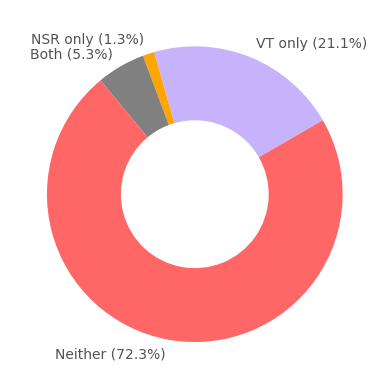

In [35]:
def create_pie_chart(metric, suffix = ""):
    data = create_total_stats(metric, suffix = suffix)
    data["Other"] = data["Total"] - data.iloc[:-1,:].sum(axis = 1)
    stats = data.sum()
    nsr_only = (stats["NSR_only"]/stats["Total"]) * 100
    v_only =  (stats["Velocity_only"]/stats["Total"]) * 100
    both = (stats["Both"]/stats["Total"]) * 100
    neither = (stats["Neither"]/stats["Total"]) * 100
    labels = [f"VT only ({v_only:.1f}%)", 
              f"NSR only ({nsr_only:.1f}%)",
              f"Both ({both:.1f}%)",
              f"Neither ({neither:.1f}%)"]
    y = np.array([v_only, nsr_only, both, neither])
    font_color = '#525252'
    colors = ['#c7b3fb', 'orange', 'grey', '#ff6666'] # change color both or neither 

    fig ,ax = plt.subplots()
    ax.pie(y, 
           labels= labels,
           startangle=30, 
           wedgeprops=dict(width=.5), # For donuts
           colors=colors, 
           textprops={'color':font_color},
           pctdistance=0.8,
           )
create_pie_chart("ksat")

In [36]:
def get_train_test(type, data, drops = None):
    if data == "VT":
        pb = VELOCITY_PLOT_PROBS.copy()
        suffix = "v"
    if data == "NSR":
        pb = NSR_PLOT_PROBS.copy()
        suffix = "nsr"
    v_probs = pb.groupby("site",as_index=False).agg({
                                                        "lat":"median",
                                                        "lon":"median", 
                                                        f"num_pf_{suffix}":"sum",
                                                        "num_event":"sum",
                                                        "num_event_growing": "sum",
                                                        "num_pf_growing": "sum", 
                                                        "num_event_non_growing": "sum", 
                                                        "num_pf_non_growing": "sum",
                                                        "NPP":"median",
                                                        "GPP":"median",
                                                        "ET":"median",
                                                        "MAT":"median",
                                                        "MAP":"median",
                                                        "aridity":"median",
                                                        "sand":"median",
                                                        "silt":"median",
                                                        "clay":"median",
                                                        "canopy":"median",
                                                        "site_storm_intensity":"median",
                                                        "site_storm_intensity_growing": "median", 
                                                        "site_storm_intensity_non_growing": "median",
                                                        "landcover": lambda x: x.unique()[0]})
    v_probs["p_total"] = v_probs[f"num_pf_{suffix}"]/v_probs["num_event"]
    v_probs["p_growing"] = v_probs["num_pf_growing"]/v_probs["num_event_growing"]
    v_probs["p_non_growing"] = v_probs["num_pf_non_growing"]/v_probs["num_event_non_growing"]
    v_probs = v_probs.drop(columns=[f"num_pf_{suffix}","num_event", "num_pf_non_growing","num_event_non_growing",
                                    "num_pf_growing","num_event_growing", "site",
                                     "lat", "lon", "silt"]).copy()
    
    if drops is not None:
        v_probs = v_probs.drop(columns=drops)
    if type == "all":
        total_data = v_probs.drop(columns = ["p_growing", "p_non_growing",  
                                             "site_storm_intensity_growing", 
                                            "site_storm_intensity_non_growing"]).copy().dropna()
        print(total_data.shape)
        # total_data = total_data[total_data["p_total"]>0].copy()
        y = total_data["p_total"]
        x = total_data.drop("p_total", axis = 1)
        
    if type == "growing":
        total_data = v_probs.drop(columns = ["p_total", "p_non_growing",  
                                             "site_storm_intensity", 
                                            "site_storm_intensity_non_growing"]).copy().dropna()
        total_data = total_data[total_data["p_growing"]>0].copy()
        y = total_data["p_growing"]
        x = total_data.drop("p_growing", axis = 1)
            
    if type == "non_growing":
        total_data = v_probs.drop(columns = ["p_total", "p_growing",  
                                             "site_storm_intensity", 
                                            "site_storm_intensity_growing"]).copy().dropna()
        total_data = total_data[total_data["p_non_growing"]>0].copy()
        y = total_data["p_non_growing"]
        x = total_data.drop("p_non_growing", axis = 1)
        

    x =  pd.get_dummies(x, columns= ["landcover"], dtype=int)
    
 
    return train_test_split(x, y, test_size=.4, random_state=42)

# X_train_vt_t, X_test_vt_t, y_train_vt_t, y_test_vt_t = get_train_test("all", "VT", ["GPP"])     
# X_train_nsr_t, X_test_nsr_t, y_train_nsr_t, y_test_nsr_t = get_train_test("all", "NSR", ["GPP"])        


In [37]:
def create_correlate(vt_hub:tuple, nsr_hub:tuple, title1:str, title2:str):
    import seaborn as sns
    X_train_vt_t, X_test_vt_t = vt_hub["X_train"], vt_hub["X_test"]
    y_train_vt_t, y_test_vt_t =  vt_hub["y_train"], vt_hub["y_test"]

    X_train_nsr_t, X_test_nsr_t = nsr_hub["X_train"], nsr_hub["X_test"]
    y_train_nsr_t, y_test_nsr_t = nsr_hub["y_train"], nsr_hub["y_test"]

    fig, ax = plt.subplots(1,2,figsize  = (17, 5))
    corr_vt_pre = pd.concat([X_train_vt_t, X_test_vt_t])
    corr_vt_tar = pd.concat([y_train_vt_t, y_test_vt_t])
    corr_nsr_pre = pd.concat([X_train_nsr_t, X_test_nsr_t])
    corr_nsr_tar = pd.concat([y_train_nsr_t, y_test_nsr_t])
    vt_all = pd.concat([corr_vt_pre, corr_vt_tar], axis=1)
    nsr_all = pd.concat([corr_nsr_pre, corr_nsr_tar], axis=1)
    index_mapping = {'landcover_Grassland': 'Grassland', 'landcover_Mixed Grassland': 'Mixed grassland',
                     "landcover_Shrubland": "Shrubland", "canopy":"Canopy height", 
                     "landcover_Mixed Forest": "Mixed forest",
                     "landcover_Cropland":"Cropland",
                     "MAP": "Mean annual precipitation",
                     "ET":"Evapotranspiration", "MAT": "Mean annual temperature", 
                     "aridity": "Aridity (PET/P)", "sand": "Sand content",
                     "landcover_Forest":"Forest", "clay":"Clay content",
                     "NPP": "Net primary productivity",
                     "site_storm_intensity": "Peak rainfall intensity",
                     "p_total": "PF probability",
                     "median_sm": "Antecedent SM",
                     "cv_sm": "Antecedent SM C.V."} 
    vt_all = vt_all.rename(columns=index_mapping).drop(columns=['Grassland', 'Mixed grassland',
                                                                "Shrubland", "Mixed forest","Cropland",
                                                               "Forest",])
    nsr_all = nsr_all.rename(columns=index_mapping).drop(columns=['Grassland', 'Mixed grassland',
                                                                "Shrubland", "Mixed forest", "Cropland",
                                                               "Forest",])
    # Create a mask for the upper triangle
    mask = np.triu(np.ones_like(vt_all.corr(), dtype=bool))

    mask2 = np.triu(np.ones_like(nsr_all.corr(), dtype=bool))
    sns.heatmap(vt_all.corr(), mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
                cbar_kws={"shrink": .8}, square=True, linewidths=.5, ax = ax[0], vmin=-1, vmax=1)
    sns.heatmap(nsr_all.corr(), mask=mask2, annot=True, fmt=".2f", cmap='coolwarm',
                cbar_kws={"shrink": .8}, square=True, linewidths=.5, ax = ax[1], vmin=-1, vmax=1)
    ax[0].tick_params("both", labelsize = 12)
    ax[1].tick_params("both", labelsize = 12)
    ax[0].text(0.8,0.8, "a", fontsize = 20, transform = ax[0].transAxes )
    ax[1].text(0.8,0.8, "b", fontsize = 20, transform = ax[1].transAxes )
    ax[0].set_title(title1, fontsize = 20, transform = ax[0].transAxes )
    ax[1].set_title(title2, fontsize = 20, transform = ax[1].transAxes )
    for cax in [ax[0].collections[0].colorbar.ax, ax[1].collections[0].colorbar.ax]:
        cax.tick_params(labelsize=12)


In [38]:
def fit_ML_models(X:pd.DataFrame, y:pd.DataFrame):
    """fit the random forest model.
    Args:
        X (_type_): _description_
        y (_type_): _description_

    Returns:
        _type_: _description_
    """
    param_rf = {
        'n_estimators': [10, 50, 100, 300, 500],  # Number of trees
        'min_samples_split':[2, 3, 4],  # Minimum samples required to split an internal node
        'min_samples_leaf': [1, 2, 3],  # Minimum samples required to be at a leaf node
        'max_features': ["log2"],
        "max_depth":[None, 3, 5, 7, 10]
    }
    random_forest =  RandomForestRegressor(random_state=42)
    gcv_rf = GridSearchCV(random_forest, param_grid = param_rf, cv = 3, n_jobs=15, scoring="neg_mean_squared_error")
            
    return  gcv_rf.fit(X,y)

In [39]:
def get_rf_model(X,y, model):
    results = permutation_importance(model.best_estimator_, X, y, n_repeats= 500, random_state=42, scoring= "r2")
    print(model.best_estimator_.get_params())
    feature_df = pd.DataFrame({"Feature":X.columns.to_numpy(), 
                                "Importance score":results.importances_mean})
    feature_df = feature_df.sort_values(by='Importance score', ascending=True)
    index_mapping = {'landcover_Grassland': 'Grassland', 'landcover_Mixed Grassland': 'Mixed grassland',
                     "landcover_Shrubland": "Shrubland", "canopy":"Canopy height", 
                     "landcover_Mixed Forest": "Mixed forest",
                     "landcover_Cropland":"Cropland",
                     "MAP": "Mean annual precipitation",
                     "ET":"Evapotranspiration", "MAT": "Mean annual temperature", 
                     "aridity": "Aridity (PET/P)", "sand": "Sand content",
                     "landcover_Forest":"Forest", "clay":"Clay content",
                     "NPP": "Net primary productivity",
                     "site_storm_intensity": "Peak rainfall intensity",
                     "median_sm":"Antecedent SM",
                     "cv_sm": "Antecedent SM C.V."
                     } 
    
    feature_df = feature_df.set_index('Feature')
    feature_df = feature_df.rename(index=index_mapping)
    best_model = model.best_estimator_
    # print(model_output.get_params())
    # Make predictions on the validation set 
    y_pred = best_model.predict(X)
    r2 = r2_score(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    return {"model":best_model, "yhat":y_pred, "ytrue":y , "r2": r2, "rmse":rmse, "importance":feature_df,
            "model_param":model.best_params_}

In [40]:
def plot_feature_importance(title1, title2, vt_info = None, nsr_info= None, total_if = True,):
    fig, ax = plt.subplots(2, 2, figsize = (10,10))
    if total_if:
        VT_rf = get_rf_model(pd.concat([vt_info["X_train"], vt_info["X_test"]]), 
                             pd.concat([vt_info["y_train"], vt_info["y_test"]]), 
                             vt_info["model"])
        NSR_rf = get_rf_model(pd.concat([nsr_info["X_train"], nsr_info["X_test"]]),
                              pd.concat([nsr_info["y_train"], nsr_info["y_test"]]),
                              nsr_info["model"])
    else:
        VT_rf = get_rf_model(vt_info["X_test"], vt_info["y_test"], vt_info["model"])
        NSR_rf = get_rf_model(nsr_info["X_test"], nsr_info["y_test"], nsr_info["model"])
    hub = [VT_rf, NSR_rf]
    training_info = [vt_info, nsr_info]
    # labels = ["VT", "NSR"]
    labels = [title1, title2]
    colors = ["purple", "orange"]
    num = [["a","b"], ["c", "d"]]
    for i in range(2):
        data = hub[i]
        info_i = training_info[i]
        # get the training R2
        pred_train = info_i["model"].best_estimator_.predict(info_i["X_train"])
        pred_test = info_i["model"].best_estimator_.predict(info_i["X_test"])
        r2_train = r2_score(info_i["y_train"], pred_train)
        r2_test = r2_score(info_i["y_test"], pred_test) 
        rmse_train =  np.sqrt(mean_squared_error(info_i["y_train"], pred_train))
        rmse_test = np.sqrt(mean_squared_error(info_i["y_test"], pred_test))
        print(r2_train, r2_test, rmse_train, rmse_test)
        ax[i, 0].barh(data["importance"].index, data["importance"]['Importance score'], color=colors[i])
        ax[i, 1].scatter(pred_train, info_i["y_train"], s = 100,
                         edgecolor = "grey", facecolor = "none", label = f"Training: $R^2$ = {r2_train:.2f}, RMSE = {rmse_train:.2f} ($n$ = {pred_train.shape[0]})")
        ax[i, 1].scatter(pred_test, info_i["y_test"], s = 100,
                         edgecolor = colors[i], facecolor = "none", label = f"Testing: $R^2$ = {r2_test:.2f},  RMSE = {rmse_test:.2f} ($n$ = {pred_test.shape[0]})")
        ax[i, 1].set_xlim([0, 0.7])
        ax[i, 1].set_ylim([0, 0.7])
        ax[i, 1].plot([0, 0.7], [0, 0.7], c= "grey", ls = "dashed", lw = 2)
        ax[i, 1].xaxis.set_major_locator(plt.MaxNLocator(5))
        ax[i, 1].xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

        ax[i, 1].yaxis.set_major_locator(plt.MaxNLocator(5))
        ax[i, 1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
        ax[i, 0].tick_params("both", labelsize = 13)  
        ax[i, 1].tick_params("both", labelsize = 13)  
        ax[i, 0].set_xlim([-0.1, 0.3])
        ax[i, 1].set_xlabel(f"Fitted probability of PF ({labels[i]})",fontsize = 14)
        ax[i, 1].set_ylabel(f"Probability of PF ({labels[i]})", fontsize = 14)
        ax[i, 0].text(-0.1, 1, num[i][0], transform = ax[i, 0].transAxes,
                      fontsize = 18)
        ax[i, 1].text(-0.18,1, num[i][1], transform = ax[i, 1].transAxes,
                      fontsize = 18)
        ax[i, 1].legend(fontsize = 8)
        ax[i, 0].set_xlabel("Decrease in $R^2$", fontsize = 14) 
        plt.savefig('grl_main_figure2.pdf', bbox_inches='tight', dpi=300)


In [41]:
def compute_partial_dependence(model, 
                               X, 
                               features, 
                               grid_resolution=100):
    pdp_list = []
    grid_list = []
    for f in features:
        values = np.linspace(X[f].min(), X[f].max(), grid_resolution)
        pdp = np.zeros(grid_resolution)
        X_temp = X.copy()
        for i, val in enumerate(values):
            X_temp[f] = val
            pdp[i] = model.predict(X_temp).mean()
        pdp_list.append(pdp)
        grid_list.append(values)
    return grid_list, pdp_list

In [42]:
def get_color(name, size,  reverse=False):
    cmap = plt.get_cmap(name)
    if size > 2:
        thresholds = [0.1, 0.5, 0.8]
    else:
        thresholds = [0.2, 0.7]
    if reverse:
        thresholds = thresholds[::-1]
    colors = [cmap(i) for i in thresholds]
    return colors


In [43]:
def plot_pdp(pdp_vt_info:dict, pdp_nsr_info:dict, features:list[str],
             ylim:tuple = (0.05, 0.075),
             ylim_left:tuple = (0.28, 0.42),
             grid = 10) ->None:
             
    """get partial dependence plot

    Args:
        pdp_vt_info (dict): VT traing,testing, model info.
        pdp_nsr_info (dict): VT traing,testing, model info.
        features (list[str]): list of features to plot [4 elements].
    """
    nsr_data = pd.concat([pdp_nsr_info["train_X"], pdp_nsr_info["test_X"]])
    plt_nsr_data = nsr_data.copy()
    pdp_nsr = compute_partial_dependence(pdp_nsr_info["model"].best_estimator_, nsr_data, features, grid)
    plt_nsr_data["site_storm_intensity"] = plt_nsr_data["site_storm_intensity"] * 6
    fig, ax = plt.subplots(3, 2, figsize= (15, 15))
    style_dict = dict(
        site_storm_intensity=dict(
            shade_threshold=[(0, 2.5), (2.5, 7.6), (7.6, 100)],
            xlim=[0, 25],
            tickx= [0, 5, 10, 15, 20, 25],
            cate_labels =  [[0.015, 0.85], [0.13, 0.85], [0.6, 0.875]],
            threshold_labels = ["Light\nrain", "Moderate\nrain", "Heavy rain"],
            c= get_color("Blues", 3),
            x_label="Peak rainfall intensity [mm/h]"
        ),

        cv_sm =dict(
            xlim=[20, 75],
            tickx= [20, 35, 50, 65, 75],
            c= get_color("Blues", 3),
            x_label="Antecedent SM C.V. [%]",
            shade_threshold = False,
            cate_labels = False,
            threshold_labels = False
        ),

        median_sm =dict(
            xlim=[0.05, .3],
            tickx= [0.05, .1, .15, .2, .25, .3],
            c= get_color("Blues", 3),
            x_label="Antecedent SM [cm$^{3}$/cm$^{3}$]",
            shade_threshold = False,
            cate_labels = False,
            threshold_labels = False
        ),
                
        NPP=dict(
            shade_threshold= [(0, 0.8), (0.8, 20)],
            xlim=[0, 1.75],
            tickx=[0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75],
            cate_labels =[[0.15/1.75, 0.85], [0.6, 0.875]],
            threshold_labels= ["Crops & temperate\ngrasslands", "Temperate forests"],
            c= get_color("Greens",2),
            x_label="Net primary productivity [kgC m$^{-2}$ yr$^{-1}]$"
        ),
        clay=dict(
            shade_threshold= [(0, 20), (20, 40), [40, 100]],
            xlim=[0, 70],
            tickx= [0, 10, 20, 30, 40 , 50, 60, 70],
            cate_labels =[[0.06, 0.85], [0.35, 0.85], [0.7, 0.85]],
            threshold_labels= ["Sandy soil", "Loamy soil", "Clayey soil"],
            c=get_color("Oranges",3),
            x_label="Clay content [%]"
            ),
        aridity=dict(
            shade_threshold=[(0, 2), (2, 5), (5, 100)] ,
            xlim=[0, 9],
            tickx= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
            cate_labels = [[0.03, 0.85], [0.3, 0.85], [0.75, 0.85]],
            threshold_labels= ["Humid &\nSub-humid", "Semi-arid","Arid"],
            c=get_color("Greys",3),
            x_label="Aridity index (PET/P) [-]"
        )
    )

    nums = ["a", "b", "c", "d", "e", "f"]
    for i in np.arange(len(features)):
        row = i // 2 
        col = i % 2
        var_name = features[i]
        color = style_dict[var_name]["c"]
        nsr_grid = pdp_nsr[0][i]
        feature_threshold = style_dict[var_name]["shade_threshold"]
        thresh_label_loc=  style_dict[var_name]["cate_labels"]
        thresh_labels =  style_dict[var_name]["threshold_labels"]
        x_label = style_dict[var_name]["x_label"]
        if var_name == "site_storm_intensity":
            nsr_grid = nsr_grid * 6
        for ksat_vt_info in pdp_vt_info: # dict in a list
            line_alpha = 1
            line_style = "solid"
            vt_data = pd.concat([ksat_vt_info["train_X"], ksat_vt_info["test_X"]])
            plt_vt_data = vt_data.copy()
            pdp_vt = compute_partial_dependence(ksat_vt_info["model"].best_estimator_, vt_data, features, grid)
            plt_vt_data["site_storm_intensity"] = plt_vt_data["site_storm_intensity"] * 6
            vt_grid = pdp_vt[0][i]
            if var_name == "site_storm_intensity":
                vt_grid = vt_grid * 6
            if ksat_vt_info["vt_type"] == "std_median_":
                line_style = "dashed"
                line_alpha = 0.3 # smallest threshold 
            if ksat_vt_info["vt_type"] == "std_upper_":
                line_style = "dashed"
                line_alpha = 0.7 # intermediate threshold threshold 
                
            ax[row, col].plot(vt_grid, pdp_vt[1][i], c = "purple", lw = 2.5, ls = line_style, alpha = line_alpha)
           
            if ksat_vt_info["vt_type"] == "": 
                sns.rugplot(plt_vt_data[features[i]] , ax=ax[row, col], color='black', height=.03)
        anotherx = ax[row, col].twinx()
        ax[row, col].set_xlabel(x_label, fontsize = 15)
        ax[row, col].tick_params(axis='y', colors='purple', direction='out')
        ax[row, col].tick_params("both", direction='out', labelsize = 15)
        anotherx.spines['left'].set_color('purple')
        anotherx.spines['right'].set_color('orange')  
        if i in [1,3,5]:
            anotherx.set_ylabel("Simulated Probability of PF (NSR)", fontsize = 15, c= "orange")
        anotherx.tick_params(axis='both', direction='out', labelsize= 15)
        anotherx.tick_params(axis='y', colors='orange', direction='out')
        anotherx.plot(nsr_grid, pdp_nsr[1][i], c = "orange", lw = 2.5)
        anotherx.spines['left'].set_linewidth(2.5) 
        anotherx.spines['right'].set_linewidth(2.5)
        sns.rugplot(plt_vt_data[features[i]] , ax=ax[row, col], color='black', height=.03)
        if feature_threshold:
            for th in np.arange(len(feature_threshold)):
                ax[row, col].fill_between(feature_threshold[th],
                                        y1 = 0, y2 = 1, color= color[th], alpha = 0.3)
                ax[row, col].text(thresh_label_loc[th][0],
                            thresh_label_loc[th][1],
                            thresh_labels[th],
                            transform = ax[row, col].transAxes, 
                            fontsize = 15)
        if i not in [1,3,5]:
            ax[row, col].set_ylabel("Simulated probability of PF (VT)", fontsize = 15, c= "purple")
        ax[row, col].tick_params(axis='y', colors='purple', direction='out')
        ax[row, col].tick_params("both", direction='out', labelsize = 15)
        anotherx.spines['left'].set_color('purple')
        anotherx.spines['right'].set_color('orange')  
        anotherx.set_ylabel("Simulated probability of PF (NSR)", fontsize = 15, c= "orange")
        anotherx.tick_params(axis='both', direction='out', labelsize= 15)
        anotherx.tick_params(axis='y', colors='orange', direction='out')
    

        ax[row, col].text(-0.15, 0.95, nums[i], transform = ax[row, col].transAxes,
                      fontsize = 25)

        anotherx.set_ylim(ylim[0],ylim[1])
        ax[row, col].set_ylim(ylim_left[0], ylim_left[1])
        ax[row, col].set_xlim(style_dict[var_name]["xlim"][0],style_dict[var_name]["xlim"][1])
        ax[row, col].set_xticks(style_dict[var_name]["tickx"])
        ax[row, col].set_xticklabels([str(val) for val in style_dict[var_name]["tickx"]])
    from matplotlib.lines import Line2D
    legend_lines = [
        Line2D([0], [0], color='purple', lw=2, linestyle='dashed', alpha=0.3, label='VT (Median K$\mathregular{_{sat\;weighted}}$)'),
        Line2D([0], [0], color='purple', lw=2, linestyle='dashed', alpha=0.7, label='VT (Median K$\mathregular{_{sat\;weighted}}$ + S.D.)'),
        Line2D([0], [0], color='purple', lw=2, alpha=1, label='VT (K$\mathregular{_{sat\;weighted}}$)'),
        Line2D([0], [0], color='orange', lw=2, label='NSR')
        ]
    ax[0, 0].legend(handles=legend_lines, loc='lower right', fontsize=12, framealpha=1)
    plt.tight_layout()
    plt.savefig('grl_main_figure3.pdf', dpi=300)

In [44]:
def save_table(save_table = False, table_name = "table"):
    nsr_stats = NSR_PLOT_PROBS.groupby("site",as_index=False).agg({
                                                        "lat": "median",
                                                        "lon":"median",
                                                        "landcover":lambda x: x.unique()[0],
                                                        "MAT":"median",
                                                        "MAP":"median",
                                                        "aridity":"median",
                                                        "num_pf_nsr":"sum",})
    vs_stats = VELOCITY_PLOT_PROBS.groupby("site",as_index=False).agg({
                                                        "num_pf_v":"sum",})
    table = pd.merge(nsr_stats, vs_stats, on = "site")

    table.columns = ["Site name", "Lat.", "Lon.", "Landcover", "MAT (°C)", "MAP (mm)", "Aridity (PET/P)", "# NSR PF", "# VT PF"]
    table[["Ecoregion", "State"]] = table["Site name"].apply(lambda x: pd.Series(get_ecoregion(x)))
    if save_table:
        table.to_csv(f"{table_name}.csv", index=False)
    return table
table_stats = save_table(False, "table_beta")
# data_length = pd.read_csv("data_length.csv").rename(columns={"years": "# yrs. data"})
# all_table_stats = pd.merge(table_stats, data_length, left_on="Site name", right_on= "site", how = "left").drop(columns="site")
# all_table_stats['Aridity (PET/P)'] = all_table_stats['Aridity (PET/P)'].round(3)
# all_table_stats['# yrs. data'] = all_table_stats['# yrs. data'].round(3)
table_stats = save_table(False, "table_beta")
print("the ecoregions of the sites:", set(table_stats["Ecoregion"]))
print("total number of ecoregions:", len(set(table_stats["Ecoregion"])))
print("table data", table_stats[["Site name", "Ecoregion", "State"]])

the ecoregions of the sites: {'D10', 'D09', 'D13', 'D16', 'D02', 'D08', 'D06', 'D14', 'D12', 'D05', 'D03', 'D15', 'D17', 'D04', 'D11', 'D01', 'D07'}
total number of ecoregions: 17
table data    Site name Ecoregion State
0       ABBY       D16    WA
1       BART       D01    NH
2       BLAN       D02    VA
3       CLBJ       D11    TX
4       CPER       D10    CO
5       DCFS       D09    ND
6       DELA       D08    AL
7       DSNY       D03    FL
8       GRSM       D07    TN
9       GUAN       D04    PR
10      HARV       D01    MA
11      JERC       D03    GA
12      JORN       D14    NM
13      KONZ       D06    KS
14      LAJA       D04    PR
15      LENO       D08    AL
16      MLBS       D07    VA
17      MOAB       D13    UT
18      NIWO       D13    CO
19      NOGP       D09    ND
20      OAES       D11    OK
21      ONAQ       D15    UT
22      ORNL       D07    TN
23      OSBS       D03    FL
24      RMNP       D10    CO
25      SCBI       D02    VA
26      SERC       D02    

In [45]:
# all_table_stats.to_csv("paper_table.csv", index = False)

In [46]:
def move_loc(row):
    name = row["site"]
    lat = row["lat"]
    lon = row["lon"]
    dx = 0
    dy = 0
    dx_dy_info = {"ABBY":[1.5, -0.8], "WREF":[1.5, 1.5], "DCFS":[-2.5, 0], "WOOD":[0, 3], "LAJA":[2, -2],
                  "GUAN":[1.5, 1], "SCBI":[1, -2.5], "BLAN":[2, 0.8], "ORNL":[2, -1], "GRSM":[-0.5, 2],
                  "NIWO":[-2, 1], "RMNP":[1, -2], "SJER":[2, -1.8], "SOAP":[1.8, 1], "TEAK":[-2, 1.5],
                  "TALL":[1.5, -0.5], "DELA":[0.5, 2.2], "LENO":[-0.8, 2]}
    if name in dx_dy_info:
        dy, dx = dx_dy_info[name]
    return (lat + dy, lon + dx, dy, dx)

site with minimum NSR is  0.0
site with maximum NSR is  0.24124513618677043
site with minimum VT is  0.016222479721900347
site with maximum VT is  0.6148825065274152


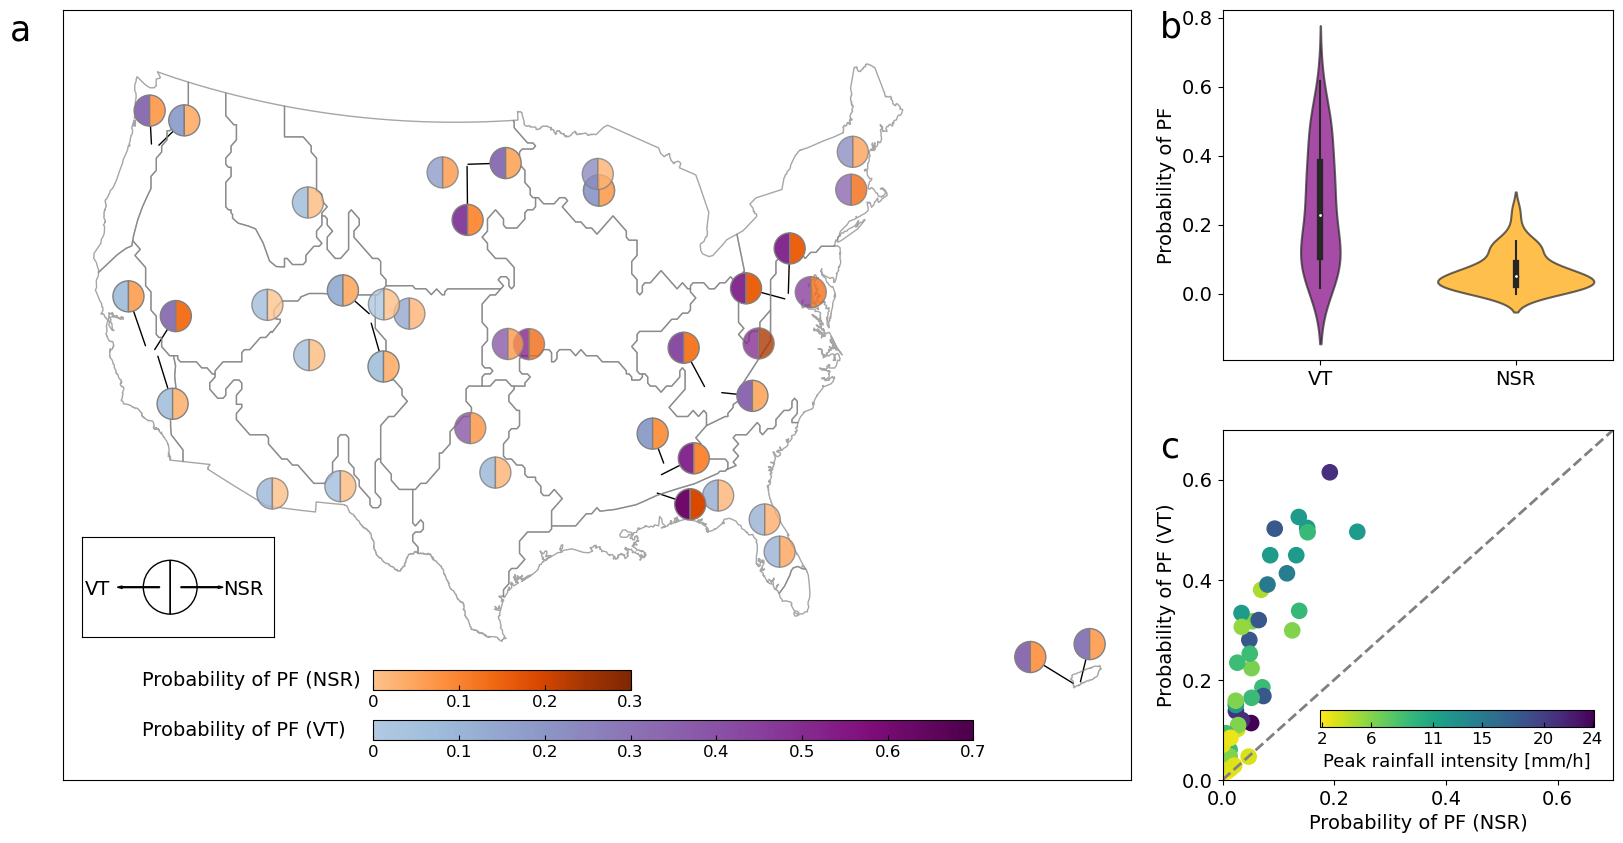

In [47]:
def nature_geo_fg1(cmaps, return_table = False):
    return_item = None
    exclude = ["ABBY", "WREF", "DCFS", "WOOD", "LAJA", "GUAN", "SCBI", "BLAN", "ORNL", "GRSM", "NIWO", "RMNP", "SJER", "SOAP", "TEAK", "TALL", "DELA", "LENO"]

    shp_file = gpd.read_file("../../../NEONDomains_0/NEON_Domains.shp")# need to replace this. 
    nsr_probs = NSR_PLOT_PROBS.groupby("site",as_index=False).agg({
                                                    "num_pf_nsr":"sum",
                                                    "num_event":"sum",
                                                    })
    velocity_probs = VELOCITY_PLOT_PROBS.groupby("site", as_index=False).agg({
                                                    "lat":"median",
                                                    "lon":"median", 
                                                    "num_pf_v":"sum",
                                                    "num_event":"sum",
                                                    "full_season_intensity":"median"})
    nsr_probs["p_nsr"] = nsr_probs["num_pf_nsr"]/nsr_probs["num_event"]
    velocity_probs["p_v"] = velocity_probs["num_pf_v"]/velocity_probs["num_event"]
    merge_all_gpd = pd.merge(nsr_probs, velocity_probs, on ="site", how = "inner")
    if return_table:
        return_item = merge_all_gpd

    merge_all_gpd[["lat_new", "lon_new", "dy", "dx"]] = merge_all_gpd.apply(move_loc, axis  = 1, result_type="expand")
    g1 = merge_all_gpd[~merge_all_gpd["site"].isin(exclude)].copy()
    gdf = gpd.GeoDataFrame(g1, geometry=gpd.points_from_xy(g1.lon_new, g1.lat_new))
    gdf.crs = "EPSG:4326"
    gdf = gdf.to_crs("EPSG:2163")

    g2 = merge_all_gpd[merge_all_gpd["site"].isin(exclude)].copy()
    gdf2 = gpd.GeoDataFrame(g2, geometry=gpd.points_from_xy(g2.lon_new, g2.lat_new))
    gdf2.crs = "EPSG:4326"
    gdf2 = gdf2.to_crs("EPSG:2163")

    shp_file = shp_file.to_crs("EPSG:2163")# Plot your Shapefile and the field sites

    from matplotlib.gridspec import GridSpec 
    # create subplots
    fig = plt.figure(figsize = (20, 10))
    gs = GridSpec(2, 3, figure=fig, width_ratios= [1, 2, 1.2], height_ratios=[1, 1])
    ax1 = fig.add_subplot(gs[:, :2]) # spatial plots
    ax3 = fig.add_subplot(gs[0, -1]) # scatter with colored by storm intensity
    ax2 = fig.add_subplot(gs[1, -1]) # boxplot

    
    shp_file.boundary.plot(ax=ax1, linewidth=1,edgecolor ="grey", alpha = 0.7)
    
    norm_nsr = Normalize(vmin=0,
                         vmax=.3)
    norm_v = Normalize(vmin=0,vmax=.7)
    print("site with minimum NSR is ", merge_all_gpd["p_nsr"].min())
    print("site with maximum NSR is ",merge_all_gpd["p_nsr"].max())
    print("site with minimum VT is ", merge_all_gpd["p_v"].min())
    print("site with maximum VT is ",merge_all_gpd["p_v"].max())
    
    def adjust_colormap(cmap_name, minval=0.0, maxval=1.0, n=100):
        import matplotlib.colors as mcolors
        cmap = plt.get_cmap(cmap_name)
        new_cmap = mcolors.LinearSegmentedColormap.from_list('adjusted({n},{a:.2f},{b:.2f})'.format(n=cmap_name, a=minval, b=maxval),
                                                              cmap(np.linspace(minval, maxval, n)))
        return new_cmap

    adj_cmap_vt = adjust_colormap(cmaps["VT"], 0.3, 1)
    
    sm1 = ScalarMappable(cmap=adj_cmap_vt, norm=norm_v)
    sm1.set_array([])  # Dummy data to create the ScalarMappable     
    gdf.plot(ax=ax1,markersize=500, 
             cmap = adj_cmap_vt,
             zorder=20, legend=False, column="p_v",
             edgecolor="grey", alpha=0.8,norm = norm_v,
             marker=MarkerStyle("o", fillstyle="left"),
             legend_kwds={
                        "shrink": 0.7,
                    })

    adj_cmap_nsr = adjust_colormap(cmaps["NSR"], 0.3, 1)
    sm2 = ScalarMappable(cmap=adj_cmap_nsr, norm=norm_nsr)
    sm2.set_array([])  # Dummy data to create the ScalarMappable    
    gdf.plot(ax=ax1, markersize=500, cmap=adj_cmap_nsr,
             zorder=20, legend=False, column="p_nsr",
             edgecolor="grey", alpha=0.8,norm = norm_nsr,
                        marker=MarkerStyle("o", fillstyle="right"),
                        legend_kwds={
                            "shrink": 0.4,
                            "pad":-0.15,
                            # "orientation":"horizontal",
                            "location":"bottom",
                            "anchor": (.3,1)
                        })

    gdf2.plot(ax=ax1, markersize=500, cmap = adj_cmap_vt,
              zorder=20, legend=False, column="p_v",
              edgecolor="grey", alpha= 1,norm = norm_v,
                    marker=MarkerStyle("o", fillstyle="left"),
                    legend_kwds={
                        "shrink": 0.7,
                        
                    })


        
    gdf2.plot(ax=ax1, markersize=500, cmap=adj_cmap_nsr,
                        zorder=20, legend=False, column="p_nsr",
                        edgecolor="grey", alpha=1,norm = norm_nsr,
                        marker=MarkerStyle("o", fillstyle="right"),
                        legend_kwds={
                            "shrink": 0.4,
                            "pad":-0.15,
                            # "orientation":"horizontal",
                            "location":"bottom",
                            "anchor": (.3,1)
                            
                        })

    ax1.set_xlim([-2.2*1e6, 3.8*1e6])
    ax1.set_ylim([-2.8*1e6, 1*1e6])
    ax1.set_aspect('auto', adjustable=None)

    # Assuming you have your GeoDataFrame 'gdf' and the map 'ax' already defined

    for _, ar in gdf2.iterrows():
        if ar["dy"] != 0 or ar["dx"] != 0:       
            
            arrow_start = Point(ar["lon"], ar["lat"])
            arrow_end = Point(ar["lon_new"], ar["lat_new"])

            # Convert Point geometries to GeoDataFrame for coordinate transformation
            arrow_start_series = gpd.GeoSeries([arrow_start], crs="EPSG:4326")
            arrow_end_series = gpd.GeoSeries([arrow_end], crs="EPSG:4326")

            # Transform arrow coordinates to EPSG:2163
            arrow_start_transformed = arrow_start_series.to_crs("EPSG:2163").geometry.iloc[0]
            arrow_end_transformed = arrow_end_series.to_crs("EPSG:2163").geometry.iloc[0]


           # Create and add arrow to the plot
            arrow = FancyArrowPatch(
                posA= ( arrow_start_transformed.x,arrow_start_transformed.y),
                posB=(arrow_end_transformed.x, arrow_end_transformed.y),
                mutation_scale=15,
                arrowstyle="->",
                facecolor="black",
                edgecolor="black"
            )
            ax1.add_patch(arrow)


    ax1.set_xticks([])
    ax1.set_yticks([])
    
    sm_vt = plt.cm.ScalarMappable(cmap=adj_cmap_vt, norm=norm_v)
    sm_vt._A = []  # Fake up the array of the scalar mappable
    cbar = fig.colorbar(sm_vt, ax=ax1, orientation="horizontal", fraction=0.05, pad=0.05,
                     cax=fig.add_axes([0.28, .15, 0.3, 0.02]))  # Adjust the position and size of the colorbar
    tick_positions = [0, .1, .2, .3, .4, .5, .6, .7]
    tick_labels = ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7']
    cbar.ax.set_xticks(tick_positions)
    cbar.ax.set_xticklabels(tick_labels)
    cbar.ax.tick_params(labelsize=12, direction = "in")
    cbar.ax.text(-0.27,0.2, "Probability of PF (VT)", fontsize = 14)
    
    sm_nsr = plt.cm.ScalarMappable(cmap=adj_cmap_nsr, norm=norm_nsr)
    sm_nsr._A = []  # Fake up the array of the scalar mappable
    cbar_nsr = fig.colorbar(sm_nsr, ax=ax1, orientation="horizontal", fraction=0.05, pad=0.05,
                     cax=fig.add_axes([0.28, .2, 0.3 * 3 / 7, 0.02]))  # Adjust the position and size of the colorbar
    tick_positions_nsr = [0, 0.1, 0.2, 0.3]
    tick_labels_nsr = ['0', '0.1', '0.2', '0.3']
    cbar_nsr.ax.set_xticks(tick_positions_nsr)
    cbar_nsr.ax.set_xticklabels(tick_labels_nsr)
    cbar_nsr.ax.tick_params(labelsize=12, direction = "in")
    cbar_nsr.ax.text(-0.27,0.2, "Probability of PF (NSR)", fontsize = 14)

    ax_legend = ax1.inset_axes([0.017, 0.185, 0.18, 0.13])

    ax_legend.set_xticks([])
    ax_legend.set_yticks([])
    ax_legend.scatter(0.1,0.25,s = 1500, transform = ax1.transAxes,
            edgecolor="black",  facecolor = "none",
            marker=MarkerStyle("o", fillstyle="left"),)
    ax_legend.scatter(0.1,0.25,s = 1500, transform = ax1.transAxes,
            edgecolor="black",  facecolor = "none",
            marker=MarkerStyle("o", fillstyle="right"),)
    ax_legend.arrow(0.09, 0.25, -0.035, 0,transform = ax1.transAxes)
    ax_legend.arrow(0.11, 0.25, 0.035, 0,transform = ax1.transAxes)
    ax_legend.text(0.09 - 0.07, 0.24, "VT", transform = ax1.transAxes, fontsize  = 14)
    ax_legend.text(0.11 + 0.04, 0.24, "NSR",transform = ax1.transAxes, fontsize = 14)
    scatter = ax2.scatter(merge_all_gpd["p_nsr"], merge_all_gpd["p_v"],
                      c=merge_all_gpd["full_season_intensity"] * 6,
                      cmap="viridis_r", s=120)
    
    norm_scatter = Normalize(vmin=merge_all_gpd["full_season_intensity"].min() * 6,
                         vmax=merge_all_gpd["full_season_intensity"].max() * 6)

    # Create an inset axes within the subplot for the colorbar
    cax = ax2.inset_axes([0.25, 0.15, 0.7, 0.05])  # [left, bottom, width, height] in relative coordinates to ax2

    cbar_scatter = plt.colorbar(scatter, cax=cax, orientation='horizontal',
                            ticks=[round(i) for i in np.linspace(norm_scatter.vmin, norm_scatter.vmax, 6)],
                            norm=norm_scatter)
    cbar_scatter.set_label("Peak rainfall intensity [mm/h]", fontsize=13)
    cbar_scatter.ax.tick_params(labelsize=12, direction = "in")
    ax2.set_xlim([0, 0.7])
    ax2.set_ylim([0, 0.7])
    num_ticks = 4

    # Set the locator and formatter for the x-axis
    ax2.xaxis.set_major_locator(plt.MaxNLocator(num_ticks))
    ax2.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))

    # Set the locator and formatter for the y-axis
    ax2.yaxis.set_major_locator(plt.MaxNLocator(num_ticks))
    ax2.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))   
    ax2.tick_params("both",labelsize = 14)
    ax2.plot([0,1], [0,1], ls = "dashed", lw = 2, c= "grey")
    ax2.set_xlabel("Probability of PF (NSR)", fontsize = 14)
    ax2.set_ylabel("Probability of PF (VT)", fontsize = 14)
    
    vo_plot = sns.violinplot(data=merge_all_gpd[["p_v", "p_nsr"]], 
                             palette= ["Purple", "Orange"], inner="box", ax = ax3,
                   linewidth=1.5)
    from matplotlib.collections import PolyCollection

    for i, patch in enumerate(vo_plot.findobj(PolyCollection)):
       
        if i % 2 == 0:  # Even indexed patches are violins
            patch.set_facecolor("Purple")  # Set face color for Column1
            patch.set_alpha(0.7)
        else:
            patch.set_facecolor("Orange")  # Set face color for Column2
            patch.set_alpha(0.7)  # Set transparency (alpha) to 0.7

    ax3.set_ylabel("Probability of PF", fontsize = 14)
    ax3.set_xticklabels(["VT", "NSR"],fontsize = 14)
    ax3.tick_params("both", labelsize=14)
    ax1.text(-0.05, 0.96, 'a', transform=ax1.transAxes, fontsize = 25)
    ax2.text(-0.16, 0.92, 'c', transform=ax2.transAxes, fontsize = 25)
    ax3.text(-0.16, 0.92, 'b', transform=ax3.transAxes, fontsize = 25)
    fig.savefig('grl_main_figure1.pdf', bbox_inches='tight', dpi=300)
    return return_item
temp_data = nature_geo_fg1(dict(VT= "BuPu", NSR="Oranges"), True) # introdcution 

In [48]:
def calc_site_ante_sm_range(site, metric, suffix):
    site_PF = FINAL_PF_RESULTS[site]
    max_sm = 0
    min_sm = 99999
    for p in site_PF:
        expand_events = ["is_event", "is_pf"]
        p = p.copy()
        cal_v_cols = [j for j in p.columns if j.split("_")[0] == "velocity"]
        # if any is true then true other wise false
        v_model = [f"PF_{metric}_metric_{suffix}50{j}" for j in np.arange(1,len(cal_v_cols) + 1)]
        v_reponse = [f"smResponseType_50{j}" for j in np.arange(1,len(cal_v_cols) + 1)]
        # It is site characteristic   
        v_onset = [f"smAtOnset_50{j}" for j in  np.arange(1,len(cal_v_cols) + 1)]
        v_before = [f"smBeforePrecip_50{j}" for j in  np.arange(1,len(cal_v_cols) + 1)]                
        p[expand_events] = p.apply(parse_is_event_and_pf, args=(v_reponse, v_model,), axis = 1, result_type="expand")
        p[v_onset + v_before] = p[v_onset + v_before].replace(-9999, np.nan)  
        current_max = np.max(p.loc[p["is_event"], v_onset + v_before])
        current_min = np.min(p.loc[p["is_event"], v_onset + v_before])
        if current_max > max_sm:
            max_sm = current_max
        if current_min < min_sm:
            min_sm = current_min
        assert max_sm > min_sm and not np.isnan(max_sm) and not np.isnan(min_sm), "oops, problem!"
    return (min_sm + max_sm)/2    

In [49]:
def count_lower_upper(row, threshold):
    row_cleaned = row.dropna()
    groups = {}
    for idx, value in row_cleaned.items():
        prefix = idx.split("_")[-1]
        if "smAtOnset_" in idx or "smBeforePrecip_" in idx:
            if prefix not in groups:
                groups[prefix] = []
            groups[prefix].append(value)
    if len(groups.keys()) > 0:
        valid_group_count = 0
        for suffix, values in groups.items():
            if any(v > threshold for v in values):  # any greater than this threshold
                valid_group_count += 1
        return valid_group_count/len(groups.keys())
    return np.nan

In [50]:
def rainfall_by_ante_sm(metric, suffix = "")->pd.DataFrame:
    """Get probability for each soil plot at NEON sites

    Returns:
        pd.DataFrame: Probability of pf by velocity based criterion. 
    """    
    plot_wise_info = []
    plot_site_param = []
    for s in FINAL_PF_RESULTS.keys():
        site_PF = FINAL_PF_RESULTS[s]
        # some site variables
        lat, lon = get_lat_lon(s)
        aridity = get_aridity(s)
        MAT  = get_site_condition(s, "MAT")
        MAP = get_site_condition(s, "MAP")
        landcover = get_landcover(s)
        gpp = get_annual_gpp(s) 
        npp = get_annual_npp(s) 
        et = get_annual_et(s)
        canopy = get_canopy_height(s)
        sand, silt, clay, porosity, eff_porosity, rootdensity = get_surface_soil_props(s)
        if (s not in EXCLUDED_SITE):
            if len(site_PF) > 0:
                plot_scale_stats = []
                plot_growing = []
                plot_no_growing = []
                overall_intensity = []
                low_sm = []
                high_sm = []
                sm_threshold = calc_site_ante_sm_range(s, metric=metric,suffix=suffix)
                for p in site_PF:
                    expand_events = ["is_event", "is_pf"]
                    expand_texture = ["surface_sand", "surface_silt", "surface_clay", "surface_porosity",
                                      "surface_eff_porosity", "surface_root_density"]
                    p = p.copy()
                    p["month"] = p["stormStartTime"].dt.month
                    p["season"] = p["month"].apply(lambda x: "growing" if 4 <= x <= 9 else "non_growing")
                    # total_intensity
                    full_season_intensity = p["stormPeakIntensity"].median()
                    growing_season_intensity = p.loc[p["season"] == "growing", "stormPeakIntensity"].median()
                    non_growing_season_intensity = p.loc[p["season"] == "non_growing", "stormPeakIntensity"].median()
                    # after removing the not applicable.
                    cal_v_cols = [j for j in p.columns if j.split("_")[0] == "velocity"]
                    # if any is true then true other wise false
                    v_model = [f"PF_{metric}_metric_{suffix}50{j}" for j in np.arange(1,len(cal_v_cols) + 1)]
                    v_reponse = [f"smResponseType_50{j}" for j in np.arange(1,len(cal_v_cols) + 1)]
                    # It is site characteristic                     
                    p[expand_events] = p.apply(parse_is_event_and_pf, args=(v_reponse, v_model,), axis = 1, result_type="expand")
                    p[expand_texture] = p.apply(depth_weight_soil_param, axis = 1, result_type="expand")
                    p["category"] = p.apply(count_lower_upper, args = (sm_threshold,), axis=1, result_type = "expand")
            
                    # Counting the total 
                    num_plot_event = p["is_event"].sum() # can be zero too!
                    num_pf_plot = p["is_pf"].sum() # can be zero
                    median_plot_intensity = p.loc[p["is_event"], "stormPeakIntensity"].median()
                    # growing season 
                    num_event_growing =  p.loc[(p["is_event"]) & (p["season"] == "growing"), "is_event"].sum()
                    num_pf_growing =  p.loc[(p["is_event"]) & (p["season"] == "growing") & (p["is_pf"]), "is_pf"].sum()
                    # non growing season 
                    num_event_non_growing =  p.loc[(p["is_event"]) & (p["season"] == "non_growing"), "is_event"].sum()
                    num_pf_non_growing =  p.loc[(p["is_event"]) & (p["season"] == "non_growing") & (p["is_pf"]), "is_pf"].sum()
                    # upper antecedent soil moisture 
                    upper_intensity = p.loc[(p["is_event"]) & (p["category"] >= 0.5), "stormPeakIntensity"]
                    lower_intensity = p.loc[(p["is_event"]) & (p["category"] < 0.5) & (p["category"] > 0), "stormPeakIntensity"]

                    #------------------total, growing, non-growing stats-----------------------
                    plot_scale_stats.append(p.loc[p["is_event"], "stormPeakIntensity"])
                    plot_growing.append(p.loc[p["is_event"] & (p["season"] == "growing"), "stormPeakIntensity"])
                    plot_no_growing.append(p.loc[p["is_event"] & (p["season"] == "non_growing"), "stormPeakIntensity"])
                    low_sm.append(lower_intensity)
                    high_sm.append(upper_intensity)
                    
                    #------------------total, growing, non-growing stats-----------------------
                    surface_soil_texture = p[expand_texture].median()
                    plot_wise_info.append([s, lat, lon, aridity, MAP, MAT, gpp, npp, et, canopy, landcover, 
                                            num_pf_plot, num_plot_event, num_pf_plot/num_plot_event,
                                            median_plot_intensity, sand, silt, clay,
                                            porosity, eff_porosity, rootdensity, num_event_growing, num_pf_growing, 
                                            num_event_non_growing, num_pf_non_growing] + surface_soil_texture.tolist())
                site_storm_intensity = pd.concat(plot_scale_stats).median()
                site_storm_intensity_growing = pd.concat(plot_growing).median()
                site_storm_intensity_non_growing = pd.concat(plot_no_growing).median()
                site_storm_intensity_upper = pd.concat(high_sm).median() 
                site_storm_intensity_lower = pd.concat(low_sm).median()
                site_median_sm, site_sm_cv = ante_sm_site_wise(s)
                plot_site_param.append([s, site_storm_intensity, site_storm_intensity_growing, site_storm_intensity_non_growing,
                                        full_season_intensity, growing_season_intensity, non_growing_season_intensity,
                                        site_storm_intensity_upper, site_storm_intensity_lower, site_median_sm, site_sm_cv])
                
    plot_wise_info = pd.DataFrame(plot_wise_info, columns=["site", "lat", "lon", "aridity",
                                                           "MAP", "MAT", "GPP", "NPP", "ET",
                                                           "canopy", "landcover",
                                                           "num_pf_v", "num_event", "p_pf_v", "median_storm_intensity_v",
                                                           "sand", "silt","clay","porosity", "eff_porosity", "root_density",
                                                           "num_event_growing", "num_pf_growing", "num_event_non_growing", 
                                                           "num_pf_non_growing"] + surface_soil_texture.index.tolist())
    plot_site_param = pd.DataFrame(plot_site_param, columns = ["site", "site_storm_intensity",  "site_storm_intensity_growing", 
                                                               "site_storm_intensity_non_growing", "full_season_intensity", 
                                                               "growing_season_intensity", "non_growing_season_intensity",
                                                               "upper_intensity", "lower_intensity", "median_sm", "cv_sm"])
    return pd.merge(plot_wise_info, plot_site_param, on = "site", how = "outer")

In [51]:
def train_test_data_processing(data, pf_type, if_split = True, type= None, drops = None):
    
    v_probs = data.groupby("site",as_index=False).agg({
                                                            "lat":"median",
                                                            "lon":"median", 
                                                            f"num_pf_{pf_type}":"sum",
                                                            "num_event":"sum",
                                                            "NPP":"median",
                                                            "GPP":"median",
                                                            "ET":"median",
                                                            "MAT":"median",
                                                            "MAP":"median",
                                                            "aridity":"median",
                                                            "sand":"median",
                                                            "silt":"median",
                                                            "clay":"median",
                                                            "canopy":"median",
                                                            "site_storm_intensity":"median",
                                                            "median_sm":"median",
                                                            "cv_sm":"median",
                                                            "landcover": lambda x: x.unique()[0]})
    v_probs["p_total"] = v_probs[f"num_pf_{pf_type}"]/v_probs["num_event"]
    v_probs = v_probs.drop(columns=[f"num_pf_{pf_type}","num_event", "site",
                                     "lat", "lon", "silt"]).copy()
    
    if type == "median":
        drops = ["cv_sm"] + drops
    elif type == "cv":
        drops = ["median_sm"] + drops

    if drops is not None:
        v_probs = v_probs.drop(columns=drops)



    total_data = v_probs[v_probs["p_total"]>0].copy().dropna()
    y = total_data["p_total"]
    x = total_data.drop("p_total", axis = 1)

    x =  pd.get_dummies(x, columns= ["landcover"], dtype=int)
    if if_split:
        return train_test_split(x, y, test_size=.4, random_state=42)
    else:
        return x, y

In [52]:
# X_all_train, X_all_test, y_all_train, y_all_test = train_test_data_processing(rainfall_by_ante_sm("ksat"),pf_type="v", drops=["GPP"])   
# X_all_train_NSR, X_all_test_NSR, y_all_train_NSR, y_all_test_NSR = train_test_data_processing(NSR_PLOT_PROBS,pf_type="nsr", drops=["GPP"])   

In [53]:

# model_with_all = fit_ML_models(X_all_train,y_all_train)
# model_all_nsr = fit_ML_models(X_all_train_NSR, y_all_train_NSR)

In [54]:
# plot_feature_importance("VT", "NSR", {"X_test":X_all_test, "y_test":y_all_test, "model":model_with_all, "X_train":X_all_train, "y_train":y_all_train},
#                         {"X_test":X_all_test_NSR, "y_test":y_all_test_NSR, "model":model_all_nsr, "X_train":X_all_train_NSR, "y_train":y_all_train_NSR},
#                         total_if=True)

In [55]:
def transformer(og_data, model, features):
    plt_vt_data = og_data.copy()
    pdp_vt = compute_partial_dependence(model.best_estimator_, og_data, features, 10)
    plt_vt_data["site_storm_intensity"] = plt_vt_data["site_storm_intensity"] * 6
    return plt_vt_data, pdp_vt

In [56]:
def get_collective_models(metric, suffix):
    X_all_train_NSR, X_all_test_NSR, y_all_train_NSR, y_all_test_NSR = train_test_data_processing(NSR_PLOT_PROBS,pf_type="nsr", drops=["GPP"]) 
    model_all_nsr = fit_ML_models(X_all_train_NSR, y_all_train_NSR)
    bulk_rf_info_nsr =  {"test_X":X_all_test_NSR, "y_test":y_all_test_NSR, 
                         "model":model_all_nsr, 
                         "train_X":X_all_train_NSR, "y_train":y_all_train_NSR}

    bulk_rf_info_vt = []
    for i in metric:
        for j in suffix:
            X_all_train, X_all_test, y_all_train, y_all_test = train_test_data_processing(rainfall_by_ante_sm(i, j),pf_type="v", drops=["GPP"])  
            model_with_all = fit_ML_models(X_all_train,y_all_train) 
            bulk_rf_info_vt.append({"test_X":X_all_test, "y_test":y_all_test,
                                    "model":model_with_all,
                                    "train_X":X_all_train, "y_train":y_all_train, 
                                    "vt_type":j})

    return bulk_rf_info_vt, bulk_rf_info_nsr


In [57]:
vt_model_hub_info, nsr_model_hub_info = get_collective_models(["ksat"], ["", "std_median_", "std_upper_"])
# vt_model_hub_info, nsr_model_hub_info = get_collective_models(["velocity"], [""])

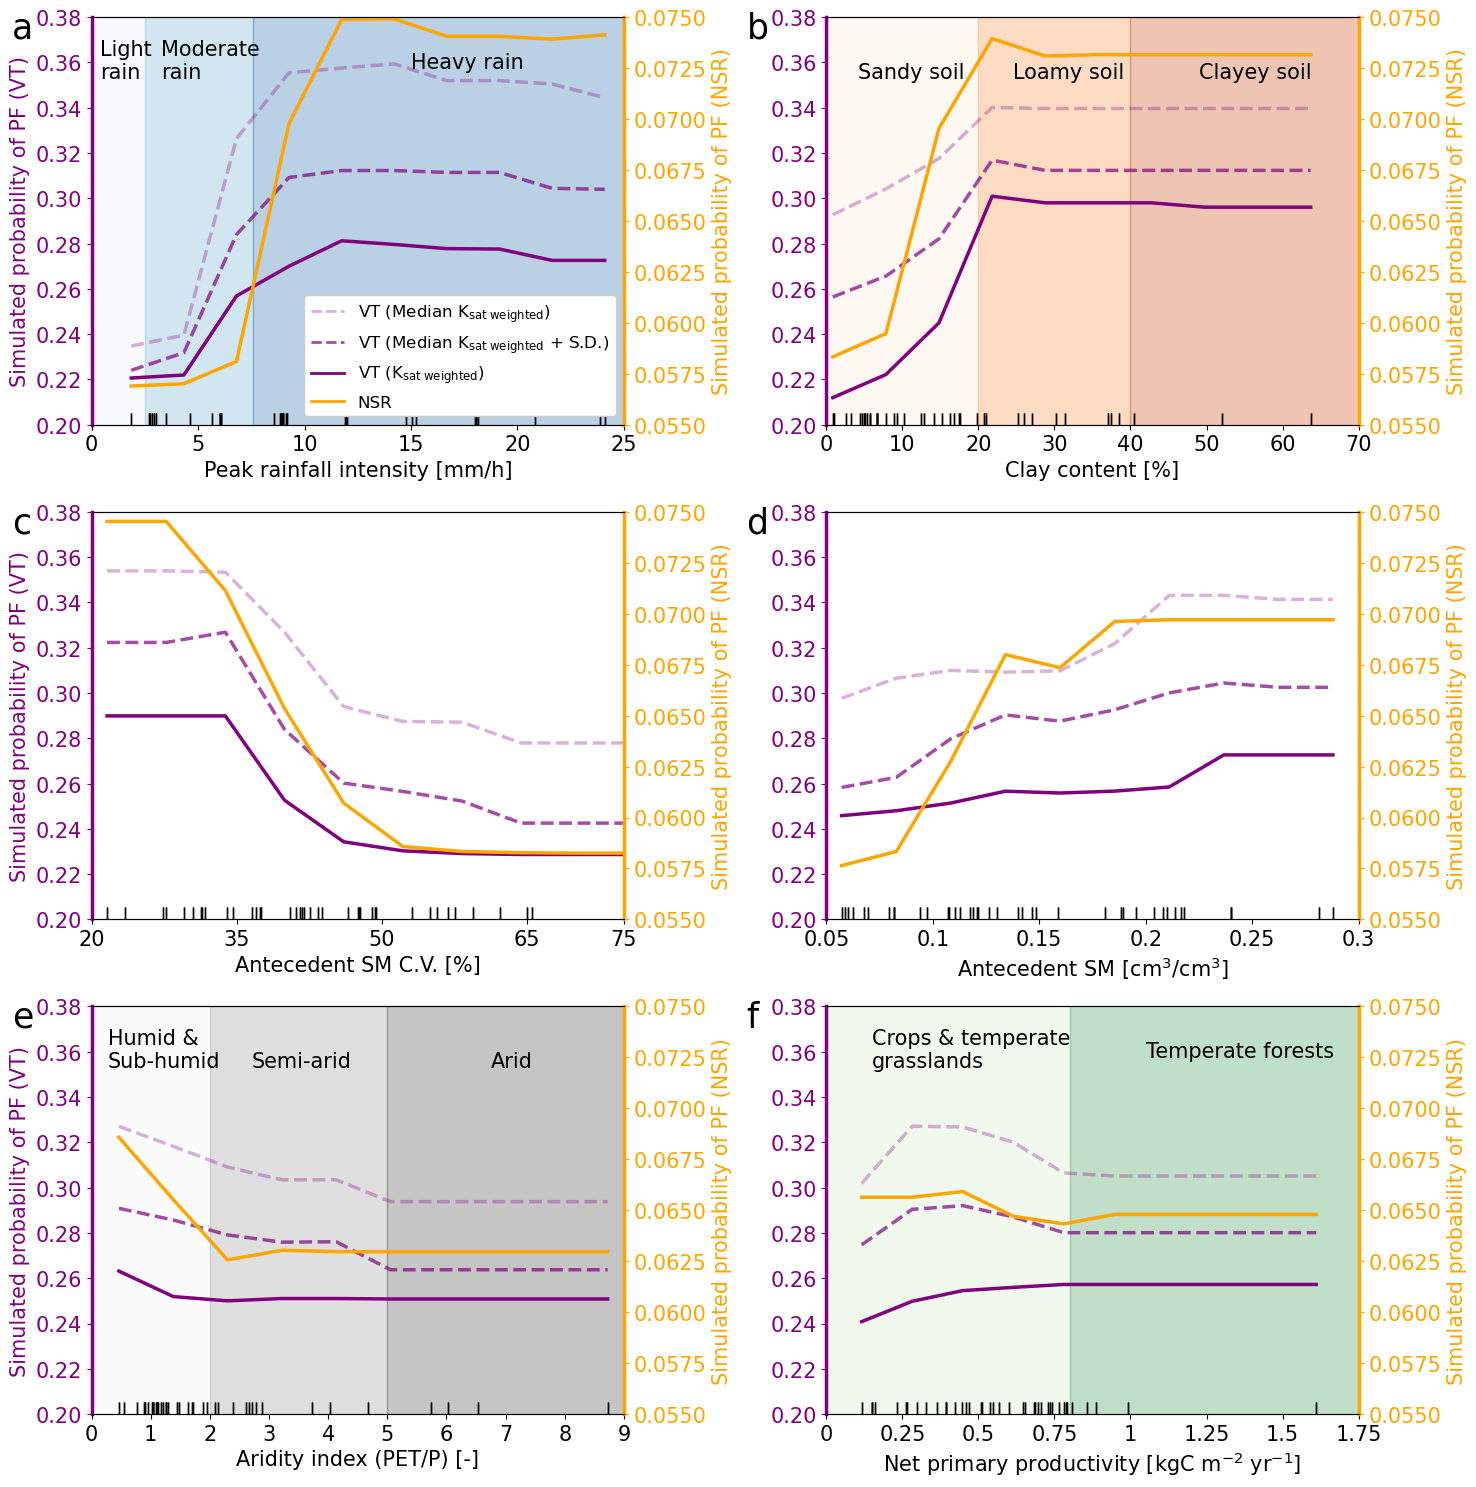

In [58]:
plot_pdp(
    pdp_vt_info = vt_model_hub_info,
    pdp_nsr_info = nsr_model_hub_info,
    features = ["site_storm_intensity", "clay","cv_sm","median_sm", "aridity", "NPP"],
    ylim=(0.055, 0.075),
    ylim_left = (0.20, 0.38)
)

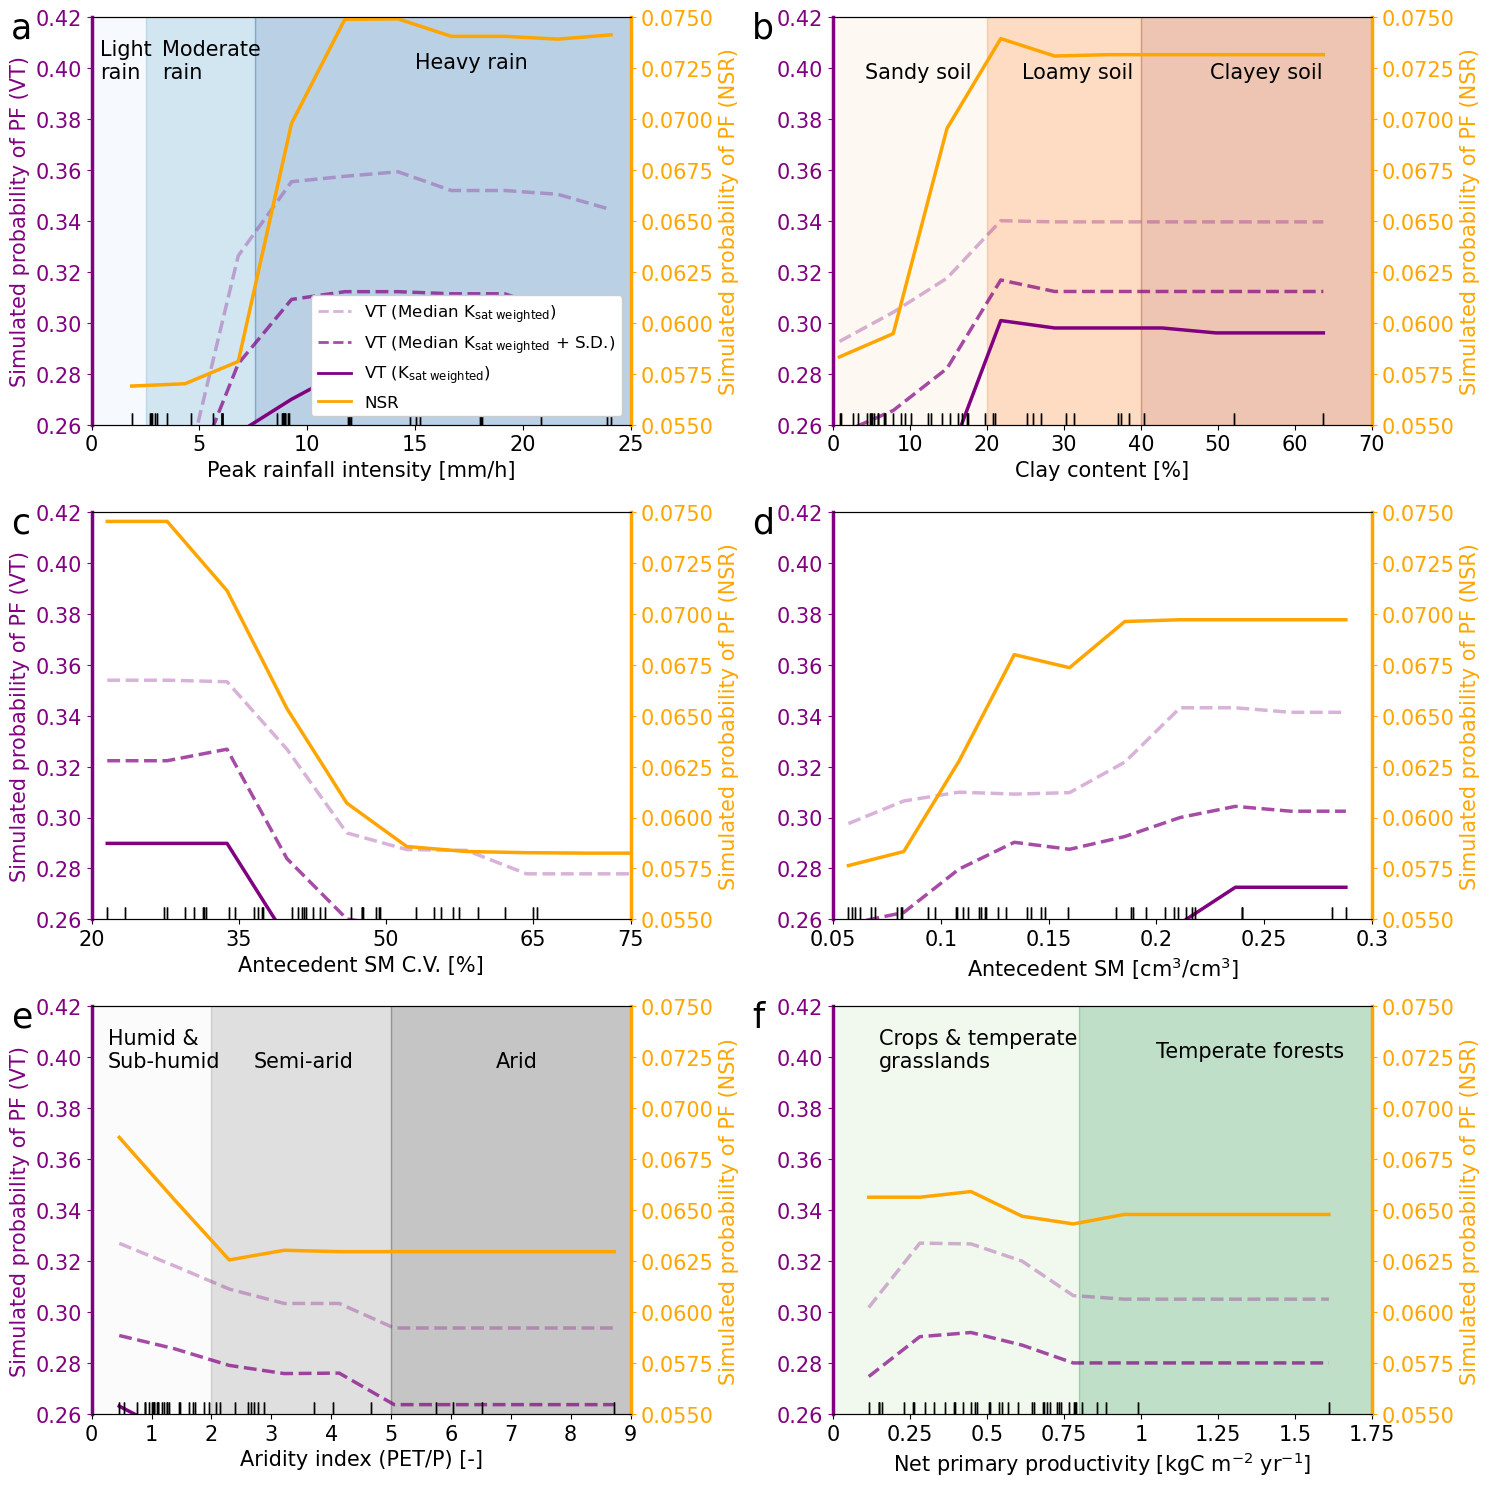

In [59]:
plot_pdp(
    pdp_vt_info = vt_model_hub_info,
    pdp_nsr_info = nsr_model_hub_info,
    features = ["site_storm_intensity", "clay","cv_sm","median_sm", "aridity", "NPP"],
    ylim=(0.055, 0.075),
    ylim_left = (0.26, 0.42)
)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 50, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
0.9347696875413264 0.49576479160616793 0.03823113496463261 0.13126536910484257
0.8815233839169936 0.25469177476311844 0.015248347414979388 0.05731057370090049
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_f

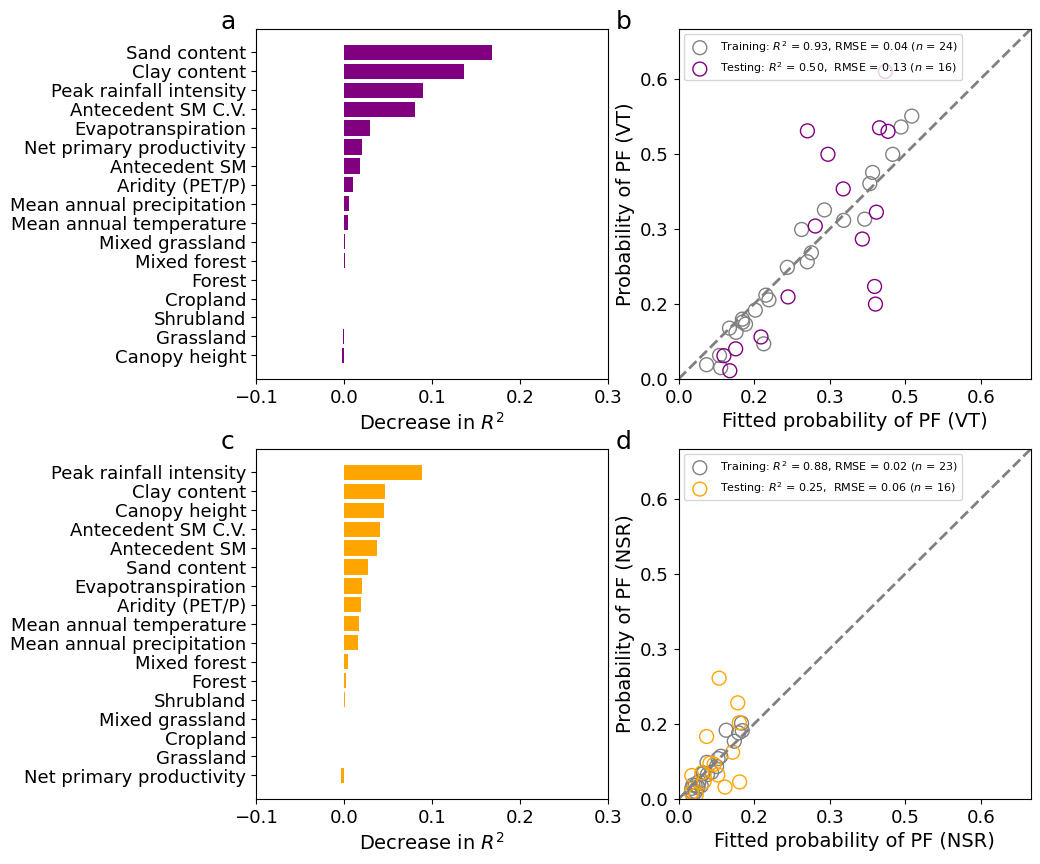

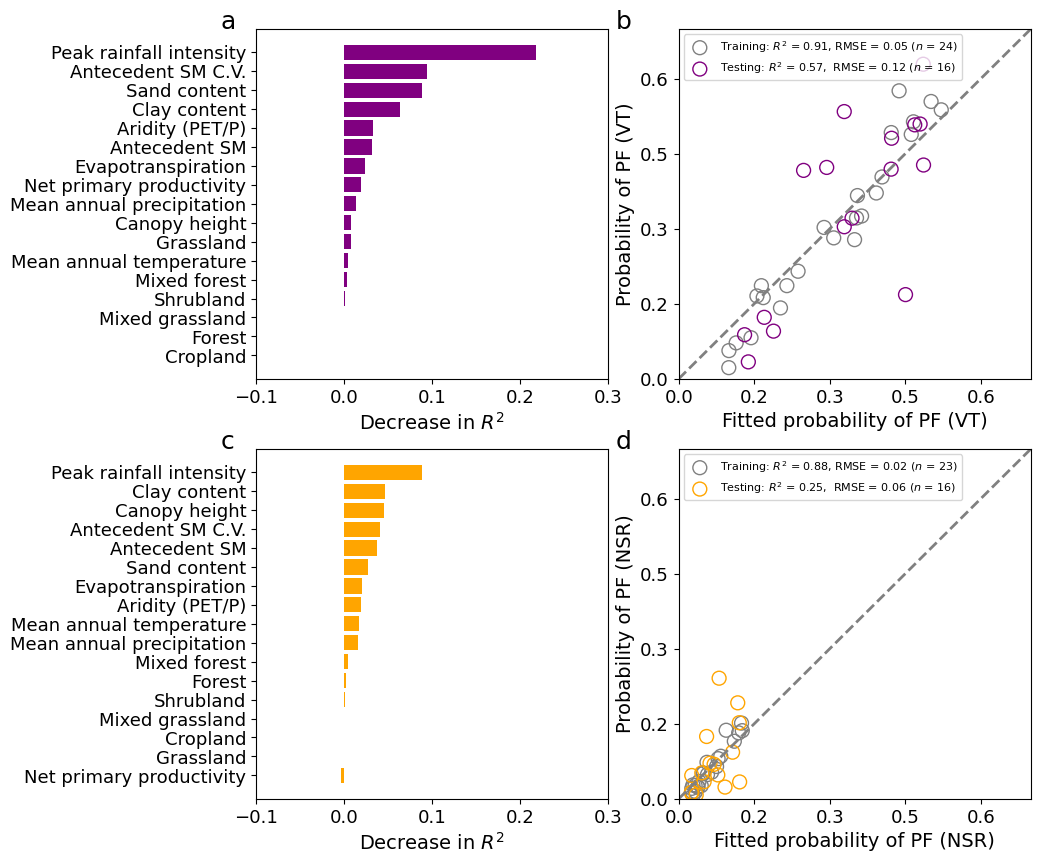

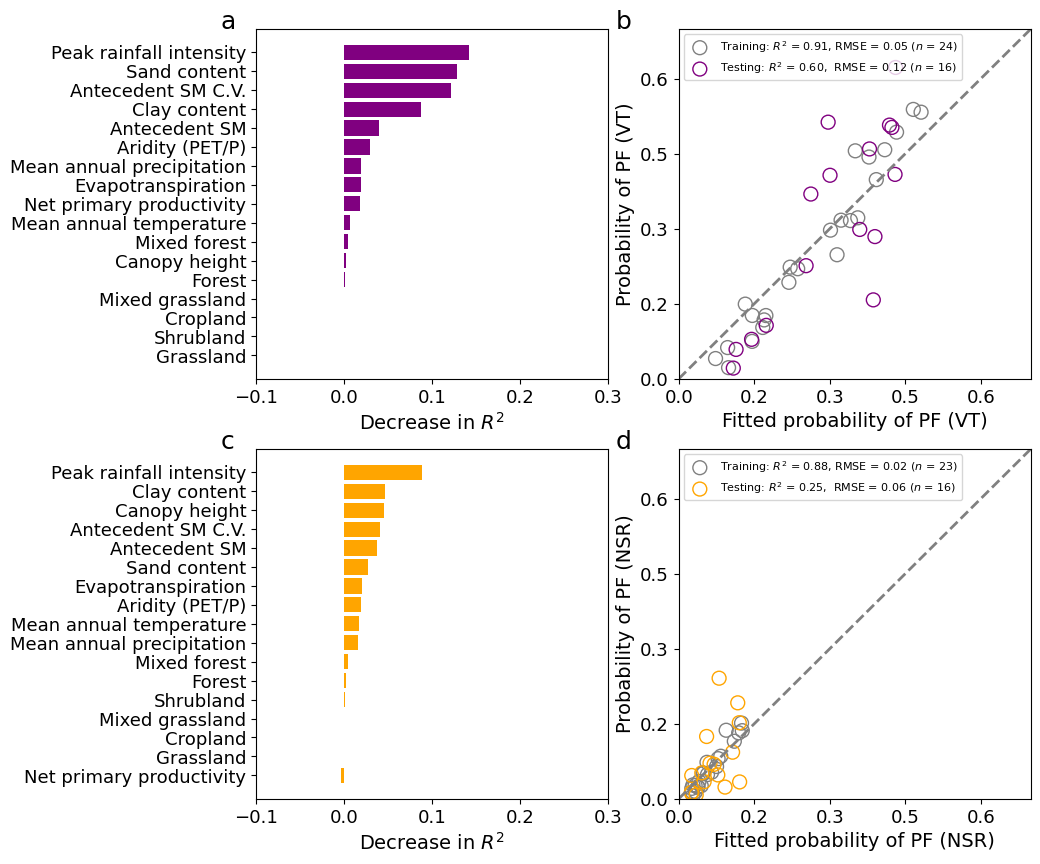

In [60]:
def generate_feature_importance(vt, nsr_model_hub_info, type):
    if type == vt["vt_type"]:
        plot_feature_importance("VT", "NSR", 
                                vt_info = {"X_test":vt["test_X"], "y_test":vt["y_test"], "model":vt["model"], "X_train":vt["train_X"], "y_train":vt["y_train"]},
                                nsr_info = {"X_test":nsr_model_hub_info["test_X"], "y_test":nsr_model_hub_info["y_test"], "model":nsr_model_hub_info["model"], "X_train":nsr_model_hub_info["train_X"], "y_train":nsr_model_hub_info["y_train"]},
                                total_if=True)
generate_feature_importance(vt_model_hub_info[0], nsr_model_hub_info, "")
generate_feature_importance(vt_model_hub_info[1], nsr_model_hub_info, "std_median_")
generate_feature_importance(vt_model_hub_info[2], nsr_model_hub_info, "std_upper_")

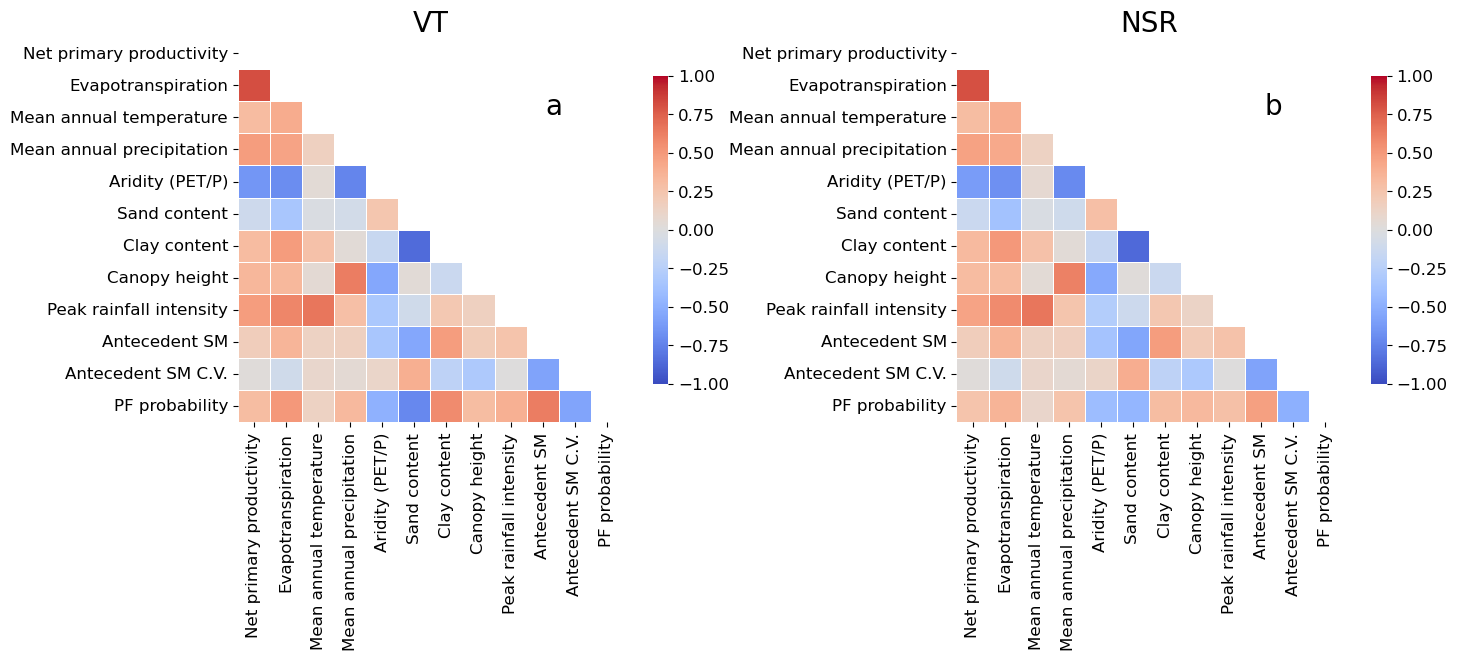

In [61]:
def generate_corr_matrx(vt, nsr_model_hub_info, type):
    if type == vt["vt_type"]:
        create_correlate(
                        {"X_test":vt["test_X"], "y_test":vt["y_test"], "model":vt["model"], "X_train":vt["train_X"], "y_train":vt["y_train"]},
                        {"X_test":nsr_model_hub_info["test_X"], "y_test":nsr_model_hub_info["y_test"], "model":nsr_model_hub_info["model"], "X_train":nsr_model_hub_info["train_X"], "y_train":nsr_model_hub_info["y_train"]},
                        title1="VT", title2="NSR"
                        )
        
generate_corr_matrx(vt_model_hub_info[0], nsr_model_hub_info, "")

{'SERC', 'UKFS', 'GRSM', 'ORNL', 'ABBY', 'KONZ', 'DELA', 'LAJA', 'OAES', 'MLBS', 'LENO', 'WREF', 'BART', 'SOAP'}
14
0.35
ksat        225.130004
velocity      8.093831
dtype: float64
0.9640481911231856


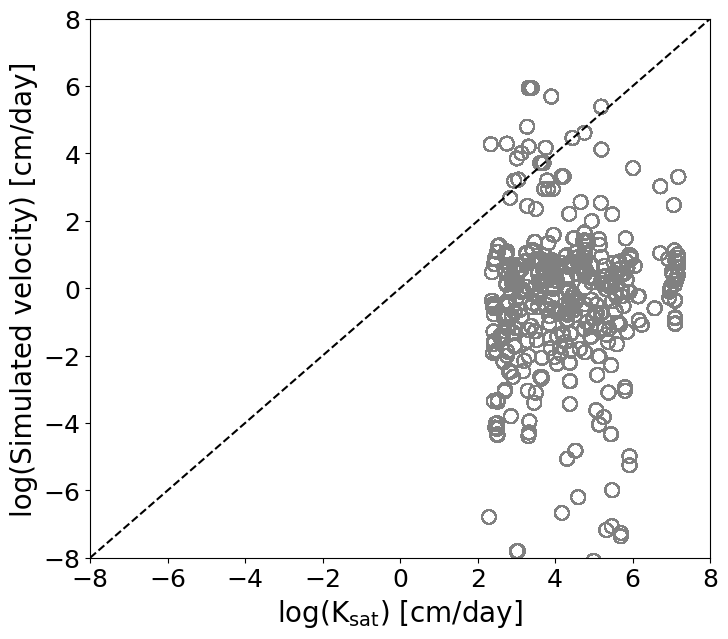

In [62]:
def plot_ksat_velocity(facecolor = "none", edgecolors = "grey", s = 100, alpha = 0.8):
    fig, ax = plt.subplots(figsize = (8,7))
    greater_sites = []
    cal_mean = []
    for i in FINAL_PF_RESULTS.keys():
        if (i not in EXCLUDED_SITE):
            for j in FINAL_PF_RESULTS[i]:
                sensors = [s.split("_")[-1] for s in j.columns if "sensor_depth_" in s]
                for k in sensors:
                    ax.scatter(j[f"ksat_{k}"], 
                            j[f"num_velocity_{k}_99th"],
                                facecolor = facecolor,
                                edgecolors=edgecolors,
                                s = s, 
                                alpha = alpha)
                    data = j[[f"ksat_{k}",f"num_velocity_{k}_99th"]].dropna()
                    cal_mean.append(np.exp(data.values))
                    if (data[f"ksat_{k}"] < data[f"num_velocity_{k}_99th"]).sum() > 1:
                        greater_sites.append(i)
    print(set(greater_sites))
    print(len(set(greater_sites)))
    print(len(set(greater_sites))/40)
    stats = pd.DataFrame(np.concatenate(cal_mean, axis=0), columns=["ksat", "velocity"]).dropna()
    print(stats.mean())
    print((stats["ksat"].mean() - stats["velocity"].mean())/stats["ksat"].mean())
    ax.plot([-8 , 8], [-8, 8], ls = "dashed", color= "black")
    ax.set_xlim(-8, 8)
    ax.set_ylim(-8, 8)
    ax.set_xlabel("log(K$\mathregular{_{sat}}$) [cm/day]", fontsize = 20)
    ax.set_ylabel("log(Simulated velocity) [cm/day]", fontsize = 20)
    ax.tick_params("both", labelsize = 18)
plot_ksat_velocity()
    

In [63]:
def compute_2d_pdp(model, X_df, features, grid_resolution=50):
    """
    Compute 2D partial dependence for two features in a DataFrame.
    Uses DataFrame column names directly for better readability.
    
    Parameters:
    -----------
    model : fitted estimator
    X_df : pd.DataFrame, training data
    features : tuple, (feature1_name, feature2_name)
    grid_resolution : int, number of grid points per feature
    
    Returns:
    --------
    pdp : np.ndarray, shape (grid_resolution, grid_resolution)
    grid_values : list of np.ndarray, grid points for each feature
    """
    feature1, feature2 = features
    
    # Generate grid values using column names directly
    feature1_values = np.linspace(X_df[feature1].min(), 
                                 X_df[feature1].max(), 
                                 grid_resolution)
    feature2_values = np.linspace(X_df[feature2].min(), 
                                 X_df[feature2].max(), 
                                 grid_resolution)
    
    # Initialize PDP array
    pdp = np.zeros((grid_resolution, grid_resolution))
    
    # Create a copy of the data to modify
    X_temp = X_df.copy()
    
    # Compute PDP using column names directly
    for i, val1 in enumerate(feature1_values):
        for j, val2 in enumerate(feature2_values):
            # Modify using column names
            X_temp[feature1] = val1
            X_temp[feature2] = val2
            preds = model.predict(X_temp)
            pdp[i, j] = np.mean(preds)
    
    return pdp, (feature1_values, feature2_values)

In [64]:
def plot_2d_pdp(ogdata, og_feature_names, pdp, grid_values, feature_names, 
                ax=None, cmap="viridis", 
                barTitle="Partial Dependence"):
    """
    Plot 2D PDP with styling similar to sklearn.
    
    Parameters:
    -----------
    ogdata : DataFrame, original data used for rugplot
    og_feature_names : tuple of str, names of the features in original data
    pdp : np.ndarray, computed PDP values
    grid_values : tuple of np.ndarray, grid points for each feature
    feature_names : tuple of str, names of the features
    ax : matplotlib Axes, optional
    cmap : str, colormap for the plot
    barTitle : str, title for the colorbar
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    # Create copies of the data to modify if needed
    modified_grid_values = list(grid_values)
    rug_data = ogdata.copy()
    # Check each feature for "peak rainfall intensity"

    for i, name in enumerate(feature_names):
        if "Peak rainfall intensity [mm/h]" in name:
            modified_grid_values[i] = grid_values[i] * 6

    for j, og_name in enumerate(og_feature_names):
        if "site_storm_intensity" in og_name:
            rug_data[og_name] = rug_data[og_name] * 6
    
    # Convert back to tuple
    modified_grid_values = tuple(modified_grid_values)
    
    # Plot filled contours
    contour = ax.contourf(
        modified_grid_values[0], 
        modified_grid_values[1], 
        pdp.T,  # Transpose to align grid correctly
        levels=20, 
        cmap=cmap,
    )
    
    # Plot rugplot with potentially modified data
    sns.rugplot(
        data=rug_data,
        ax=ax, 
        x=og_feature_names[0], 
        y=og_feature_names[1],
        height=0.03, 
        color='black'
    )
    
    # Add colorbar
    cbar = plt.colorbar(contour, ax=ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(barTitle, fontsize=14)
    
    # Set labels and title
    ax.set_xlabel(feature_names[0], fontsize=16)
    ax.set_ylabel(feature_names[1], fontsize=16)

    return ax

In [65]:
def draw_2d_pdp_comparison(data_list, models, features_list, cmap_list, 
                          bar_titles=None, show_rug=False,
                          figsize=(16, 6), panel_labels=('(a)', '(b)')):
    """
    Complete 2D PDP comparison plot with all original hard-coded elements
    and enhanced rug plot functionality.
    """
    # Preserved hard-coded feature name mapping
    index_mapping = {
        'landcover_Grassland': 'Grassland', 
        'landcover_Mixed Grassland': 'Mixed grassland',
        "landcover_Shrubland": "Shrubland", 
        "canopy": "Canopy height", 
        "landcover_Mixed Forest": "Mixed forest",
        "landcover_Cropland": "Cropland",
        "MAP": "Mean annual precipitation",
        "ET": "Evapotranspiration", 
        "MAT": "Mean annual temperature", 
        "aridity": "Aridity (PET/P)", 
        "sand": "Sand content",
        "landcover_Forest": "Forest", 
        "clay": "Clay content",
        "NPP": "Net primary productivity",
        "site_storm_intensity": "Peak rainfall intensity [mm/h]",
        "median_sm": "Antecedent SM [cm$^{3}$/cm$^{3}$]",
        "cv_sm": "Antecedent SM C.V. [%]"
    }
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    if bar_titles is None:
        bar_titles = [None] * len(models)
    
    for i, (data, model, features, cmap, bar_title) in enumerate(zip(data_list, models, features_list, cmap_list, bar_titles)):
        features_names = [index_mapping.get(f, f) for f in features]
        
        pdp, grid_values = compute_2d_pdp(model, data, features=features, grid_resolution=50)
    
        plot_2d_pdp(data,
                    features,
            pdp, grid_values, features_names,
            ax=axes[i], cmap=cmap, barTitle=bar_title, 
        )
        axes[i].text(0.1,0.9, f'{chr(97+i)}', transform=axes[i].transAxes, 
                    fontsize=22, c = "black")
        axes[i].tick_params("both", labelsize = 16)
    
    
    plt.tight_layout()
    plt.show()

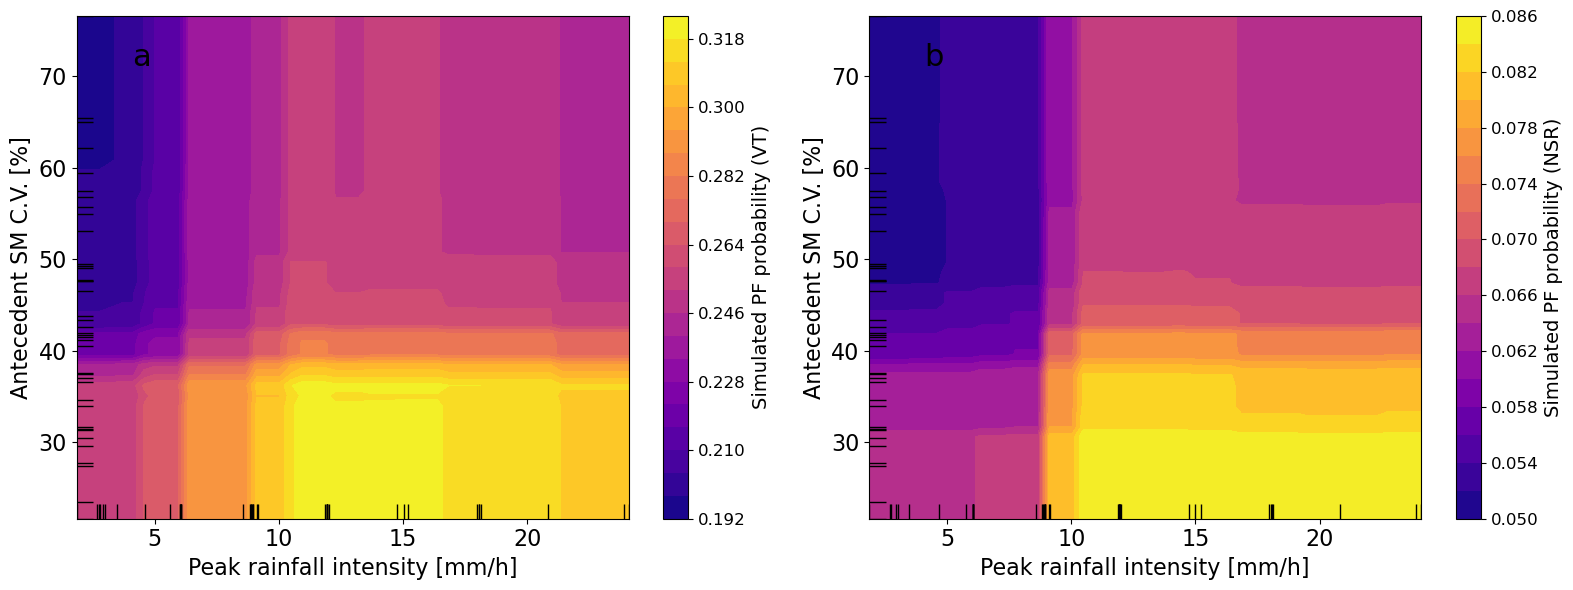

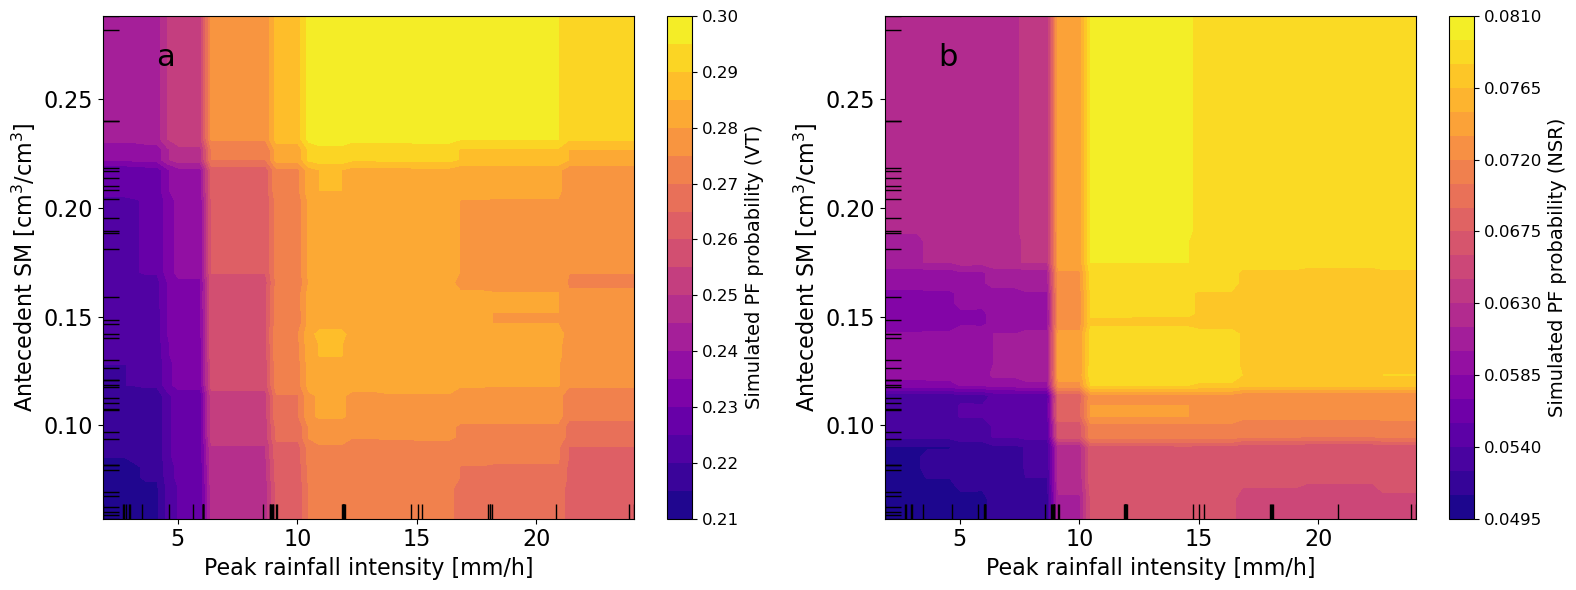

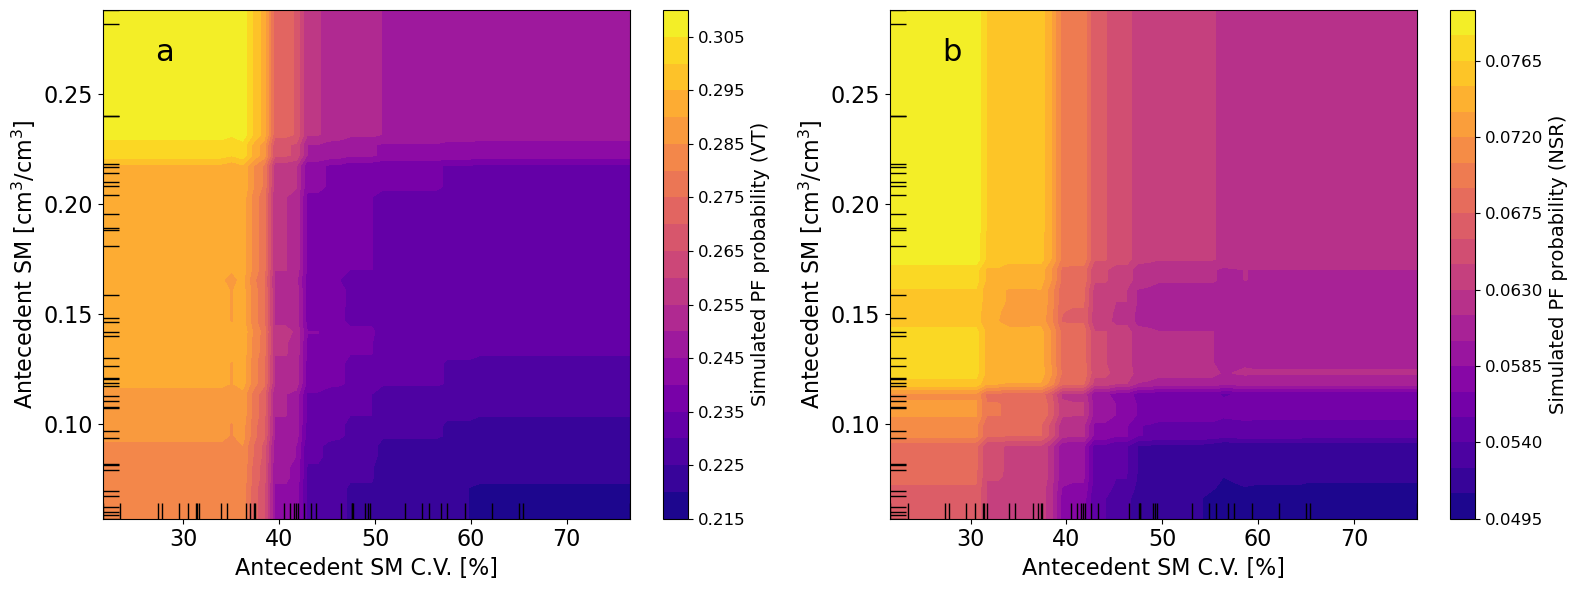

In [66]:
# Example usage with two different datasets and models:
def generate_2d_heat_maps(vt, nsr_model_hub_info, type):    
    for v in vt:
        if v["vt_type"] == type:
            data_list = [pd.concat([v["train_X"], v["test_X"]]), 
                         pd.concat([nsr_model_hub_info["train_X"], nsr_model_hub_info["test_X"]])
                         ]  # Your two different datasets
            models = [v["model"].best_estimator_, nsr_model_hub_info["model"].best_estimator_]   # Your two different models
            cmap_list = ['plasma', 'plasma']
# main_titles = [
#     'Model 1 on Dataset 1: Temperature vs Precipitation', 
#     'Model 2 on Dataset 2: Sand vs Clay Content'
# ]
    bar_titles = ['Simulated PF probability (VT)', 'Simulated PF probability (NSR)']
    features_list = [       
                    [("site_storm_intensity", "cv_sm"), ("site_storm_intensity", "cv_sm")],
                    [("site_storm_intensity", "median_sm"), ("site_storm_intensity", "median_sm")],
                    [("cv_sm", "median_sm",), ("cv_sm", "median_sm",)]
                    ]  # Feature pairs for each plot
    for k in features_list:
        draw_2d_pdp_comparison(
            data_list=data_list,
            models=models,
            features_list=k,
            cmap_list=cmap_list,
            bar_titles=bar_titles
        )
generate_2d_heat_maps(vt_model_hub_info, nsr_model_hub_info, "")

In [67]:
def get_ksat_velcolity_stats(metric, suffix):
   comparison_stats = []
   for j in FINAL_PF_RESULTS.keys():
      if j not in EXCLUDED_SITE:
         ksat_num = 0
         velocity_num = 0
         for l in FINAL_PF_RESULTS[j]:
            sensors = [s.split("_")[-1] for s in l.columns if "sensor_depth_" in s]
            for n in sensors:
               ksat_num = ksat_num + l[f"PF_{metric}_metric_{suffix}{n}"].sum()
               velocity_num = velocity_num + (l[f"velocity_computed_{n}"] >  l[f"num_velocity_{n}_99th"]).sum()
         comparison_stats.append([j, ksat_num, velocity_num, velocity_num/ksat_num - 1, velocity_num - ksat_num])
   return pd.DataFrame(comparison_stats, columns=["site", "ksat", "velocity", "ratio", "diff"])

In [68]:
get_data = get_ksat_velcolity_stats("ksat", "")

In [69]:
max_row = get_data.loc[get_data['ratio'].idxmax()]
min_row = get_data.loc[get_data['ratio'].idxmin()]
info_data = rainfall_by_ante_sm("velocity", "").groupby("site",as_index=False).agg({
                                                            "lat":"median",
                                                            "lon":"median", 
                                                            "num_event":"sum",
                                                            "NPP":"median",
                                                            "GPP":"median",
                                                            "ET":"median",
                                                            "MAT":"median",
                                                            "MAP":"median",
                                                            "aridity":"median",
                                                            "sand":"median",
                                                            "silt":"median",
                                                            "clay":"median",
                                                            "canopy":"median",
                                                            "site_storm_intensity":"median",
                                                            "median_sm":"median",
                                                            "cv_sm":"median",
                                                            "num_pf_v":"sum",
                                                            "landcover": lambda x: x.unique()[0]})
info_data["p_total"] = info_data[f"num_pf_v"]/info_data["num_event"]

all_data_oop = pd.merge(info_data,get_data)

In [70]:
def plot_clay_vs_pf(data, colorby=None, cmap = "plasma", color_dict=None, figsize=(8,6)):
    """
    Create scatter plot of clay content vs PF increase, with optional coloring.
    
    Parameters:
    -----------
    data : DataFrame
        Input data containing columns 'clay', 'ratio', and colorby variable
    colorby : str, optional
        Column name to use for coloring points. If None, uses black points.
    color_dict : dict, optional
        Dictionary mapping variable names to [label, unit] pairs.
        Example: {"p_total": ["PF Probability", ""],
                  "MAP": ["Mean Annual Precipitation", "mm"]}
    figsize : tuple, optional
        Figure size (width, height) in inches
    """
    plt.figure(figsize=figsize)
    
    # Default color settings if no variable specified
    if colorby is None:
        plt.scatter(data["clay"], data["ratio"], 
                    c="black", alpha=0.6, s=80)
    else:
        # Create scatter plot with coloring
        sc = plt.scatter(data["clay"], data["ratio"], 
                         c=data[colorby], 
                         cmap=cmap, alpha=0.8, s=80)
        
        # Add colorbar with proper labeling
        cbar = plt.colorbar(sc)
        
        # Set colorbar label using the dictionary if provided
        if color_dict and colorby in color_dict:
            label, unit = color_dict[colorby]
            if unit:
                cbar_label = f"{label} [{unit}]"
            else:
                cbar_label = label
            cbar.set_label(cbar_label, fontsize=14)
        else:
            # Fallback if no dictionary entry
            cbar.set_label(colorby, fontsize=14)
    
    # Axis labels and formatting
    plt.tick_params("both", labelsize=14)
    plt.xlabel("Clay content [%]", fontsize=16)
    plt.ylabel("Increase in PF [x 100%]", fontsize=16)
    
    # Add grid and adjust layout
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

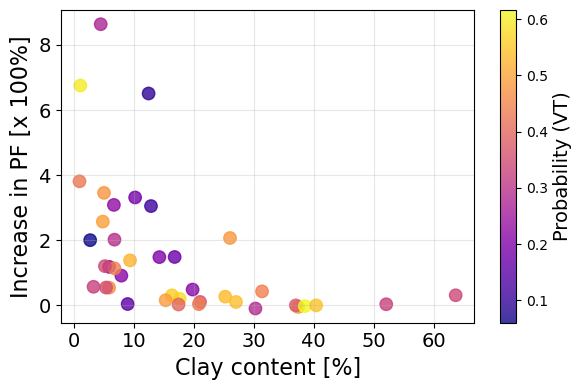

In [71]:
color_dict = {
    "p_total": ["Probability (VT)", ""],
    "NPP": ["Net Primary Productivity", "g C m⁻² yr⁻¹"],
    "GPP": ["Gross Primary Productivity", "g C m⁻² yr⁻¹"],
    "MAP": ["Mean annual precipitation", "mm"],
    "MAT": ["Mean annual temperature", "°C"],
    "aridity": ["Aridity", ""],
    "canopy": ["Canopy Cover", "%"]
}

# Create plot colored by p_total
plot_clay_vs_pf(all_data_oop, colorby="p_total", color_dict=color_dict, figsize=(6,4))
plt.show()

In [72]:
def process_row(row):
    # Your function that returns (list[a,b,c], np.array)
    result = ksat_weight_selection_method(
        site=row['siteID'],
        sensor_depth=np.abs(row['sensorDepth']) * 100,
        discard_out_of_scope=True,
        log_it=True,
        selection_method="max",
        return_all_weighted=True,
        return_med_weighted_std=False,
    )
    # Ensure consistent output format
    if result is None:
        return [np.nan, np.nan, np.nan], np.array([])  # Empty array for candidates
    return result

# Apply function and get results
displot_data_threshold = SENSOR_DEPTH[
    (~SENSOR_DEPTH["siteID"].isin(EXCLUDED_SITE)) & 
    (~SENSOR_DEPTH["sensorDepth"].isna())
].copy()
results = displot_data_threshold.apply(process_row, axis=1)

# Unpack into DataFrame columns
displot_data_threshold[["ksat", "ksat_median", "ksat_upper"]] = results.apply(lambda x: x[0]).tolist()
displot_data_threshold["candidates"] = results.apply(lambda x: x[1])

# Flatten all candidate arrays (handling empty arrays)
all_candidates = np.concatenate(
    displot_data_threshold["candidates"][
        displot_data_threshold["candidates"].apply(len) > 0
    ].values
)

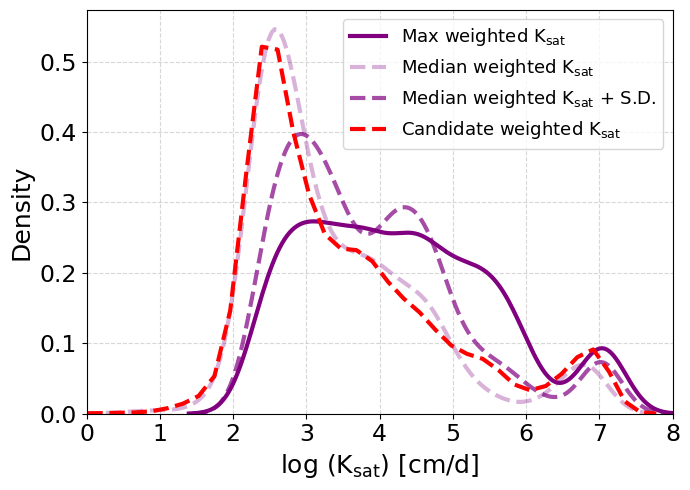

177.67552554480233 105.89621982841977
Ksat is 40.39909576532128 greater of Ksat candidate. 


In [73]:
# 1. Flatten the 'candidates' column (handle NaNs/empty lists
all_candidates = all_candidates[~np.isnan(all_candidates)]
# 2. Set up the figure and axis
fig_si_x, ax_si_x = plt.subplots(figsize=(7, 5))
# 3. Plot KDEs on the same axis
sns.kdeplot(
    data=displot_data_threshold["ksat"].dropna(),
    label="Max weighted K$\mathregular{_{sat}}$",
    color="purple",
    linewidth=3,
    ax=ax_si_x  # Attach to the axis
)

sns.kdeplot(
    data=displot_data_threshold["ksat_median"].dropna(),
    label="Median weighted K$\mathregular{_{sat}}$",
    color="purple",
    linewidth=3,
    alpha = 0.3,
    ls = "dashed",
    ax=ax_si_x  # Attach to the axis
)

sns.kdeplot(
    data=displot_data_threshold["ksat_upper"].dropna(),
    label="Median weighted K$\mathregular{_{sat}}$ + S.D.",
    color="purple",
    linewidth=3,
    alpha = 0.7,
    ls = "dashed",
    ax=ax_si_x  # Attach to the axis
)

sns.kdeplot(
    data=all_candidates,
    label="Candidate weighted K$\mathregular{_{sat}}$",
    color="red",
    linewidth=3,
    linestyle="--",
    ax=ax_si_x  # Same axis
)

# 4. Customize the axis (not plt)
ax_si_x.set_xlabel("log (K$\mathregular{_{sat}}$) [cm/d]", fontsize=18)
ax_si_x.set_ylabel("Density", fontsize=18)
ax_si_x.legend(fontsize = 13)
ax_si_x.set_xlim(0,8)
ax_si_x.grid(True, linestyle='--', alpha=0.5)
ax_si_x.tick_params("both", labelsize = 17)
plt.tight_layout()
plt.show()

mean_ksat = np.nanmean(np.exp(displot_data_threshold["ksat"].dropna()))
mean_candidate = np.nanmean(np.exp(all_candidates))
print(mean_ksat, mean_candidate)
print(f"Ksat is {((mean_ksat - mean_candidate)/mean_ksat) * 100} greater of Ksat candidate. " )

In [103]:
def venn_dataset():
    all_data = []
    for site in FINAL_PF_RESULTS:
        if site not in EXCLUDED_SITE:
            for plot in FINAL_PF_RESULTS[site]:
                plot = plot.copy()
                cal_v_cols = [j for j in plot.columns if j.split("_")[0] == "velocity"]
                # if any is true then true other wise false
                v_reponse = [f"smResponseType_50{j}" for j in np.arange(1,len(cal_v_cols) + 1)]  
                v_model = [f"PF_ksat_metric_50{j}" for j in np.arange(1,len(cal_v_cols) + 1)] 
                v_median = [f"PF_ksat_metric_std_median_50{s_id}" for s_id in np.arange(1,len(cal_v_cols) + 1)]
                v_medin_plus_sdt = [f"PF_ksat_metric_std_upper_50{s_id}" for s_id in np.arange(1, len(cal_v_cols) + 1)]
                v_num_sim = [f"PF_velocity_metric_50{s_id}" for s_id in np.arange(1, len(cal_v_cols) + 1)]

                plot[["is_event", "max_ksat"]] = plot.apply(parse_is_event_and_pf, args=(v_reponse, v_model,), axis = 1, result_type="expand")
                plot[["is_event_ksat","median_ksat"]] = plot.apply(parse_is_event_and_pf, args=(v_reponse, v_median,), axis = 1, result_type="expand")
                plot[["is_event_ksat_std_upper","std_upper_ksat"]] = plot.apply(parse_is_event_and_pf, args=(v_reponse, v_medin_plus_sdt,), axis = 1, result_type="expand")
                plot[["is_event_velocity","velocity"]] = plot.apply(parse_is_event_and_pf, args=(v_reponse, v_num_sim,), axis = 1, result_type="expand")
                possible_events = plot.loc[plot["is_event"], ["max_ksat", "median_ksat", "std_upper_ksat", "velocity", "flowTypes"]].copy() # all possible events
                num_pf_ksat = possible_events["max_ksat"].sum()
                num_pf_ksat_std_upper = possible_events["std_upper_ksat"].sum()
                num_pf_velocity = possible_events["velocity"].sum()
                num_pf_ksat_median = possible_events["median_ksat"].sum()
                num_pf_nsr = possible_events[possible_events["flowTypes"] == "nonSequentialFlow"].shape[0]
                #when both occurs 
                max_nsr = possible_events[(possible_events["flowTypes"] == "nonSequentialFlow") & (possible_events["max_ksat"])].shape[0]
                median_nsr = possible_events[(possible_events["flowTypes"] == "nonSequentialFlow") & (possible_events["median_ksat"])].shape[0]
                std_upper_nsr = possible_events[(possible_events["flowTypes"] == "nonSequentialFlow") & (possible_events["std_upper_ksat"])].shape[0]
                velocity_nsr = possible_events[(possible_events["flowTypes"] == "nonSequentialFlow") & (possible_events["velocity"])].shape[0]
                all_data.append([site, possible_events.shape[0], num_pf_ksat, num_pf_ksat_std_upper, num_pf_velocity, num_pf_ksat_median, num_pf_nsr, max_nsr, median_nsr, std_upper_nsr, velocity_nsr])
    return pd.DataFrame(all_data, columns=["site", "Total", "PF_ksat", "PF_ksat_std_upper", "PF_velocity", "PF_ksat_median", "PF_nsr", "PF_ksat_nsr", "PF_median_nsr", "PF_std_upper_nsr", "PF_velocity_nsr"])

stats = venn_dataset()

In [104]:
(stats.iloc[:,1:].sum(axis = 0)/stats.iloc[:,1:].sum(axis = 0)[0])*100

Total                100.000000
PF_ksat               26.421461
PF_ksat_std_upper     29.512732
PF_velocity           38.032065
PF_ksat_median        32.662685
PF_nsr                 6.568165
PF_ksat_nsr            5.308603
PF_median_nsr          5.830452
PF_std_upper_nsr       5.622970
PF_velocity_nsr        6.352300
dtype: float64

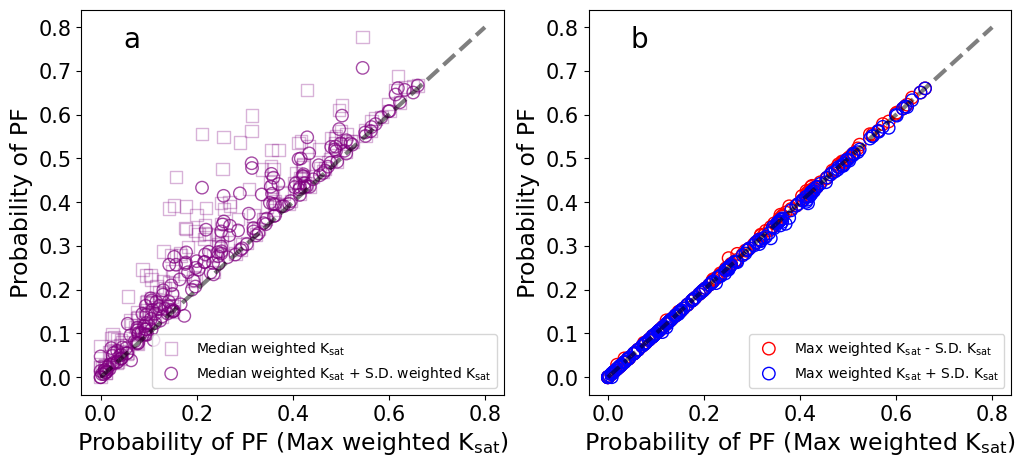

In [76]:
def plot_thresholds(x, y1, y2, y3, y4):
    fig, ax = plt.subplots(1, 2, figsize= (12, 5))
    ax[0].scatter(x["p_pf_v"], y1[0]["p_pf_v"], label = y1[1], facecolor = "None", edgecolor = "purple", s= 80,
                  alpha = 0.3, marker = "s"
                  )
    ax[0].scatter(x["p_pf_v"], y2[0]["p_pf_v"], label = y2[1], facecolor = "None", edgecolor = "purple", s= 80,
                  alpha = 0.7) 
    ax[0].plot([0, 0.8], [0, 0.8], ls = "dashed", lw = 3, alpha = 0.5, c = "black") 
    ax[0].legend(loc = "lower right")
    ax[1].scatter(x["p_pf_v"], y3[0]["p_pf_v"], label = y3[1], facecolor = "None", edgecolor = "red", s= 80)
    ax[1].scatter(x["p_pf_v"], y4[0]["p_pf_v"], label = y4[1], facecolor = "None", edgecolor = "blue", s= 80) 
    ax[1].plot([0, 0.8], [0, 0.8], ls = "dashed", lw = 3, alpha = 0.5, c = "black") 
    ax[1].legend(loc = "lower right")
    ax[0].tick_params("both", labelsize =15)
    ax[1].tick_params("both", labelsize =15)
    ax[0].set_xlabel("Probability of PF (Max weighted K$\mathregular{_{sat}}$)", fontsize= 17)
    ax[1].set_xlabel("Probability of PF (Max weighted K$\mathregular{_{sat}}$)", fontsize= 17)
    ax[0].set_ylabel("Probability of PF", fontsize= 17)
    ax[1].set_ylabel("Probability of PF", fontsize= 17)
    ax[0].text(0.1, 0.9, "a", transform=ax[0].transAxes, fontsize = 20)
    ax[1].text(0.1, 0.9, "b", transform=ax[1].transAxes, fontsize = 20)
plot_thresholds(VELOCITY_PLOT_PROBS,
                [VELOCITY_PLOT_PROBS_LOW, r"Median weighted K$\mathregular{_{sat}}$"],
                [VELOCITY_PLOT_PROBS_HIGH, r"Median weighted K$\mathregular{_{sat}}$ + S.D. weighted K$\mathregular{_{sat}}$"], 
                [VELOCITY_PLOT_PROBS_LOW_MAX, r"Max weighted K$\mathregular{_{sat}}$ - S.D. K$\mathregular{_{sat}}$"], 
                [VELOCITY_PLOT_PROBS_HIGH_MAX, r"Max weighted K$\mathregular{_{sat}}$ + S.D. K$\mathregular{_{sat}}$"])

### Historical functions below are deprecated! 

In [77]:
# def get_nsr_bin(bin_by, bin_num = 20):
#     """calculate probability of PF by binning.

#     Args:
#         bin_by (str): "stormPeakIntensity" or "surface_sm"
#         bin_num (int, optional): number of bins. Defaults to 20.

#     Returns:
#         pd.DataFrame: regression slopes.
#     """
#     if bin_by == "surface_sm":
#         final_name = "sm"
#         extracted = "stormPeakIntensity"
#         name = "peak_intensity"
#     if bin_by == "stormPeakIntensity":
#         final_name = "peak_intensity"
#         extracted = "surface_sm"
#         name = "soil_moisture"
#     nsr_info_slope = []
#     overall = {}
#     for nsr_site in GAP_FILLED_SM.keys(): 
#         site_nsr =  GAP_FILLED_SM[nsr_site]
#         site_specific = []
#         if len(site_nsr) > 0 and nsr_site not in EXCLUDED_SITE:
#             for i in site_nsr:  
#                 plot_data = i.copy()
#                 if not plot_data.empty:
#                     expand_texture = ["surface_sand", "surface_silt", "surface_clay", "surface_porosity",
#                                       "surface_eff_porosity", "surface_root_density"]
#                     plot_data[expand_texture] = plot_data.apply(depth_weight_soil_param, axis = 1, result_type="expand")
#                     surface_soil_texture = plot_data[expand_texture].median()
#                     get_h_pos = [i for i in plot_data.columns if "nake" in i]
#                     unique_h_pos = plot_data[get_h_pos[0]].unique()[0].split("_")[0]
#                     plot_data["surface_sm"]= plot_data.apply(get_depth_wegithed, args=(nsr_site, ), result_type= "expand", axis = 1)
#                     plot_data["month"] = plot_data["stormStartTime"].dt.month
#                     plot_data["season"] = plot_data["month"].apply(lambda x: "dry" if 4 <= x <= 9 else "wet")
#                     # do the binning, performance regression, keep the onse with surface sm 
#                     plot_data = plot_data[plot_data["surface_sm"].notnull()].copy()
#                     # not we are on pedon scale. 
#                     global_min = plot_data[bin_by].min()
#                     global_max = plot_data[bin_by].max()
#                     regress_data = []
#                     _, bin_edges = np.histogram(plot_data[bin_by], bins=bin_num, range= (global_min, global_max))
#                     bin_intervals =  [[bin_edges[bi], bin_edges[bi + 1]] for bi in np.arange(len(bin_edges)-1)]
#                     for it in np.arange(len(bin_intervals)):
#                         lower_bound = bin_intervals[it][0]
#                         upper_bound = bin_intervals[it][1]
#                         mid_point = (upper_bound + lower_bound)/2
#                         conditions =  (lower_bound <= plot_data[bin_by]) & (plot_data[bin_by] < upper_bound)
#                         if it == len(bin_intervals):
#                             conditions =  (lower_bound <= plot_data[bin_by]) & (plot_data[bin_by] <= upper_bound)
#                         bin_specific = plot_data.loc[conditions, :].copy()
#                         num_pf = bin_specific.loc[bin_specific["flowTypes"] == 'nonSequentialFlow', :].shape[0]
#                         # dry season PF
#                         dry_PF = bin_specific.loc[(bin_specific["flowTypes"] =='nonSequentialFlow') &
#                                                       (bin_specific["season"] == "dry"), :]
#                         # wet season PF
#                         wet_PF = bin_specific.loc[(bin_specific["flowTypes"] =='nonSequentialFlow') &
#                                                       (bin_specific["season"] == "wet"), :]
#                         # dry season total events
#                         dry_total =  bin_specific[bin_specific["season"] == "dry"]
#                         # wet season total events 
#                         wet_total = bin_specific[bin_specific["season"] == "wet"]
#                         if num_pf > 0:
#                             percent  = num_pf/bin_specific.shape[0]
#                             # total PF
#                             x_axis_PF = bin_specific.loc[bin_specific["flowTypes"] == 'nonSequentialFlow',
#                                                                 bin_by]
#                             x_dry = dry_PF[bin_by]
#                             x_wet = wet_PF[bin_by]
#                             regress_data.append([nsr_site, percent, x_axis_PF.median(), 
#                                                  x_dry.median(), x_wet.median(), 
#                                                  x_dry.shape[0], x_wet.shape[0],
#                                                  dry_total.shape[0], wet_total.shape[0],
#                                                  lower_bound, upper_bound, mid_point,
#                                                  x_axis_PF, bin_specific[bin_by].tolist(),
#                                                  bin_specific.loc[bin_specific["flowTypes"] == 'nonSequentialFlow',extracted].median(),
#                                                  x_dry, dry_total[bin_by],    
#                                                  dry_PF[extracted].median(),
#                                                  x_wet, wet_total[bin_by],
#                                                  wet_PF[extracted].median()
#                                                  ] + surface_soil_texture.tolist())
#                    # now do regression 
#                     if len(regress_data) >= 5:
#                         rg_data = pd.DataFrame(regress_data, columns= ["site","percent", bin_by, f"{bin_by}_dry", f"{bin_by}_wet",
#                                                                        "dry_num_pf", "wet_num_pf", "dry_total", "wet_total",
#                                                                         "lower_bound", "upper_bound", "mid_point",
#                                                                         f"{bin_by}_{final_name}", f"{bin_by}_{final_name}_npf",extracted,
#                                                                         f"{bin_by}_{final_name}_dry", f"{bin_by}_{final_name}_npf_dry", f"{extracted}_dry",
#                                                                         f"{bin_by}_{final_name}_wet", f"{bin_by}_{final_name}_npf_wet", f"{extracted}_wet",
#                                                                        ] + surface_soil_texture.index.tolist())
#                         rg_data["percent_dry"] = rg_data["dry_num_pf"]/rg_data["dry_total"]
#                         rg_data["percent_wet"] = rg_data["wet_num_pf"]/rg_data["wet_total"]
#                         max_p_total = rg_data.loc[rg_data["percent"].idxmax(), [extracted, "percent"]].tolist()
#                         max_id_dry = rg_data["percent_dry"].idxmax()
#                         max_id_wet = rg_data["percent_wet"].idxmax()
#                         max_p_dry = [np.nan] * 2
#                         max_p_wet = [np.nan] * 2
#                         if pd.notna(max_id_dry): 
#                             max_p_dry = rg_data.loc[max_id_dry, [f"{extracted}_dry", "percent_dry"]].tolist()
#                         if pd.notna(max_id_wet):
#                             max_p_wet = rg_data.loc[max_id_wet, [ f"{extracted}_wet", "percent_wet"]].tolist()
#                         rg_data["log_p"] = np.log(rg_data["percent"])
#                         rg_data["log_p_dry"] = np.log(rg_data["percent_dry"])
#                         rg_data["log_p_wet"] = np.log(rg_data["percent_wet"])
#                         # model fitting y = e^(ax + b) -> log(y) ~ ax + b  
#                         # transform 
#                         rg_data_total = rg_data.dropna(subset=["log_p", bin_by]).copy()
#                         exp_modl = smf.ols(formula=f"log_p ~ {bin_by}", data=rg_data_total)
#                         res_exp = exp_modl.fit()
#                         exp_modl_info = [res_exp.params[bin_by], res_exp.pvalues[bin_by], res_exp.rsquared, 
#                                          r2_score(rg_data_total["percent"], res_exp.fittedvalues)]
#                         dry_hub = rg_data.dropna(subset=["log_p_dry", f"{bin_by}_dry"]).copy()  
#                         wet_hub  =rg_data.dropna(subset=["log_p_wet", f"{bin_by}_wet"]).copy()

#                         dry_hub_info = [np.nan] * 4
#                         wet_hub_info = [np.nan] * 4
#                         if dry_hub.shape[0] >= 3:
#                             exp_modl_dry = smf.ols(formula=f"log_p_dry ~ {bin_by}_dry", data=dry_hub)
#                             res_exp_dry = exp_modl_dry.fit()
#                             dry_hub_info = [res_exp_dry.params[f"{bin_by}_dry"], res_exp_dry.pvalues[f"{bin_by}_dry"], 
#                                             res_exp_dry.rsquared, r2_score(dry_hub["percent_dry"], np.exp(res_exp_dry.fittedvalues))]
#                         if wet_hub.shape[0] >= 3:
#                             exp_modl_wet = smf.ols(formula=f"log_p_wet ~ {bin_by}_wet", data=wet_hub)
#                             res_exp_wet = exp_modl_wet.fit()
#                             wet_hub_info = [res_exp_wet.params[f"{bin_by}_wet"], res_exp_wet.pvalues[f"{bin_by}_wet"],
#                                             res_exp_wet.rsquared, r2_score(wet_hub["percent_wet"], np.exp(res_exp_wet.fittedvalues)) ]

#                         non_reg_info = [
#                                         get_aridity(nsr_site), get_site_condition(nsr_site, "MAT"), 
#                                         get_site_condition(nsr_site, "MAP"), nsr_site
#                                         ] 
#                         over_all_nsr = exp_modl_info + dry_hub_info + wet_hub_info + non_reg_info + surface_soil_texture.tolist() + max_p_total + max_p_dry + max_p_wet
#                         nsr_info_slope.append(over_all_nsr)
                    
#     nsr_info_slope = pd.DataFrame(nsr_info_slope,
#                                 columns = [
#                                             "slope_exp_total", "p_exp_total", "R2_exp_total","R2_exp_norm_total", 
#                                             "slope_exp_dry", "p_exp_dry", "R2_exp_dry","R2_exp_norm_dry", 
#                                             "slope_exp_wet", "p_exp_wet", "R2_exp_wet","R2_exp_norm_wet", 
#                                             "aridity", "MAT", "MAP", "site",
#                                             "sand", "silt","clay", "porosity", "eff_porosity","root_density", f"{name}_total"
#                                             , "max_p_total",f"{name}_dry"
#                                             , "max_p_dry",f"{name}_wet"
#                                             , "max_p_wet"])
#     return nsr_info_slope, overall
# slope_nsr,_ = get_nsr_bin("surface_sm")

In [78]:
# def nature_geo_sup3(data, type):
#     fig, ax = plt.subplots(1,3, figsize = (14, 4))
#     labels = ["Aridity", "Mean annual temperature (°C)", "Mean annual precipitation (mm)"]
#     cols = ["aridity", 'MAT', "MAP"]
#     fig_num = ["a", "b", "c"]
#     data1 = data.loc[data["p_exp_total"] < 0.05, ["slope_exp_total"] + cols].copy()
#     data_wet = data.loc[data["p_exp_wet"] < 0.05, ["slope_exp_wet"] + cols].copy()
#     data_dry = data.loc[data["p_exp_dry"] < 0.05,["slope_exp_wet"] + cols].copy()
#     datahub = [data1, data_wet, data_dry]
#     c = "red"
#     if type == "NSR":
#         c = "green"
#     for i in np.arange(len(labels)):
#         color = ["purple", "orange", "green"]
#         label = ["All", "Growing", "Non growing"]
#         for s in np.arange(len(datahub)):
#             yaxes_label = [i for i in datahub[s].columns if "slope_exp_" in i]
#             ax[i].scatter(datahub[s][cols[i]],datahub[s][yaxes_label], s = 100, c = color[s],
#                         label = f"{label[s]} $p$ < 0.05", alpha = 0.5)
            
#             ax[i].tick_params("both", labelsize =12)
#             ax[i].set_xlabel(labels[i],fontsize= 14)
#             ax[i].tick_params("both", labelsize =12)
#             ax[i].text(0.8, 0.2, fig_num[i], transform = ax[i].transAxes, fontsize = 20)
#             ax[i].axhline(y = 0, color = "black", ls = "--", lw = 4)
#             ax[i].legend(fontsize= 12, loc= "upper right")
#             if i == 0:
#                 ax[i].set_ylabel(f"Slope ({type}) [-]",fontsize= 14)
# nature_geo_sup3(details, "NSR")
# nature_geo_sup3(slopes_v, "VT")


In [79]:
# def visulize_bin_v(site, data):
#     fig, ax = plt.subplots(2, 3, figsize = (16,10))
#     data_v = data[site]
#     colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#e377c2", 
#               "#7f7f7f", "#bcbd22", "#17becf"]
#     num = ["a", "b", "c", "d", "e", "f", "g", "h"]
#     keys = sorted([i for i in data_v.keys()])
#     for i in np.arange(len(keys)):
#         row = i//3
#         col = i%3
#         print(row,col)
#         cur_data = data_v[keys[i]]
#         # at sensor level
#         keys2 =sorted([i for i in cur_data.keys()])
#         for k in np.arange(len(keys2)):
#             sensor_info = cur_data[keys2[k]]
#             data_info = sensor_info["data"]
           
#             slope, intercept, p, depth = sensor_info["exp_info"]
#             data_range = np.linspace(data_info["lower_bound"].min(),data_info["upper_bound"].max(), 100)
#             exploted =  data_info.explode('soil_moisture')
#             predict_p = np.exp(slope*data_range + intercept)
#             ax[row,col].scatter(exploted["soil_moisture"], exploted["percent"], edgecolor = colors[k], facecolor = "none", s = 100)
#             if p < 0.05:
#                 ax[row, col].plot(data_range, predict_p, ls = "solid", lw =3, label = f"Depth={int(depth)}cm (slope={slope:.2f})", c = colors[k])
#             else:
#                 ax[row, col].plot(data_range, predict_p, ls = "dashed", lw =3, label = f"Depth={int(depth)}cm (slope={slope:.2f})", c = colors[k])
#             ax[row,col].legend(loc= "upper right")
#             ax[row, col].set_xlabel("Antecedent soil moisture (v/v)", fontsize = 15)
#             if i == 0 or i == 3:
#                 ax[row, col].set_ylabel("Probability of PF occurence (VT)", fontsize = 15)
#             ax[row, col].tick_params("both", labelsize = 12)
#             ax[row, col].text(0.1, 0.9, keys[i], transform = ax[row, col].transAxes, fontsize = 16)
#             ax[1,2].axis("off")
#     fig.suptitle(site, x = 0.5, y = 0.92, fontsize = 20)
# visulize_bin_v("ORNL", detailsv)

In [80]:
# def V_render(data, type, frac = 0.5):
#     data["log_density"] = np.log(data["root_density"])

#     labels = ["Sand (%)", "Silt (%)", "Clay (%)", "Porosity (-)", "Effective porosity (-)", "Log(root density) [g/m$^3$]"]
#     xes = ["sand", "silt", "clay", "porosity", "eff_porosity", "log_density"]
#     data1 = data.loc[data["p_exp_total"] < 0.05, ["slope_exp_total"] + xes].copy()
#     data_wet = data.loc[data["p_exp_wet"] < 0.05, ["slope_exp_wet"] + xes].copy()
#     data_dry = data.loc[data["p_exp_dry"] < 0.05,["slope_exp_wet"] + xes].copy()
#     num_fg = ["a", "b", "c", "d", "e", "f"]
#     datahub= [data1, data_wet, data_dry]
#     fig, ax = plt.subplots(2,3, figsize=(20,12))
#     c = "red"
#     if type == "NSR":
#         c = "green"
#     for j in np.arange(len(num_fg)):
#             row, col = j//3, j%3
#             param = xes[j]
#             color = ["purple", "orange", "green"]
#             label = ["Total", "Wet season", "Dry season"]
#             for s in np.arange(len(datahub)):
#                 yaxes_label = [i for i in datahub[s].columns if "slope_exp_" in i]
                
#                 fit_data = datahub[s][yaxes_label + [param]].dropna().copy()
               
#                 # transform the data 
#                 lowess =  sm.nonparametric.lowess(fit_data[yaxes_label[0]],fit_data[param].to_numpy(),  frac=frac)
#                 ax[row, col].axhline(y = 0, c = "black", lw = 3, ls = "dashed", zorder  = 0)
#                 ax[row, col].scatter(fit_data[param], fit_data[yaxes_label[0]], facecolor = "none", lw =1.5,
#                                     s= 150, label = f"{label[s]} $p$ < 0.05", alpha = 0.5, c = color[s])
            
#                 # ax[row, col].plot(lowess[:,0], lowess[:,1], c= color[s], lw = 4, label = "LOWESS fit")

#                 ax[row,col].set_xlabel(labels[j], fontsize = 20)
#                 ax[row,col].tick_params("both", labelsize = 18)
#                 ax[row,0].set_ylabel(f"Slope ({type}) [-]", fontsize = 20)
#                 ax[row, col].text(0.1, 0.85, num_fg[j], transform = ax[row, col].transAxes, fontsize = 25)
#     ax[0,0].legend(fontsize = 13)
    # ax[0,0].legend(loc = "upper right", fontsize = 18)
# V_render(slopes_v, "VT")

In [81]:
# def get_v_bin_by_precip():
#     sites = FINAL_PF_RESULTS.keys()
#     all_site_info = []
#     sensor_scale = []
#     for s in sites: 
#         site_data =  FINAL_PF_RESULTS[s]  
#         if s not in EXCLUDED_SITE and len(site_data) > 0:
#             for plot_data in site_data:  
#                 if not plot_data.empty:
#                     cal_v_cols = [j for j in plot_data.columns if j.split("_")[0] == "velocity"]
#                     v_onset = [f"smOnset_50{j}" for j in  np.arange(1,len(cal_v_cols) + 1)]
#                     v_before = [f"smBeforePrecip_50{j}" for j in  np.arange(1,len(cal_v_cols) + 1)]
#                     plot_data[v_onset + v_before] = plot_data[v_onset + v_before].replace(-9999, np.nan)
#                     global_min = plot_data.dropna(subset= v_onset + v_before, how = "all").loc[:,"stormPeakIntensity"].min()
#                     global_max =  plot_data.dropna(subset=v_onset + v_before, how = "all").loc[:,"stormPeakIntensity"].max()
#                     num_b = 20
#                     # sensor specific interval of the events we succesfully extract soil moisture
#                     # what fraction of it is 
#                     sensor_scale = {}
#                     for j in cal_v_cols:
#                         ids = j.split("_")[-1]
#                         data = plot_data[[f"smOnset_{ids}", f"sensor_depth_{ids}", f"PF_velocity_metric_{ids}",
#                                         f"total_sand_{ids}", f"total_silt_{ids}", f"total_clay_{ids}",
#                                         f"total_porosity_{ids}", f"total_eff_porosity_{ids}", f"root_density_{ids}",
#                                         "stormPeakIntensity"]].copy()
#                         # check if it is PF or not 
#                         data = data[data[f"PF_velocity_metric_{ids}"]].copy()
#                         data.columns = ["onset", "sensor_depth", "if_pf", 
#                                         "sand", "silt", "clay", "porosity",
#                                         "eff_porosity", "root_density",
#                                         "storm_peak_intensity"]
#                         # either there we have velocity metric or we can extract some data.
#                         trigger_events = plot_data[(plot_data[f"smBeforePrecip_{ids}"].notna()) |
#                                                 (plot_data[f"smOnset_{ids}"].notna())].shape[0]
#                         # just sesor data                    
#                         if data["if_pf"].sum()> 0:
#                             p_sensor = data["if_pf"].sum()/trigger_events
#                             # sensor_scale.append([s, p_sensor, data["sensor_depth"].median()] +  
#                             #                     data[["sensor_depth","sand", "silt", "clay", "porosity",
#                             #                         "eff_porosity", "root_density",  "storm_peak_intensity"]].median(axis = 0).tolist())
#                         regress_data = []
#                         _, bin_edges = np.histogram(data["storm_peak_intensity"], bins=num_b, range= (global_min, global_max))
#                         bin_intervals =  [[bin_edges[bi], bin_edges[bi + 1]] for bi in np.arange(len(bin_edges)-1)]
#                         for it in np.arange(len(bin_intervals)):
#                             lower_bound = bin_intervals[it][0]
#                             upper_bound = bin_intervals[it][1]
#                             mid_point = (upper_bound + lower_bound)/2
#                             conditions =  (lower_bound <= data["storm_peak_intensity"]) & (data["storm_peak_intensity"] < upper_bound)
#                             if it == len(bin_intervals):
#                                 conditions =  (lower_bound <= data["storm_peak_intensity"]) & (data["storm_peak_intensity"] <= upper_bound)
#                             sensor_specific = data.loc[conditions, :].copy()
#                             if sensor_specific["if_pf"].sum() > 0:
#                                 percent  = sensor_specific["if_pf"].sum()/trigger_events
#                                 # median where precip generates PF
#                                 peak_intensity = sensor_specific.loc[sensor_specific["if_pf"], "storm_peak_intensity"].median()
#                                 # median of soil and other params
#                                 soil_information = sensor_specific.loc[sensor_specific["if_pf"],
#                                                                        ["sand", "silt", "clay", "porosity","eff_porosity", 
#                                                                     "root_density", "onset"]].median(axis = 0)
#                                 regress_data.append([s, ids, percent, peak_intensity,  sensor_specific.loc[:,"sensor_depth"].median(), 
#                                                     lower_bound, upper_bound, mid_point, 
#                                                     sensor_specific.loc[sensor_specific["if_pf"], "storm_peak_intensity"].tolist()] + soil_information.tolist())
#                         if len(regress_data) >= 5:
#                             regress_data = pd.DataFrame(regress_data, columns= ["site", "plot", "percent",
#                                                                                 "peak_intensity", "sensor_depth",
#                                                                                 "lower_bound", "upper_bound", "mid_point",
#                                                                                 "precip","sand", "silt", "clay", "porosity",
#                                                                                 "eff_porosity", "root_density", 
#                                                                                 "soil_moisture"])
#                             max_p = regress_data.loc[regress_data["percent"].idxmax(), [ "soil_moisture", "percent"]].tolist()
#                             regress_data["log_p"] = np.log(regress_data["percent"])
#                             # model1 y = ax + b
#                             linear_modl = smf.ols(formula="percent ~ peak_intensity", data=regress_data)
#                             res_linear = linear_modl.fit()
#                             linear_modl_info = [res_linear.params["peak_intensity"],
#                                                 res_linear.pvalues["peak_intensity"],
#                                                 res_linear.rsquared]
#                             # model2 fitting y = e^(ax + b) -> log(y) ~ ax + b  
#                             # transform 
#                             exp_modl = smf.ols(formula="log_p ~ peak_intensity", data=regress_data)
#                             res_exp = exp_modl.fit()
#                             normal_space_r2 = r2_score(regress_data["percent"], np.exp(res_exp.fittedvalues))
                                
#                             exp_modl_info = [res_exp.params["peak_intensity"],
#                                             res_exp.pvalues["peak_intensity"],
#                                             res_exp.rsquared,
#                                             normal_space_r2]
                            
#                             non_reg_info = [regress_data.shape[0], 
#                                             data["sensor_depth"].median(), 
#                                             get_aridity(s), get_site_condition(s, "MAT"), 
#                                             get_site_condition(s, "MAP"), s, f"{ids}"] 
#                             over_all =  linear_modl_info + exp_modl_info + non_reg_info + regress_data[["sand", "silt", "clay", "porosity",
#                                                                                                     "eff_porosity", "root_density"]].median(axis = 0).tolist() + max_p
                            
#                             regress_data["fitted_exp"] = res_exp.fittedvalues
#                             regress_data["slope_exp"] = res_exp.params["peak_intensity"]
#                             regress_data["R2_exp"] = res_exp.rsquared
#                             regress_data["p_exp"] = res_exp.pvalues["peak_intensity"]
#                             sensor_scale["data"] = regress_data
                           
#     all_site_info_pd = pd.DataFrame(all_site_info, columns=["slope_lm", "p_lm", "R2_lm",
#                                                         "slope_exp", "p_exp", "R2_exp","R2_exp_norm", 
#                                                         "num_data","sensor_depth", "aridity", "MAT", "MAP",
#                                                         "site", "hvpos",
#                                                         "sand", "silt", "clay", "porosity","eff_porosity", "root_density",
#                                                         "soil_moisture", "max_p"])
#     return all_site_info_pd

In [82]:
# def folder_creater(path):
#     if not os.path.exists(path):
#         os.makedirs(path)
#         print(f"Folder created: {path}")
#     else:
#         print(f"Folder already exists: {path}")

In [83]:
# def save_new_results(data, path = "../../PF_database_v3"):
#     folder_creater(path)
#     for i in data.keys():
#         lat, lon = get_lat_lon(i)
#         aridity = get_aridity(i)
#         MAT = get_site_condition(i,"MAT")
#         MAP = get_site_condition(i, "MAP")
#         field_utm_easting = get_site_condition(i, "field_utm_easting")
#         field_utm_northing = get_site_condition(i, "field_utm_northing")
#         field_soil_subgroup = get_site_condition(i, "field_soil_subgroup")
#         for j in np.arange(len(data[i])):
#             site_data = data[i][j].copy()
#             site_data["lat"] = lat
#             site_data["lon"] = lon
#             site_data["aridity"] = aridity
#             site_data["MAT"] = MAT
#             site_data["MAP"] = MAP
#             site_data["field_utm_easting"] = field_utm_easting
#             site_data["field_utm_northing"] = field_utm_northing
#             site_data["field_soil_subgroup"] = field_soil_subgroup
#             site_data.to_csv(os.path.join(path, f"{i}_PF_database_00{j + 1}.csv"), index = False)
# save_new_results(FINAL_PF_RESULTS)

In [84]:
# def last_fig_v(data, 
#                type,
#                by_texture = "clay",
#                K = 1000, 
#                lower_bound = 13, 
#                upper_bound = 20,
#                frac = 0.5) -> None:
    
#     plt.style.use('default')
#     fig, ax = plt.subplots(2,1, gridspec_kw={'height_ratios': [1.2, 3]}, figsize = (7, 8))
#     all_data = data[["max_p_total", "peak_intensity_total"]].copy()
#     split_required = data[["max_p_total", "peak_intensity_total", by_texture]].copy()
#     x_all = all_data["peak_intensity_total"].to_numpy()
#     y_all = all_data["max_p_total"].to_numpy()
    
#     xgrid_all = np.linspace(np.nanmin(x_all), np.nanmax(x_all), num=K)
#     smooths = np.stack([smooth(x_all, y_all, xgrid_all, sample_num=int(0.8*len(x_all)), frac=frac ) for k in range(K)]).T
#     smooths_all = np.nanmean(smooths, axis=1)
#     c25 = np.nanpercentile(smooths, 2.5, axis=1)
#     c97 = np.nanpercentile(smooths, 97.5, axis=1)
#     sns.kdeplot(data=all_data["peak_intensity_total"].dropna() * 6, ax=ax[0], c= "black", lw = 3)
#     ax[0].set_ylabel("Density [-]", fontsize = 14)
#     ax[0].set_xlabel("Rainfall intensity [mm/h]", fontsize = 14)
#     ax[1].scatter(x_all * 6, y_all,
#               alpha = 0.3, s = 100, 
#               facecolor = "none", edgecolor = "grey", lw = 1.5)


#     low_texture = split_required[split_required[by_texture] <= lower_bound].copy()
#     intermediate = split_required[(split_required[by_texture] > lower_bound) & (split_required[by_texture] <= upper_bound)].copy()
#     high = split_required[split_required[by_texture] > upper_bound].copy()
#     texture_hub = [low_texture, intermediate, high]
#     texture_label = ["Clayey soil", 
#                      "Loamy soil",
#                      "Sandy soil"]
#     # if by_texture == "clay":
        
#     texture_color = ["black", "blue", "tomato"]
#     for j in range(3):
#         info_texture = texture_hub[j]
#         x_texture = info_texture["peak_intensity_total"].to_numpy()
#         y_texture = info_texture["max_p_total"].to_numpy()
#         xgrid_texture = np.linspace(np.nanmin(x_texture), np.nanmax(x_texture), num=K)
#         smooths_texture = np.stack([smooth(x_texture, y_texture, xgrid_texture, sample_num=int(0.8*len(x_texture)), frac=frac) for k in range(K)]).T
#         mean_texture = np.nanmean(smooths_texture, axis=1)
#         c25_texture = np.nanpercentile(smooths_texture, 2.5, axis=1)
#         c97_texture = np.nanpercentile(smooths_texture, 97.5, axis=1)
#         lbj = texture_label[j]        
#         numj = " ($n$ = " + str(info_texture.dropna().shape[0]) + ")"
      
#         ax[1].plot(xgrid_texture*6, mean_texture, color=texture_color[j],label = lbj + numj, lw=2.5)
#         # ax[1].fill_between(xgrid_texture*6, c25_texture,
#         #              c25_texture, alpha=0.25, color = "purple")
#     ax[1].fill_between(xgrid_all*6, c25,
#                      c97, alpha=0.25, color = "purple")
#     ax[1].plot(xgrid_all*6, smooths_all, color= "purple", lw = 2.5, label = f"All soil ($n$ = {all_data.dropna().shape[0]})")
#     ax[1].set_xlabel(f"Rainfall intensity [mm/h]", fontsize = 14)
#     ax[1].scatter(x_all * 6, y_all,
#               alpha = 0.3, s = 100, 
#               facecolor = "none", edgecolor = "grey", lw = 1.5)

#     ax[1].legend(loc= "upper right", fontsize = 12)
#     ax[1].set_ylim([0, 0.15])
#     ax[1].set_ylabel("Maximum probability of PF (VT)", fontsize = 14)
#     ax[1].tick_params("both", labelsize = 14)
#     ax[0].text(-0.18, 1, "a", fontsize = 20, transform = ax[0].transAxes)
#     ax[1].text(-0.18, 1, "b",fontsize = 20, transform = ax[1].transAxes)
#     ax[0].tick_params("both", labelsize = 14)
#     ax[0].set_xlim([0, 140])
#     ax[0].set_yticks([0, 0.01, 0.02, 0.03])
#     ax[0].set_yticklabels([str(i) for i in [0, 0.01, 0.02, 0.03]])
#     ax[1].set_xlim([0, 140])
#     ax[1].set_yticks([0, 0.03, 0.06, 0.09, 0.12, 0.15])
#     ax[1].set_yticklabels([str(i) for i in [0, 0.3, 0.6, 0.9, 0.12, 0.15]])
    #    # clay, silty clay (silty clay loam, silt)
    #    # loamy soils (sandy loam, sand clay loam, silty loam) 
    #    # sandy soils (sand, loamy sand) 
        
# last_fig_v(slopes_v, "VT", by_texture="clay", K = 1000, lower_bound = 20, upper_bound=40, frac=0.5)

In [85]:
# def nature_geo_fg2(d1_nsr, d2_v, type):
#     if type == "peak_intensity":
#         clabel1 = "Storm peak intensity "  
#         clabel2 = " [mm/10min]"
#     if type == "soil_moisture":
#         clabel1 = "Antecedent soil moisture "
#         clabel2 = " [v/v]"
    
    
#     nsr_sg =  d1_nsr[d1_nsr['p_exp'] < 0.05].copy() 
#     v_sg = d2_v[d2_v['p_exp'] < 0.05].copy()
  
#     fig = plt.figure(constrained_layout=False, figsize=(10, 7 * 10 /9))
#     gs1 = fig.add_gridspec(ncols=2, nrows=2, width_ratios=[4.5,4.5],
#                           height_ratios=[3,6])

#     ax = fig.add_subplot(gs1[0, :])
#     ax1 =fig.add_subplot(gs1[1, 0])
#     ax2 = fig.add_subplot(gs1[1, 1])
    
#     ax1.scatter(d1_nsr[type], d1_nsr["slope_exp"], edgecolors="grey", facecolor = "none",alpha = 0.8,
#                 label =  "$p$ > 0.05 ", s = 100)
#     ax1.scatter(nsr_sg[type], nsr_sg["slope_exp"],alpha = 0.8, c = "green",
#                 label =  "$p$ < 0.05 ", s = 100)
    
#     ax2.scatter(d2_v[type], d2_v["slope_exp"], edgecolors="grey", facecolor = "none",alpha = 0.8,
#                 label =  "$p$ > 0.05 ", s = 100)
#     ax2.scatter(v_sg[type], v_sg["slope_exp"],alpha = 0.8, c = "red",
#                 label =  "$p$ < 0.05 ", s = 100)
#     sns.kdeplot(data=nsr_sg['slope_exp'], label='NSR', shade=False, ax = ax, linewidth = 2.5, color = "green")
#     sns.kdeplot(data=v_sg['slope_exp'], label='VT', shade=False, ax = ax, linewidth = 2.5, 
#                 color = "red", fill=False)
#     ax.legend(fontsize =12, loc = "upper right")
#     ax.set_xlabel("Slope [-]", fontsize = 14)
#     ax.set_ylabel("Density", fontsize = 14)
#     ax.tick_params("both", labelsize=12)
#     ax1.tick_params("both", labelsize =12)
#     ax1.set_xlabel(clabel1 + "(NSR)" + clabel2 , fontsize =14)
#     ax1.set_ylabel("Slope [-]", fontsize =14)
#     ax1.axhline(y = 0, color = "black", ls = "--", lw = 4)

#     ax2.tick_params("both", labelsize =12)
#     ax2.set_xlabel(clabel1 + "(VT)" + clabel2, fontsize =14)
#     ax2.axhline(y = 0, color = "black", ls = "--", lw = 4)
#     # ax1.set_ylim(min_y, max_y)
#     # ax2.set_ylim(min_y, max_y)
#     ax1.legend(fontsize=12, loc = "upper right")
#     ax2.legend(fontsize=12, loc = "upper right")
#     ax.text(0.9, 0.2, "a", transform = ax.transAxes, fontsize = 20)
#     ax1.text(0.8, 0.2, "b", transform = ax1.transAxes, fontsize = 20)
#     ax2.text(0.8, 0.2, "c", transform = ax2.transAxes, fontsize = 20)

In [86]:
# def nature_geo_sup4(data, type, frac = 0.5):
#     data = data[data["p_exp"] < 0.05].copy()
#     data["log_density"] = np.log(data["root_density"])
#     labels = ["Sand (%)", "Silt (%)", "Clay (%)", "Porosity (-)", "Effective porosity (-)", "Log(root density) [g/m$^3$]"]
#     xes = ["sand", "silt", "clay", "porosity", "eff_porosity", "log_density"]
#     num_fg = ["a", "b", "c", "d", "e", "f"]
#     fig, ax = plt.subplots(2,3, figsize=(20,12))
#     c = "red"
#     if type == "NSR":
#         c = "green"
#     for j in np.arange(len(num_fg)):
            
#             row, col = j//3, j%3
#             param = xes[j]
#             fit_data = data[[param, "slope_exp"]].dropna().copy()
#             num_data = fit_data.shape[0]
#             # transform the data 
#             # y_axis = StandardScaler().fit_transform(fit_data["slope_exp"].to_numpy().reshape(-1,1))
#             lowess =  sm.nonparametric.lowess(fit_data["slope_exp"],fit_data[param].to_numpy(),  frac=frac)
#             ax[row, col].axhline(y = 0, c = "black", lw = 3, ls = "dashed", zorder  = 0)
#             ax[row, col].scatter(fit_data[param], fit_data["slope_exp"],c = c, facecolor = "none", lw =1.5,
#                                 s= 200, label = "$p$ < 0.05", alpha = 0.8)
           
#             ax[row, col].plot(lowess[:,0], lowess[:,1], c= "blue", lw = 6, label = "LOWESS fit")

#             ax[row,col].set_xlabel(labels[j], fontsize = 20)
#             ax[row,col].tick_params("both", labelsize = 16)
#             ax[row,0].set_ylabel(f"Slope ({type}) [-]", fontsize = 20)
#             ax[row, col].text(0.2, 0.5, num_fg[j], transform = ax[row, col].transAxes, fontsize = 22)
#             ax[row, col].text(0.1, 0.9, f"$n$ = {num_data}", transform = ax[row, col].transAxes, fontsize = 22)
#     ax[0,0].legend(loc = "upper right", fontsize = 18)

In [87]:
# def create_3d_pdp(data, model, features):
#     fig = plt.figure(figsize=(5.5, 5))

#     pdp = partial_dependence(
#         model.best_estimator_, data, features=features, kind="average", grid_resolution=20
#     )
#     XX, YY = np.meshgrid(pdp["grid_values"][0], pdp["grid_values"][1])
#     Z = pdp.average[0].T
#     ax = fig.add_subplot(projection="3d")
#     fig.add_axes(ax)

#     surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
#     ax.set_xlabel(features[0])
#     ax.set_ylabel(features[1])
#     fig.suptitle(
#         "3D pdp for rainfall intensity & SM (NSR)",
#         fontsize=16,
#     )
#     # pretty init view
#     ax.view_init(elev=22, azim=122)
#     clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
#     clb.ax.set_title("Partial\ndependence")
#     plt.show()

In [88]:
# def nature_geo_sup3(data, type):
#     nsr_sg =  data[data['p_exp'] < 0.05].copy() 
#     fig, ax = plt.subplots(1,3, figsize = (14, 4))
#     labels = ["Aridity", "Mean annual temperature (°C)", "Mean annual precipitation (mm)"]
#     cols = ["aridity", 'MAT', "MAP"]
#     fig_num = ["a", "b", "c"]
#     c = "red"
#     if type == "NSR":
#         c = "green"
#     for i in np.arange(len(labels)):
#         ax[i].scatter(data[cols[i]],data["slope_exp"], s = 100, edgecolor = "grey",
#                       facecolor = "none",label = "$p$ > 0.05",alpha = 0.8)
#         ax[i].scatter(nsr_sg[cols[i]],nsr_sg["slope_exp"], s = 100, c = c,
#                       label = "$p$ < 0.05", alpha = 0.8)
        
#         ax[i].tick_params("both", labelsize =12)
#         ax[i].set_xlabel(labels[i],fontsize= 14)
#         ax[i].tick_params("both", labelsize =12)
#         ax[i].text(0.8, 0.2, fig_num[i], transform = ax[i].transAxes, fontsize = 20)
#         ax[i].axhline(y = 0, color = "black", ls = "--", lw = 4)
#         ax[i].legend(fontsize= 12, loc= "upper right")
#         if i == 0:
#             ax[i].set_ylabel(f"Slope ({type}) [-]",fontsize= 14)

In [89]:
# def plot_nsr_vt(color_by, c):
#     v_probs = VELOCITY_PLOT_PROBS.groupby("site",as_index=False).agg({
#                                                     "num_pf_v":"sum",
#                                                     "num_event":"sum",
#                                                     "num_event_growing": "sum",
#                                                     "num_pf_growing": "sum", 
#                                                     "num_event_non_growing": "sum", 
#                                                     "num_pf_non_growing": "sum",
#                                                     "full_season_intensity":"median",
#                                                     "growing_season_intensity":"median",
#                                                     "non_growing_season_intensity":"median",
#                                                     "MAP": "median",
#                                                     "MAT": "median",
#                                                     "aridity":"median"})
    
#     v_probs["p_total_v"] = v_probs[f"num_pf_v"]/v_probs["num_event"]
#     v_probs["p_growing_v"] = v_probs["num_pf_growing"]/v_probs["num_event_growing"]
#     v_probs["p_non_growing_v"] = v_probs["num_pf_non_growing"]/v_probs["num_event_non_growing"]
    
#     nsr_probs = NSR_PLOT_PROBS.groupby("site",as_index=False).agg({
#                                                     "num_pf_nsr":"sum",
#                                                     "num_event":"sum",
#                                                     "num_event_growing": "sum",
#                                                     "num_pf_growing": "sum", 
#                                                     "num_event_non_growing": "sum", 
#                                                     "num_pf_non_growing": "sum"})
#     nsr_probs["p_total_nsr"] = nsr_probs[f"num_pf_nsr"]/nsr_probs["num_event"]
#     nsr_probs["p_growing_nsr"] = nsr_probs["num_pf_growing"]/nsr_probs["num_event_growing"]
#     nsr_probs["p_non_growing_nsr"] = nsr_probs["num_pf_non_growing"]/nsr_probs["num_event_non_growing"]
#     data = pd.merge(v_probs[["site", "p_total_v","p_growing_v", "p_non_growing_v", "MAP", "MAT", "aridity", "full_season_intensity",
#                              "growing_season_intensity", "non_growing_season_intensity"]]
#                     , nsr_probs[["site", "p_total_nsr","p_growing_nsr", "p_non_growing_nsr"]], on = "site", how = "outer")
#     fig, ax = plt.subplots(1,3, figsize=(20,5))
#     import matplotlib as mpl
#     if color_by == "aridity":
#         data["aridity"] = np.log(data["aridity"])
#     s1 = ax[0].scatter(data[color_by], data["p_total_v"] - data["p_total_nsr"], c = data[c],cmap = "inferno")
#     print(np.corrcoef(data[color_by], data["p_total_v"] - data["p_total_nsr"]))
#     # ax[0].plot([0, 0.65], [0, 0.65])
#     # ax[0].tick_params("both", labelsize = 15)
#     # ax[0].set_xlabel("Probability of NSR", fontsize =15)
#     # ax[0].set_ylabel("Probability of VT", fontsize =15)
#     s2 = ax[1].scatter(data[color_by], data["p_non_growing_v"] - data["p_growing_v"], c = data[c],cmap = "inferno")
#     # ax[1].plot([0, 0.9], [0, 0.9])
#     # ax[1].tick_params("both", labelsize = 15)
#     # ax[1].set_xlabel("Probability of VT (growing)", fontsize =15)
#     # ax[1].set_ylabel("Probability of VT (non-growing)", fontsize =15)
#     s3 = ax[2].scatter(data[color_by], data["p_non_growing_nsr"]-  data["p_growing_nsr"], c = data[c],cmap = "inferno") 
#     # ax[2].plot([0, 0.5], [0, 0.5])
#     # ax[2].tick_params("both", labelsize = 15)
#     # ax[2].set_xlabel("Probability of NSR (growing)", fontsize =15)
#     # ax[2].set_ylabel("Probability of NSR (non-growing)", fontsize =15)
#     norm = mpl.colors.Normalize(vmin=data[c].min(), vmax=data[c].max())  # Or customize your normalization
#     cbar = plt.colorbar(s3, ax=ax.ravel().tolist(), orientation='vertical', ticks = np.linspace(norm.vmin, norm.vmax, 6), norm=norm)
#     cbar.set_label(c)
# # plot_nsr_vt("full_season_intensity", "MAT")

In [90]:
# def smooth(x, y, xgrid, sample_num, frac = 0.5):
#     samples = np.random.choice(len(x), sample_num, replace=True)
#     y_s = y[samples]
#     x_s = x[samples]
#     # The returned array is two-dimensional if return_sorted is True, and one dimensional if return_sorted is False. 
#     # If return_sorted is True, then a numpy array with two columns. The first column contains the sorted x (exog) values and the second column the associated estimated y (endog) values.
#     # If return_sorted is False, then only the fitted values are returned, and the observations will be in the same order as the input arrays
#     y_sm = sm.nonparametric.lowess(y_s,x_s, frac=frac, return_sorted = False)
    
#     # regularly sample it onto the grid
#     y_grid = scii.interpolate.interp1d(x_s, y_sm, 
#                                         fill_value='extrapolate')(xgrid)
#     return y_grid

In [91]:
# def nature_geofg4(vt, nsr):
    
#     from matplotlib.gridspec import GridSpec 
#     # create subplots
#     fig = plt.figure(figsize = (12, 10))
#     gs = GridSpec(2, 2, figure=fig, width_ratios= [1, 1], height_ratios=[0.7, 1])
#     ax1 = fig.add_subplot(gs[0, :]) # spatial plots
#     ax2 = fig.add_subplot(gs[1, 0]) # scatter with colored by storm intensity
#     ax3 = fig.add_subplot(gs[1, 1]) # boxplot
#     vt_sig = vt[vt["p_exp_total"] < 0.05].copy()
#     nsr_sg = nsr[nsr["p_exp_total"] < 0.05].copy()
#     vt_in_sig = vt[vt["p_exp_total"] >= 0.05].copy()
#     nsr_in_sg = nsr[nsr["p_exp_total"] >= 0.05].copy()
#     print(f"num of VT is {vt.shape[0]}")
#     print(f"num of NSR is {nsr.shape[0]}")
#     sns.kdeplot(data=vt_sig["slope_exp_total"].dropna(), ax=ax1, c= "Purple", lw = 3, label="VT ($p$ < 0.05)",)
#     sns.kdeplot(data=nsr_sg["slope_exp_total"].dropna(), ax=ax1, c = "Orange", lw = 3, label="NSR ($p$ < 0.05)",)
#     ax1.legend(loc = "upper right", fontsize = 15)
#     ax1.tick_params("both", labelsize= 15)
#     ax1.set_ylabel("Density",fontsize= 15)
#     ax1.set_xlabel("Slope of exponential regression", fontsize = 15)
   
#     ax2.scatter(vt_in_sig["peak_intensity_sensor_total"] * 6, vt_in_sig["slope_exp_total"], s = 150, 
#                 label = f"VT ($p$ > 0.05)", alpha = 0.5,edgecolor= "grey", facecolor = "none")
#     ax2.scatter(vt_sig["peak_intensity_sensor_total"] * 6, vt_sig["slope_exp_total"], s = 150, 
#                 label = f"VT ($p$ < 0.05)", edgecolor= "purple", facecolor = "none")
    
#     ax3.scatter(nsr_in_sg["peak_intensity_total"] * 6, nsr_in_sg["slope_exp_total"], s = 150, 
#                 label = f"NSR ($p$ > 0.05)", alpha = 0.5,edgecolor= "grey", facecolor = "none")
#     ax3.scatter(nsr_sg["peak_intensity_total"] * 6, nsr_sg["slope_exp_total"], s = 150, 
#                 label = f"NSR ($p$ < 0.05)", edgecolor= "orange", facecolor = "none")
   
#     ax2.legend(loc = "upper right", fontsize = 15)
#     ax3.legend(loc = "upper right", fontsize = 15)
#     ax2.tick_params("both", labelsize = 15)
#     ax3.tick_params("both", labelsize = 15)
#     ax2.set_xlabel("Peak rainfall intensity [mm/h]",fontsize = 15)
#     ax2.set_ylabel("Exponetial rate coefficent", fontsize = 15)
#     ax3.set_xlabel("Peak rainfall intensity [mm/h]",fontsize = 15)
#     ax3.set_ylabel("Exponetial rate coefficent", fontsize = 15)
#     ax1.text(-0.07, 0.95, 'a', transform=ax1.transAxes, fontsize =25)
#     ax2.text(-0.15, 0.95, 'b', transform=ax2.transAxes, fontsize = 25)
#     ax3.text(-0.15, 0.95, 'c', transform=ax3.transAxes, fontsize = 25)

In [92]:
# def get_v_bin_by_sm():
#     sites = FINAL_PF_RESULTS.keys()
#     all_site_info = []
#     for s in sites: 
#         site_data =  FINAL_PF_RESULTS[s]  
#         if s not in EXCLUDED_SITE and len(site_data) > 0:
#             for plot_data in site_data:  
#                 if not plot_data.empty:
#                     get_h_pos = [i for i in plot_data.columns if "nake" in i]
#                     unique_h_pos = plot_data[get_h_pos[0]].unique()[0].split("_")[0]
#                     cal_v_cols = [j for j in plot_data.columns if j.split("_")[0] == "velocity"]
#                     v_onset = [f"smAtOnset_50{j}" for j in  np.arange(1,len(cal_v_cols) + 1)]
#                     v_before = [f"smBeforePrecip_50{j}" for j in  np.arange(1,len(cal_v_cols) + 1)]
#                     plot_data[v_onset + v_before] = plot_data[v_onset + v_before].replace(-9999, np.nan)
#                     plot_data["month"] = plot_data["stormStartTime"].dt.month
#                     plot_data["season"] = plot_data["month"].apply(lambda x: "dry" if 4 <= x <= 9 else "wet")
#                     # get the max and min 
#                     global_min = plot_data[v_onset].min().min()
#                     global_max = plot_data[v_onset].max().max()
#                     num_b = 20
#                     # sensor specific interval of the events we succesfully extract soil moisture
#                     # what fraction of it is 
#                     sensor_scale = {}
#                     for j in cal_v_cols:
#                         # get the sensor ID 
#                         ids = j.split("_")[-1]
#                         subset_vars = [f"smAtOnset_{ids}", f"sensor_depth_{ids}", f"PF_velocity_metric_{ids}",
#                                         f"total_sand_{ids}", f"total_silt_{ids}", f"total_clay_{ids}",
#                                         f"total_porosity_{ids}", f"total_eff_porosity_{ids}", f"root_density_{ids}",
#                                         "stormPeakIntensity", "season"]
#                         soil_vars = [f"sensor_depth_{ids}",  f"total_sand_{ids}",
#                                      f"total_silt_{ids}", f"total_clay_{ids}",
#                                     f"total_porosity_{ids}", f"total_eff_porosity_{ids}", f"root_density_{ids}"]
                                     
#                         data = plot_data[subset_vars].copy()
#                         #
#                         sup_info = plot_data[soil_vars].median(axis = 0)
#                         sup_info_names = ["sensor_depth",  "sand", "silt", "clay",
#                                          "porosity", "eff_porosity", "root_density"]
#                         # if this is PF velocity
#                         data = data[data[f"PF_velocity_metric_{ids}"]].copy()
#                         data.columns = ["onset", "sensor_depth", "if_pf", 
#                                         "sand", "silt", "clay", "porosity",
#                                         "eff_porosity", "root_density",
#                                         "storm_peak_intensity", "season"]
#                         # either there we have velocity metric or we can extract some data.
#                         potential_events_total = plot_data[(plot_data[f"smBeforePrecip_{ids}"].notna()) |
#                                                 (plot_data[f"smAtOnset_{ids}"].notna())].copy()                                    
#                         potential_events_dry = potential_events_total[potential_events_total["season"] == "dry"].copy()
#                         potential_events_wet = potential_events_total[potential_events_total["season"] == "wet"].copy()
#                         # these peak intensity represent the sensor level total, dry, wet season
#                         peak_intensity_total_sensor = data.loc[data["if_pf"], "storm_peak_intensity"].median()
#                         peak_intensity_dry_sensor = data.loc[(data["if_pf"]) & (data["season"] == "dry"), "storm_peak_intensity"].median()
#                         peak_intensity_wet_sensor = data.loc[(data["if_pf"]) & (data["season"] == "wet"), "storm_peak_intensity"].median()
#                         regress_data = []
#                         _, bin_edges = np.histogram(data["onset"], bins=num_b, range= (global_min, global_max))
#                         bin_intervals =  [[bin_edges[bi], bin_edges[bi + 1]] for bi in np.arange(len(bin_edges)-1)]
#                         for it in np.arange(len(bin_intervals)):
#                             lower_bound = bin_intervals[it][0]
#                             upper_bound = bin_intervals[it][1]
#                             mid_point = (upper_bound + lower_bound)/2
#                             conditions =  (lower_bound <= data["onset"]) & (data["onset"] < upper_bound)
#                             if it == len(bin_intervals):
#                                 conditions =  (lower_bound <= data["onset"]) & (data["onset"] <= upper_bound)
#                             sensor_specific = data[conditions].copy()
#                             dry_pf = sensor_specific[sensor_specific["season"] == "dry"].copy()
#                             wet_pf = sensor_specific[sensor_specific["season"] == "wet"].copy()
#                             if sensor_specific["if_pf"].sum() > 0:
#                                 percent_total  = sensor_specific["if_pf"].sum()/potential_events_total.shape[0]
#                                 soil_moisture_total = sensor_specific.loc[sensor_specific["if_pf"], "onset"].median()
#                                 peak_intensity_total = sensor_specific.loc[sensor_specific["if_pf"], "storm_peak_intensity"].median()
                                
#                                 peak_intensity_dry = percent_dry = soil_moisture_dry =  np.nan
#                                 peak_intensity_wet = percent_wet = soil_moisture_wet =  np.nan

#                                 if dry_pf["if_pf"].sum() > 0:
#                                     percent_dry = dry_pf["if_pf"].sum()/potential_events_dry.shape[0]
#                                     soil_moisture_dry = dry_pf.loc[dry_pf["if_pf"], "onset"].median()
#                                     peak_intensity_dry =  dry_pf.loc[dry_pf["if_pf"], "storm_peak_intensity"].median()
#                                 if wet_pf["if_pf"].sum() > 0:
#                                     percent_wet = wet_pf["if_pf"].sum()/potential_events_wet.shape[0]
#                                     soil_moisture_wet = wet_pf.loc[wet_pf["if_pf"], "onset"].median()
#                                     peak_intensity_wet =  wet_pf.loc[wet_pf["if_pf"], "storm_peak_intensity"].median()

#                                 regress_data.append([ 
#                                                      percent_total, soil_moisture_total, peak_intensity_total,
#                                                      percent_dry, soil_moisture_dry, peak_intensity_dry, 
#                                                      percent_wet, soil_moisture_wet, peak_intensity_wet] )
#                         if len(regress_data) >= 5:
#                             regress_data = pd.DataFrame(regress_data, columns= [
#                                                                                 "percent_total", "soil_moisture_total", "peak_intensity_total",
#                                                                                 "percent_dry", "soil_moisture_dry", "peak_intensity_dry",
#                                                                                 "percent_wet", "soil_moisture_wet", "peak_intensity_wet"
#                                                                                  ])
#                             def get_regression(season):
#                                 dt = regress_data.copy()
#                                 if season in ["dry", "wet"]:
#                                     dt = dt[dt[f"percent_{season}"] > 0].copy()
#                                     if dt.shape[0] < 3:
#                                         return [np.nan] * 6
#                                 dt["log_p"] = np.log(dt[f"percent_{season}"])
#                                 max_id = dt[f"percent_{season}"].idxmax()
#                                 max_p = dt.loc[max_id, [f"peak_intensity_{season}", f"percent_{season}"]].tolist()
#                                 # model fitting y = e^(ax + b) -> log(y) ~ ax + b  
#                                 exp_modl = smf.ols(formula=f"log_p ~ soil_moisture_{season}", data=dt)
#                                 res_exp = exp_modl.fit()
#                                 normal_space_r2 = r2_score(dt[f"percent_{season}"], np.exp(res_exp.fittedvalues))
#                                 return  [
#                                         res_exp.params[f"soil_moisture_{season}"],
#                                         res_exp.pvalues[f"soil_moisture_{season}"],
#                                         res_exp.rsquared,
#                                         normal_space_r2
#                                         ] + max_p
#                             non_reg_info = [
#                                     get_aridity(s), get_site_condition(s, "MAT"), 
#                                     get_site_condition(s, "MAP"), s 
#                                     ] 
#                             all_site_info.append( get_regression("total") + get_regression("dry") + get_regression("wet") +
#                                                  [peak_intensity_total_sensor, peak_intensity_dry_sensor, peak_intensity_wet_sensor]
#                                                  +  non_reg_info  + sup_info.tolist())
#     all_site_info_pd = pd.DataFrame(all_site_info, columns=[ 
#                                                             "slope_exp_total", "p_exp_total", "R2_exp_total","R2_exp_norm_total","peak_intensity_total", "max_p_total",
#                                                             "slope_exp_dry", "p_exp_dry", "R2_exp_dry","R2_exp_norm_dry","peak_intensity_dry","max_p_dry",
#                                                             "slope_exp_wet", "p_exp_wet", "R2_exp_wet","R2_exp_norm_wet", "peak_intensity_wet","max_p_wet",
#                                                             "peak_intensity_sensor_total", "peak_intensity_sensor_dry","peak_intensity_sensor_wet",
#                                                             "aridity", "MAT", "MAP", "site"] + sup_info_names 
#                                         )
#     return all_site_info_pd

In [93]:
# def NSR_render(data, type, frac = 0.5):
#     data["log_density"] = np.log(data["root_density"])

#     labels = ["Sand (%)", "Silt (%)", "Clay (%)", "Porosity (-)", "Effective porosity (-)", "Log(root density) [g/m$^3$]"]
#     xes = ["sand", "silt", "clay", "porosity", "eff_porosity", "log_density"]
#     data1 = data.loc[data["p_exp_total"] < 0.05, ["slope_exp_total"] + xes].copy()
#     data_wet = data.loc[data["p_exp_wet"] < 0.05, ["slope_exp_wet"] + xes].copy()
#     data_dry = data.loc[data["p_exp_dry"] < 0.05,["slope_exp_wet"] + xes].copy()
#     num_fg = ["a", "b", "c", "d", "e", "f"]
#     datahub= [data1, data_wet, data_dry]
#     fig, ax = plt.subplots(2,3, figsize=(20,12))
#     c = "red"
#     if type == "NSR":
#         c = "green"
#     for j in np.arange(len(num_fg)):
#             row, col = j//3, j%3
#             param = xes[j]
#             color = ["purple", "orange", "green"]
#             label = ["Total", "Growing", "Non-growing"]
#             for s in np.arange(len(datahub)):
#                 yaxes_label = [i for i in datahub[s].columns if "slope_exp_" in i]
                
#                 fit_data = datahub[s][yaxes_label + [param]].dropna().copy()
               
#                 # transform the data 
#                 y_axis = StandardScaler().fit_transform(fit_data[yaxes_label].to_numpy().reshape(-1,1))
#                 lowess =  sm.nonparametric.lowess(fit_data[yaxes_label[0]],fit_data[param].to_numpy(),  frac=frac)
#                 ax[row, col].axhline(y = 0, c = "black", lw = 3, ls = "dashed", zorder  = 0)
#                 ax[row, col].scatter(fit_data[param], fit_data[yaxes_label[0]], facecolor = "none", lw =1.5,
#                                     s= 200, label = f"{label[s]} $p$ < 0.05", alpha = 0.8, c = color[s])
            
#                 ax[row, col].plot(lowess[:,0], lowess[:,1], c= color[s], lw = 4, label = "LOWESS fit")

#                 ax[row,col].set_xlabel(labels[j], fontsize = 20)
#                 ax[row,col].tick_params("both", labelsize = 16)
#                 ax[row,0].set_ylabel(f"Slope ({type}) [-]", fontsize = 20)
#                 ax[row, col].text(0.2, 0.8, num_fg[j], transform = ax[row, col].transAxes, fontsize = 22)
#     ax[0,0].legend()
    # ax[0,0].legend(loc = "upper right", fontsize = 18)
# NSR_render(details, "NSR")

In [94]:
# def last_fig(data, type, frac = 0.5):
    
#     fig, ax = plt.subplots()
#     requried1 = data.loc[:,["max_p_total", "peak_intensity_total"]].copy()
#     requried2 = data.loc[:,["max_p_wet", "peak_intensity_wet"]].copy()
#     requried3 = data.loc[:,["max_p_dry", "peak_intensity_dry"]].copy()
#     datahub = [requried1, requried2, requried3]
#     color_c = ["purple", "orange", "green"]
#     labels = ["Total", "Growing", "Non-growing"]    
#     for i in np.arange(len(datahub)):
#         y = [i for i in datahub[i].columns if "max_p_" in i][0]
#         x = [i for i in datahub[i].columns if "peak_intensity_" in i][0]
#         label = "LOWESS fit"
#         if type == "NSR":
#             label = f"{labels[i]} LOWESS fit (X ≤ 10)"
#             requried = data.loc[data[x] <= 10, [x, y]].copy()
#             # ax.axvline(x = 15, c = "black", lw = 3, ls = "dashed", zorder  = 0)
#         smoothed = sm.nonparametric.lowess(requried[y].to_numpy(), requried[x].to_numpy(),  frac = frac)

#         ax.scatter(data[x], data[y],
#                     c = color_c[i], alpha = 0.7, s = 100,
#                     )
       
#         ax.plot(smoothed[:,0], smoothed[:,1], lw = 6, label = label, c = color_c[i])
#         ax.set_xlabel(f"Storm peak intensity [mm/10min]", fontsize = 16)
#         ax.tick_params("both", labelsize = 14)
#         ax.legend(loc= "upper right", fontsize = 14)
#         ax.set_ylabel(f"Maximum probability of PF ({type})",fontsize = 16)

In [95]:
# def nature_geo_sup2_soil_texture():
#     xaxis = ["Sand (%)", "Silt (%)", "Clay (%)", 
#            "Porosity (-)", "Effective porosity (-)",  "Log(root density) [g/m$^3$]"]
#     col = ["surface_sand", "surface_silt","surface_clay","porosity", "eff_porosity", "log_root_density"]
#     fig_num = ["a", "b", "c", "d", "e", "f"]
#     non_sequential_pf =NSR_PLOT_PROBS[NSR_PLOT_PROBS["p_pf_nsr"] >0].copy()
#     print(non_sequential_pf["p_pf_nsr"].describe())
#     non_sequential_pf["log_root_density"] = np.log(non_sequential_pf["surface_root_density"])
#     velocity_pf = VELOCITY_PLOT_PROBS[VELOCITY_PLOT_PROBS["p_pf_v"] >0].copy()
#     print(velocity_pf["p_pf_v"].describe())
#     velocity_pf["log_root_density"] = np.log(velocity_pf["root_density"])
#     fig, ax = plt.subplots(2,3, figsize = (15,10))
#     for s in np.arange(len(col)):
#         row_num = s//3
#         col_num = s%3 
#         nsr_matrix =  non_sequential_pf[[col[s], "p_pf_nsr"]].dropna()
#         v_matrix = velocity_pf[[col[s], "p_pf_v"]].dropna()
#         r_nsr, p_nsr = stats.pearsonr(nsr_matrix[col[s]].to_numpy(), nsr_matrix["p_pf_nsr"].to_numpy())
#         r_v, p_v = stats.pearsonr(v_matrix[col[s]].to_numpy(), v_matrix["p_pf_v"].to_numpy())
#         ax[row_num, col_num].scatter(non_sequential_pf[col[s]], non_sequential_pf["p_pf_nsr"], 
#                     label = f"NSR, $r$={r_nsr:.2f}",c = "green",alpha = 0.8,
#                     s = 100, zorder = 20)
#         ax[row_num, col_num].scatter(velocity_pf[col[s]], velocity_pf["p_pf_v"], 
#                     label = f"VT, $r$ = {r_v:.2f}",s = 100 ,alpha = 0.8, c = "red")
            
#         ax[row_num, col_num].legend(loc = "upper right", fontsize = 12)
#         ax[row_num, col_num].tick_params("both", labelsize = 14)
#         ax[row_num, col_num].set_xlabel(xaxis[s], fontsize = 15)
#         if s == 0 or s == 3: 
#             ax[row_num, col_num].set_ylabel("Probability of PF occurence", fontsize =16)
#         ax[row_num, col_num].text(0.1, 0.8, fig_num[s], transform = ax[row_num, col_num].transAxes, fontsize = 20)
#         ax[row_num, col_num].set_ylim([0, .8])
# nature_geo_sup2_soil_texture()

In [96]:
# def simple_depth_weighted_kSat(sensor_depth:int, 
#                                 site_name:str,
#                                 variables:list,
#                                 log_it = True) ->list:
#     basic_info = ["siteid", "hzndept",
#                   "hzndepb"]
#     total_info = basic_info + variables
#     weighted_kSat = [np.nan] * len(variables)
#     subset_kSat = KSAT.loc[KSAT["siteid"] == site_name, total_info].copy().dropna()
#     # depth bottom >= sensor depth > depth top 
#     subset_kSat = subset_kSat[(subset_kSat["hzndept"]< sensor_depth) & (sensor_depth <= subset_kSat["hzndepb"])].copy()
#     if not subset_kSat.empty:
#         subset_kSat["thickness"] = subset_kSat["hzndepb"] - subset_kSat["hzndept"]
#         for i in np.arange(len(variables)):
#             weight = ((subset_kSat["thickness"]/subset_kSat["thickness"].sum()) * subset_kSat[variables[i]]).sum()
#             if log_it:
#                 weight = np.log(weight)
#             weighted_kSat[i] = weight
#     if len(variables) == 1:
#         return weighted_kSat[0]
#     return weighted_kSat

In [97]:
# def calculate_time_difference(sm_onset:str, 
#                               precip_onset:str) -> float:
#     """calculate time difference between two datetime64 objects.

#     Args:
#         sm_onset (datetime64[ns]): soil moisture onset.
#         precip_onset (datetime64[ns]): precipitation onset.

#     Returns:
#         float: time differences in days. 
#     """
#     day_in_seconds = 24 * 60 * 60
#     return (pd.to_datetime(sm_onset) - pd.to_datetime(precip_onset)).total_seconds() / day_in_seconds

In [98]:
# def plot_nsr_vt(color_by, c):
#     v_probs = VELOCITY_PLOT_PROBS.groupby("site",as_index=False).agg({
#                                                     "num_pf_v":"sum",
#                                                     "num_event":"sum",
#                                                     "num_event_growing": "sum",
#                                                     "num_pf_growing": "sum", 
#                                                     "num_event_non_growing": "sum", 
#                                                     "num_pf_non_growing": "sum",
#                                                     "full_season_intensity":"median",
#                                                     "growing_season_intensity":"median",
#                                                     "non_growing_season_intensity":"median",
#                                                     "MAP": "median",
#                                                     "MAT": "median",
#                                                     "aridity":"median"})
    
#     v_probs["p_total_v"] = v_probs[f"num_pf_v"]/v_probs["num_event"]
#     v_probs["p_growing_v"] = v_probs["num_pf_growing"]/v_probs["num_event_growing"]
#     v_probs["p_non_growing_v"] = v_probs["num_pf_non_growing"]/v_probs["num_event_non_growing"]
    
#     nsr_probs = NSR_PLOT_PROBS.groupby("site",as_index=False).agg({
#                                                     "num_pf_nsr":"sum",
#                                                     "num_event":"sum",
#                                                     "num_event_growing": "sum",
#                                                     "num_pf_growing": "sum", 
#                                                     "num_event_non_growing": "sum", 
#                                                     "num_pf_non_growing": "sum"})
#     nsr_probs["p_total_nsr"] = nsr_probs[f"num_pf_nsr"]/nsr_probs["num_event"]
#     nsr_probs["p_growing_nsr"] = nsr_probs["num_pf_growing"]/nsr_probs["num_event_growing"]
#     nsr_probs["p_non_growing_nsr"] = nsr_probs["num_pf_non_growing"]/nsr_probs["num_event_non_growing"]
#     data = pd.merge(v_probs[["site", "p_total_v","p_growing_v", "p_non_growing_v", "MAP", "MAT", "aridity", "full_season_intensity",
#                              "growing_season_intensity", "non_growing_season_intensity"]]
#                     , nsr_probs[["site", "p_total_nsr","p_growing_nsr", "p_non_growing_nsr"]], on = "site", how = "outer")
#     fig, ax = plt.subplots(1,3, figsize=(20,5))
#     import matplotlib as mpl
#     if color_by == "aridity":
#         data["aridity"] = np.log(data["aridity"])
#     s1 = ax[0].scatter(data[color_by], data["p_total_v"] - data["p_total_nsr"], c = data[c],cmap = "inferno")
#     print(np.corrcoef(data[color_by], data["p_total_v"] - data["p_total_nsr"]))
#     # ax[0].plot([0, 0.65], [0, 0.65])
#     # ax[0].tick_params("both", labelsize = 15)
#     # ax[0].set_xlabel("Probability of NSR", fontsize =15)
#     # ax[0].set_ylabel("Probability of VT", fontsize =15)
#     s2 = ax[1].scatter(data[color_by], data["p_non_growing_v"] - data["p_growing_v"], c = data[c],cmap = "inferno")
#     # ax[1].plot([0, 0.9], [0, 0.9])
#     # ax[1].tick_params("both", labelsize = 15)
#     # ax[1].set_xlabel("Probability of VT (growing)", fontsize =15)
#     # ax[1].set_ylabel("Probability of VT (non-growing)", fontsize =15)
#     s3 = ax[2].scatter(data[color_by], data["p_non_growing_nsr"]-  data["p_growing_nsr"], c = data[c],cmap = "inferno") 
#     # ax[2].plot([0, 0.5], [0, 0.5])
#     # ax[2].tick_params("both", labelsize = 15)
#     # ax[2].set_xlabel("Probability of NSR (growing)", fontsize =15)
#     # ax[2].set_ylabel("Probability of NSR (non-growing)", fontsize =15)
#     norm = mpl.colors.Normalize(vmin=data[c].min(), vmax=data[c].max())  # Or customize your normalization
#     cbar = plt.colorbar(s3, ax=ax.ravel().tolist(), orientation='vertical', ticks = np.linspace(norm.vmin, norm.vmax, 6), norm=norm)
#     cbar.set_label(c)

In [99]:
# def create_total_stats(metric, suffix = ""):
#     number = []
#     for site in FINAL_PF_RESULTS.keys():
        
#         if site not in EXCLUDED_SITE:
#             site_data = FINAL_PF_RESULTS[site]
            
#             for profile in site_data:
#                 profile_data = profile.copy()
#                 cal_v_cols = [j.split("_")[-1] for j in profile_data.columns if j.split("_")[0] == "velocity"]
#                 v_model = [f"PF_{metric}_metric_{suffix}{j}" for j in cal_v_cols]
#                 v_reponse = [f"smResponseType_{j}" for j in cal_v_cols]
#                 expand_events = ["is_event", "is_pf_v"]
#                 profile_data[expand_events] = profile_data.apply(parse_is_event_and_pf, args=(v_reponse, v_model,), axis = 1, result_type="expand")
#                 analysis = profile_data.loc[profile_data["is_event"], ["is_event", "is_pf_v", "flowTypes"]].copy()
#                 total_event = analysis["is_event"].sum()
#                 # of the events pf_v but not nsr
#                 v_only = analysis.loc[(analysis["is_pf_v"]) & (analysis["flowTypes"] != "nonSequentialFlow"), 
#                                       ["is_pf_v"]]
#                 # of the events nsr but not pf_v
#                 nsr_only = analysis.loc[(analysis["flowTypes"] == "nonSequentialFlow") & (~analysis["is_pf_v"]), :]
#                 both = analysis.loc[(analysis["flowTypes"] == "nonSequentialFlow") & (analysis["is_pf_v"]), :]
#                 neither = analysis.loc[(analysis["flowTypes"] != "nonSequentialFlow") & (~analysis["is_pf_v"]), :]
#                 number.append([v_only.shape[0], nsr_only.shape[0], both.shape[0], neither.shape[0], total_event])
    
#     return pd.DataFrame(number, columns= ["Velocity_only", "NSR_only", "Both", "Neither", "Total"]) 

In [100]:
# def create_pie_chart(metric, suffix = ""):
#     data = create_total_stats(metric, suffix = suffix)
#     data["Other"] = data["Total"] - data.iloc[:-1,:].sum(axis = 1)
#     stats = data.sum()
#     nsr_only = (stats["NSR_only"]/stats["Total"]) * 100
#     v_only =  (stats["Velocity_only"]/stats["Total"]) * 100
#     both = (stats["Both"]/stats["Total"]) * 100
#     neither = (stats["Neither"]/stats["Total"]) * 100
#     labels = [f"VT only ({v_only:.1f}%)", 
#               f"NSR only ({nsr_only:.1f}%)",
#               f"Both ({both:.1f}%)",
#               f"Neither ({neither:.1f}%)"]
#     y = np.array([v_only, nsr_only, both, neither])
#     font_color = '#525252'
#     colors = ['#c7b3fb', 'orange', 'grey', '#ff6666'] # change color both or neither 

#     fig ,ax = plt.subplots()
#     ax.pie(y, 
#            labels= labels,
#            startangle=30, 
#            wedgeprops=dict(width=.5), # For donuts
#            colors=colors, 
#            textprops={'color':font_color},
#            pctdistance=0.8,
#            )
# create_pie_chart("ksat")

In [101]:
# def create_pie_chart(metric, suffix = ""):
#     data = create_total_stats(metric, suffix = suffix)
#     data["Other"] = data["Total"] - data.iloc[:-1,:].sum(axis = 1)
#     stats = data.sum()
#     nsr_only = (stats["NSR_only"]/stats["Total"]) * 100
#     v_only =  (stats["Velocity_only"]/stats["Total"]) * 100
#     both = (stats["Both"]/stats["Total"]) * 100
#     neither = (stats["Neither"]/stats["Total"]) * 100
#     labels = [f"VT only ({v_only:.1f}%)", 
#               f"NSR only ({nsr_only:.1f}%)",
#               f"Both ({both:.1f}%)",
#               f"Neither ({neither:.1f}%)"]
#     y = np.array([v_only, nsr_only, both, neither])
#     font_color = '#525252'
#     colors = ['#c7b3fb', 'orange', 'grey', '#ff6666'] # change color both or neither 

#     fig ,ax = plt.subplots()
#     ax.pie(y, 
#            labels= labels,
#            startangle=30, 
#            wedgeprops=dict(width=.5), # For donuts
#            colors=colors, 
#            textprops={'color':font_color},
#            pctdistance=0.8,
#            )
# create_pie_chart("ksat")

In [102]:
# def concat_all_files(save_file:bool) -> dict:
#     """concatenate all files to a dict 

#     Args:
#         save_file (bool): whether to save each profile data or not

#     Returns:
#         dict: outcome of the concatenated file.
#     """
#     sm_directory = "../../../extracted_data/sm"
#     site_names = set([filename.split("_")[0] for filename in os.listdir(sm_directory)])
#     sorted_site_names = sorted(list(site_names))
#     plots = ["001", "002", "003", "004", "005"]
#     all_info = {}
#     for site_name in sorted_site_names:
#         site_info = []
#         for plot_number in plots:
#             pf_precip_info = get_events(site_name, plot_number)
#             ns_analysis = nsr.non_sequential_detection(pf_precip_info) # replace -9999 to np.nan
#             ns_analysis["stormStartTime"] = pd.to_datetime(ns_analysis["stormStartTime"])
#             # Filter events with extremely large precipitation, keep the precipitation events before 2019-12-07
#             # and after 2021-03-11. --- Suggested by Ed from NEON.
#             if site_name == "OAES":
#                 ns_analysis = ns_analysis[(ns_analysis["stormStartTime"] < pd.to_datetime("2019-12-07 00:00:00")) |
#                                           (ns_analysis["stormStartTime"] >= pd.to_datetime("2021-03-12 00:00:00"))] .copy()
#             # drops of here only indicates with responses.
#             # ns_analysis = ns_analysis[ns_analysis["flowTypes"] != "notApplicable"].reset_index(drop=True).copy()
#             # if all nans then, just dont do it 
#             if not ns_analysis.empty:
#                 num_sensors = len([i for i in ns_analysis.columns if "smOnsetTime_" in i])
#                 sensor_postion_id = [f"50{i}" for i in np.arange(1, num_sensors + 1)] 
#                 for s_id in sensor_postion_id:
#                     soil_physics = [f"total_sand_{s_id}", f"total_silt_{s_id}", f"total_clay_{s_id}",
#                                     f"total_porosity_{s_id}", f"total_eff_porosity_{s_id}", f"root_density_{s_id}"]
#                     velocity_metrics = [f"num_velocity_{s_id}_median", f"num_velocity_{s_id}_95th",
#                                         f"num_velocity_{s_id}_99th", f"num_velocity_name_{s_id}"]
#                     # Now applicable would be all nans
#                     time_difference = ns_analysis.apply(lambda x: calculate_time_difference(x[f"smOnsetTime_{s_id}"],
#                                                             x["stormStartTime"]), axis = 1)
#                     ns_analysis[f"smOnsetTime_{s_id}"] =  pd.to_datetime(ns_analysis[f"smOnsetTime_{s_id}"])
#                     ns_analysis[f"sensor_depth_{s_id}"] = get_sensor_depth(site_name, hposition=plot_number, vposition=s_id, time = ns_analysis["stormStartTime"]) # change to storm start time
#                     ns_analysis[soil_physics] = ns_analysis.apply(lambda x: get_weighted_soil_params(x[f"sensor_depth_{s_id}"], site_name),axis=1, result_type="expand")
#                     # here we changed to comparing ksat with our derived velocity as LOG scale!
                    
#                     ns_analysis[f"ksat_{s_id}"] = ns_analysis.apply(lambda x: ksat_weight_selection_method(site_name, x[f"sensor_depth_{s_id}"], 
#                                                                                                            discard_out_of_scope=True, 
#                                                                                                            log_it = True, selection_method="max"),
#                                                                      axis=1, result_type="expand")

#                     # This is extremely important
#                     ns_analysis[f"velocity_computed_{s_id}"] = np.log(ns_analysis[f"sensor_depth_{s_id}"]/time_difference) # in log(cm/day)
#                     ns_analysis[f"velocity_computed_{s_id}"] = ns_analysis[f"velocity_computed_{s_id}"].replace([np.inf, -np.inf], np.nan)
#                     ns_analysis[velocity_metrics]  =  ns_analysis.apply(lambda x: get_numerical_velocity(x[f"sensor_depth_{s_id}"],
#                                                         site_name), axis = 1, result_type="expand")
#                     # This line blow used NUMERICAL SIMULATED VELOCITY as threshold
#                     # ns_analysis[f"PF_velocity_metric_{s_id}"] = (ns_analysis[f"velocity_computed_{s_id}"] >  ns_analysis[f"num_velocity_{s_id}_99th"])
#                     # This used ksat as threshold
#                     ns_analysis[f"PF_velocity_metric_{s_id}"] = (ns_analysis[f"velocity_computed_{s_id}"] >  ns_analysis[f"ksat_{s_id}"])

#                     ns_analysis[f"sensor_nake_name_{s_id}"] = f"{plot_number}_{s_id}" 
#                 if save_file:
#                     ns_analysis["latitude"], ns_analysis["longitude"] = get_lat_lon(site_name)
#                     ns_analysis["aridity"] = get_aridity(site_name)
#                     ns_analysis["MAT"] = get_site_condition(site_name,"MAT")
#                     ns_analysis["MAP"] = get_site_condition(site_name, "MAP")
#                     ns_analysis["field_utm_easting"] = get_site_condition(site_name, "field_utm_easting")
#                     ns_analysis["field_utm_northing"] = get_site_condition(site_name, "field_utm_northing")
#                     ns_analysis["field_soil_subgroup"] = get_site_condition(site_name, "field_soil_subgroup")
#                     # ns_analysis.to_csv(f"../../../doc/PF_database_v2/{site_name}_PF_database_{plot_number}.csv", index=False, date_format= "%d.%m.%Y %H:%M:%S")
#                 site_info.append(ns_analysis)  
#         if len(site_info) > 0:
#             all_info[site_name] = site_info
#     return all_info